<a href="https://colab.research.google.com/github/SergeiVKalinin/AutomatedExperiment_Summer2023/blob/main/6_DKL_BO_cards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Kernel Learning for Cards (and Process Optimization, Molecules, ...)

- Made by Mani Valleti, https://scholar.google.com/citations?hl=en&user=Jt7c5d4AAAAJ
- Based on GPax library by Maxim Ziatdinov, https://scholar.google.com/citations?user=YnSdOoUAAAAJ&hl=en
- Adapted by Sergei V. Kalinin (2023), https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ

If you are interested in GP/BO for automated experiment, check GPax repository (https://github.com/ziatdinovmax/gpax) and add your stars!



In this notebook, we illustrate the principles of deep kernel learning (DKL) for applications such as process optimization, scientific discovery, or active experiment. As a model scenario, we use the discovery of the properties in card data set. Here, we have the collection of 4 type of images (diamonds, clubs, pikes, and hearts) that have been transformed via application of rotations, shear, and translations. We aim to learn functions f(image) -> suite and g(image) -> (rotation or shear) in an active manner.

This of course is a well-familiar problem for ML, if the data set is available in full. Then it f(image)->suite is a supervised classification problem, and g(image) -> (rotation or shear) is a regression problem.

However, here we attempt to explore these as an active learning problem. In this settings, the data (features) are available in full in the beginning of the experiment. However, the attributes (targets) are not - they become available only if we query data. This setting imitates experiment, where we choose which protocol to test, molecule to synthesize, or region of image to explore. Overall, we want to train our functions f(image) and g(image) in the shortest number of steps in an active manner, meaning that given all images and few targets, the algorith queries the image space for attributes sequentially.

While somewhat abstract as applied to cards, this problem has multiple real world applications. We can explore:
- image space in microscopy (local patches) to decide where to take detailed measurements
- molecular space  to decide which property to test (or calculate)
- processign space for optimization of manufacturing process
- charging trajectory of a battery to minimize charging time or maximize safety
- and so on.

In other words, card image is our multidimensional object, and hand or distortion is a function we want to discover via active learning. You can find more disucssion of this topic in:

https://arxiv.org/abs/2303.14554


In [1]:
!pip install kornia
!pip install -q --upgrade git+https://github.com/ziatdinovmax/gpax
!pip install -q atomai  # we will use the atomai's utility function for preparing the input data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.7/705.7 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.3/360.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.4/147.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 45.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 24.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 kB 72.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the follo

In [2]:
import atomai as aoi
import kornia as K
import cv2
import torch
import torch.nn as nn
tt = torch.tensor
import numpy as np
import matplotlib.pyplot as plt

# Importing the packages
#import pyroved as pv
#import gpim

import gpax
import jax.numpy as jnp
gpax.utils.enable_x64()
import pickle

In [3]:
#@title Helper function and downloading the dataset
rs = lambda x: cv2.resize(x, (64, 64), cv2.INTER_CUBIC)

def get_data():
    card1 = rs(cv2.imread("cards/card1.JPG", cv2.IMREAD_GRAYSCALE))
    card2 = rs(cv2.imread("cards/card2.JPG", cv2.IMREAD_GRAYSCALE))
    card3 = rs(cv2.imread("cards/card3.JPG", cv2.IMREAD_GRAYSCALE))
    card4 = rs(cv2.imread("cards/card4.JPG", cv2.IMREAD_GRAYSCALE))
    card1 = tt(1 - card1 / card1.max())
    card2 = tt(1 - card2 / card2.max())
    card3 = tt(1 - card3 / card3.max())
    card4 = tt(1 - card4 / card4.max())
    return card1, card2, card3, card4


import math
def transform_imgs(cards, **kwargs):
    np.random.seed(0)
    torch.manual_seed(0)

    a = kwargs.get("angle")
    t = kwargs.get("translation")
    s = (kwargs.get("shear"))
    if s is not None:
        s = math.radians(s)


    n_samples = kwargs.get("samples", 3000)
    n_samples_total = n_samples*4

    card1 = K.geometry.transform.resize(cards[0], (45,45), interpolation='bilinear')
    card2 = K.geometry.transform.resize(cards[1], (45,45), interpolation='bilinear')
    card3 = K.geometry.transform.resize(cards[2], (45,45), interpolation='bilinear')
    card4 = K.geometry.transform.resize(cards[3], (45,45), interpolation='bilinear')

    card1 = card1[None, None].repeat_interleave(n_samples, dim = 0)
    card2 = card2[None, None].repeat_interleave(n_samples, dim = 0)
    card3 = card3[None, None].repeat_interleave(n_samples, dim = 0)
    card4 = card4[None, None].repeat_interleave(n_samples, dim = 0)

    cards_all = torch.cat((card1, card2, card3, card4), dim = 0)

    angles = tt(np.random.uniform(low = -a, high = a, size = [n_samples_total]))
    translations = tt(np.random.uniform(low = -t, high = t, size = [n_samples_total,1])).repeat_interleave(2, dim = 1)
    shears = tt(np.random.uniform(low = -s, high = s, size = [n_samples_total, 1])).repeat_interleave(2, dim = 1)

    transform = nn.Sequential(
        K.augmentation.CenterCrop((30, 30)),
        K.geometry.Affine(angle = angles, translation = translations,
                          shear = shears)
    )

    cards = transform(cards_all).squeeze().float()
    labels = torch.cat([torch.zeros(len(card1)), torch.ones(len(card2)),
                           2*torch.ones(len(card3)), 3*torch.ones(len(card4))])
    return cards, labels, angles, translations, shears


def plot_manifolds(model):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12),
                            subplot_kw={'xticks':[], 'yticks':[]},
                            gridspec_kw=dict(hspace=0.1, wspace=0.05))
    for i, ax in enumerate(axes.flat):
        manifold = model.manifold2d(d=9, label=i, plot=False)
        grid = make_grid(manifold[:, None], nrow=9, pad_value=.5)
        ax.imshow(grid[0], cmap='viridis')
    plt.show()

In [4]:
# Downloading the cards dataset
!gdown -q https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
!unzip -o -qq cards.zip

First, we create a data set of cards of different hands, varying in rotations, translations, and shear. Here, we draw 2000 data sets. You can play with a smaller number, but then VAEs should be trained longer. Furthermore, the behavior of the VAE, rVAE, and DKL will be very much affected by the distirbution parameters - feel free to experiment what will happen if the angle distribution is much narrower compared to translation/shear, if some factors are made very small, etc.

In [5]:
cards = get_data()

cards_all, labels_all, angles_all, translations_all, shears_all = transform_imgs(cards,
                                                                                angle = 120,
                                                                                translation = 0.1,
                                                                                shear = 20,
                                                                                samples = 2000)

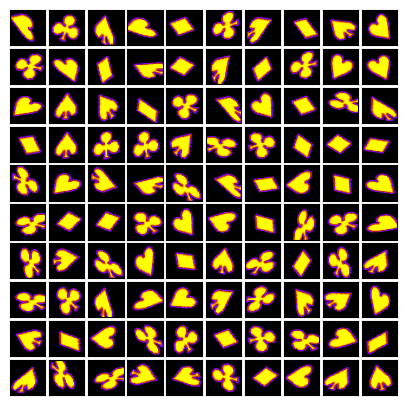

In [6]:
# Plotting random images
np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(10, 10, figsize=(5, 5),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(cards_all))
    ax.imshow(cards_all[i], cmap='gnuplot', interpolation='bilinear')

# VAE on the dataset

First we perform the VAE analysis on the cards data set. VAE analysis is always useful first step when working in the unsupervised or active learning problems, where the feature space is available in full and target space needs to be explored sequentially. Since here we have the access to the ground truth labels, it gives us some idea how the behaviors we can obtain from feature data only (latent representations and distributions) compare to the targets of interest.

If the ground truth data is available (meaning we have toy problem with known answers), visualization of the target fucntion behavior in the latent space allows to have a very good idea how useful the analysis may be on a real data (without the targets available)

In [7]:
# Running the model with atomai rvae
input_dim = (30,30)
vae = aoi.models.VAE(input_dim, latent_dim=2,
                    numlayers_encoder=3, numhidden_encoder=1024,
                    numlayers_decoder=3, numhidden_decoder=1024,
                    skip=True)

vae.fit(cards_all, training_cycles=200, batch_size=75, loss="ce",
         filename='vae')

Epoch: 1/200, Training loss: 311.7576
Epoch: 2/200, Training loss: 261.4235
Epoch: 3/200, Training loss: 239.2507
Epoch: 4/200, Training loss: 224.3549
Epoch: 5/200, Training loss: 219.5787
Epoch: 6/200, Training loss: 215.2641
Epoch: 7/200, Training loss: 210.4019
Epoch: 8/200, Training loss: 205.6571
Epoch: 9/200, Training loss: 201.4374
Epoch: 10/200, Training loss: 197.5007
Epoch: 11/200, Training loss: 193.9141
Epoch: 12/200, Training loss: 190.7320
Epoch: 13/200, Training loss: 187.5367
Epoch: 14/200, Training loss: 184.8035
Epoch: 15/200, Training loss: 182.6227
Epoch: 16/200, Training loss: 179.9630
Epoch: 17/200, Training loss: 177.9862
Epoch: 18/200, Training loss: 176.1422
Epoch: 19/200, Training loss: 173.8870
Epoch: 20/200, Training loss: 172.0510
Epoch: 21/200, Training loss: 170.5415
Epoch: 22/200, Training loss: 169.0592
Epoch: 23/200, Training loss: 167.5222
Epoch: 24/200, Training loss: 165.9809
Epoch: 25/200, Training loss: 164.3092
Epoch: 26/200, Training loss: 162.

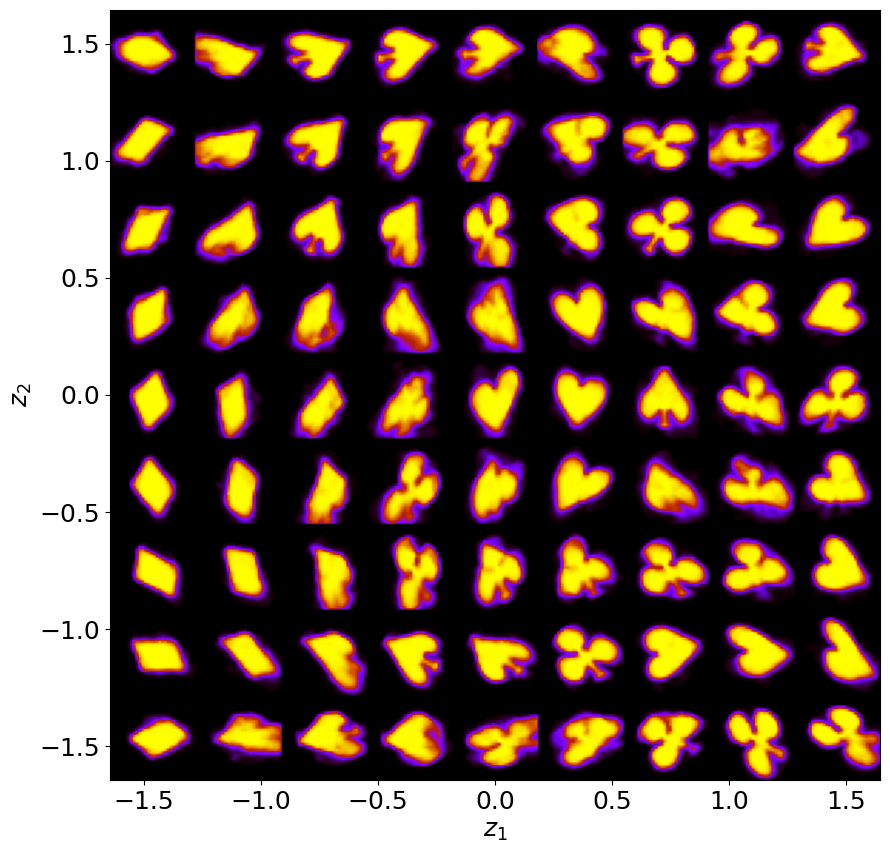

In [8]:
# Latent representation
vae.manifold2d(d = 9, origin = 'upper');

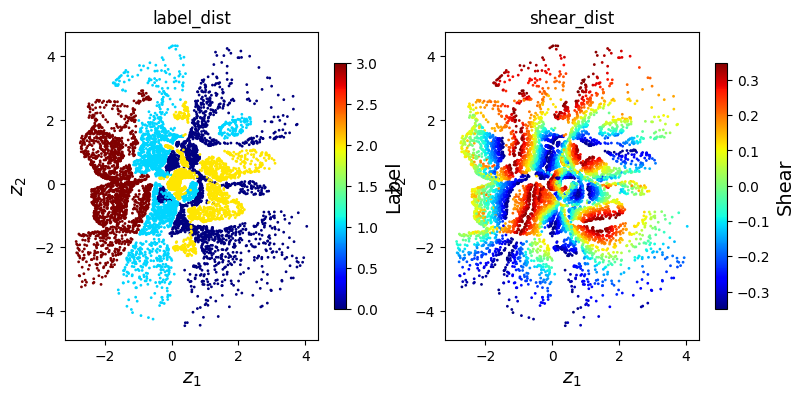

In [9]:
# Latent distributions

z_mean, z_sd = vae.encode(cards_all)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))

im = ax[0].scatter(z_mean[:,-1], z_mean[:,-2], c=labels_all, s=1, cmap='jet')
ax[0].set_title('label_dist')
ax[0].set_xlabel("$z_1$", fontsize=14)
ax[0].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[0], shrink=.8)
cbar.set_label("Label", fontsize=14)
cbar.ax.tick_params(labelsize=10)


im = ax[1].scatter(z_mean[:,-1], z_mean[:,-2], c=shears_all[:,0], s=1, cmap='jet')
ax[1].set_title('shear_dist')
ax[1].set_xlabel("$z_1$", fontsize=14)
ax[1].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Note here that the ground truth labels have very complex distribution in the latent space. This is because different factors of variability including the hand, rotation, and shear "compete" for latent space. The manifolds corresponding to different hands cannot mix (unless objects are identical) as driven by reconstruction loss, but at the same time KL loss tries to bring them together.  

Experiment with the variability of the data set - e.g. the distributions of the angles vs. shear. The manifolds will change!

# rVAE on the dataset

Now, let's check this supposition by running the rotationally invariant VAE, where the rotation is separated into a dedicated latent variable.

In [10]:
# Running the model with atomai rvae
input_dim = (30,30)
rvae = aoi.models.rVAE(input_dim, latent_dim=2,
                        numlayers_encoder=3, numhidden_encoder=1024,
                        numlayers_decoder=3, numhidden_decoder=1024,
                        skip=True)

rvae.fit(cards_all, training_cycles=100, batch_size=75, loss="ce", translation_prior=0.1,
         filename='rvae')

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: 1/100, Training loss: 324.6543
Epoch: 2/100, Training loss: 207.5169
Epoch: 3/100, Training loss: 194.3132
Epoch: 4/100, Training loss: 186.7886
Epoch: 5/100, Training loss: 180.9381
Epoch: 6/100, Training loss: 177.4010
Epoch: 7/100, Training loss: 171.9140
Epoch: 8/100, Training loss: 165.3214
Epoch: 9/100, Training loss: 159.0292
Epoch: 10/100, Training loss: 152.8967
Epoch: 11/100, Training loss: 145.6080
Epoch: 12/100, Training loss: 142.2711
Epoch: 13/100, Training loss: 134.4055
Epoch: 14/100, Training loss: 129.9193
Epoch: 15/100, Training loss: 128.3137
Epoch: 16/100, Training loss: 121.9128
Epoch: 17/100, Training loss: 118.6502
Epoch: 18/100, Training loss: 115.9876
Epoch: 19/100, Training loss: 112.1215
Epoch: 20/100, Training loss: 110.4705
Epoch: 21/100, Training loss: 109.9298
Epoch: 22/100, Training loss: 106.9380
Epoch: 23/100, Training loss: 104.1657
Epoch: 24/100, Training loss: 104.1340
Epoch: 25/100, Training loss: 102.0023
Epoch: 26/100, Training loss: 99.8

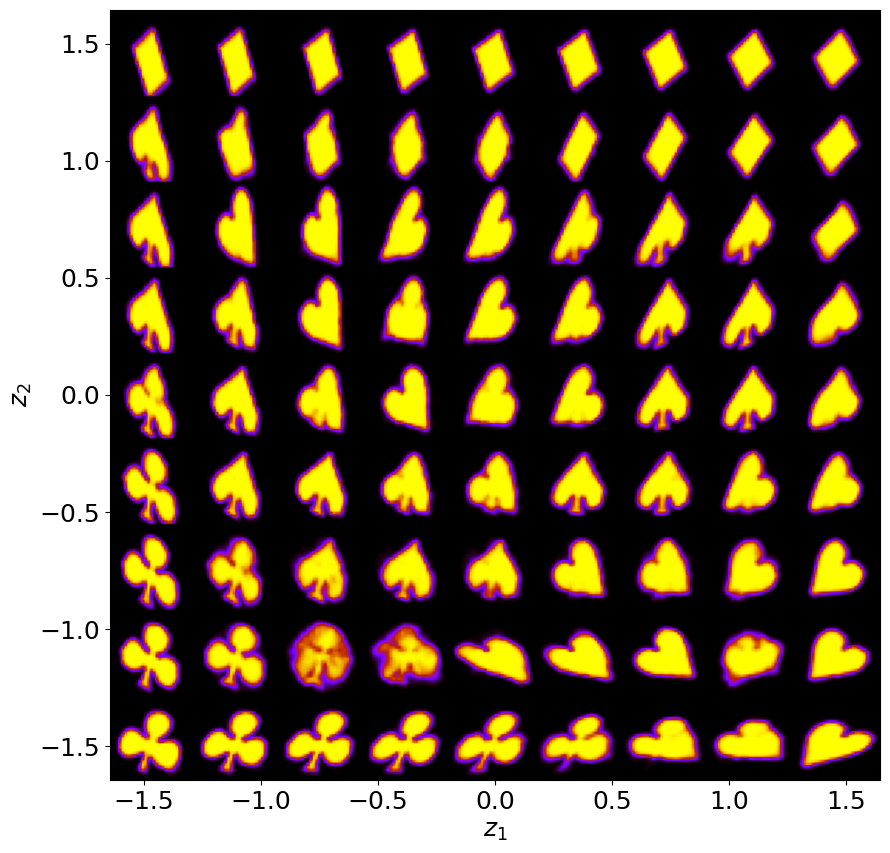

In [11]:
# Latent representation
rvae.manifold2d(d = 9, origin = 'upper');

Text(0, 0.5, 'actual')

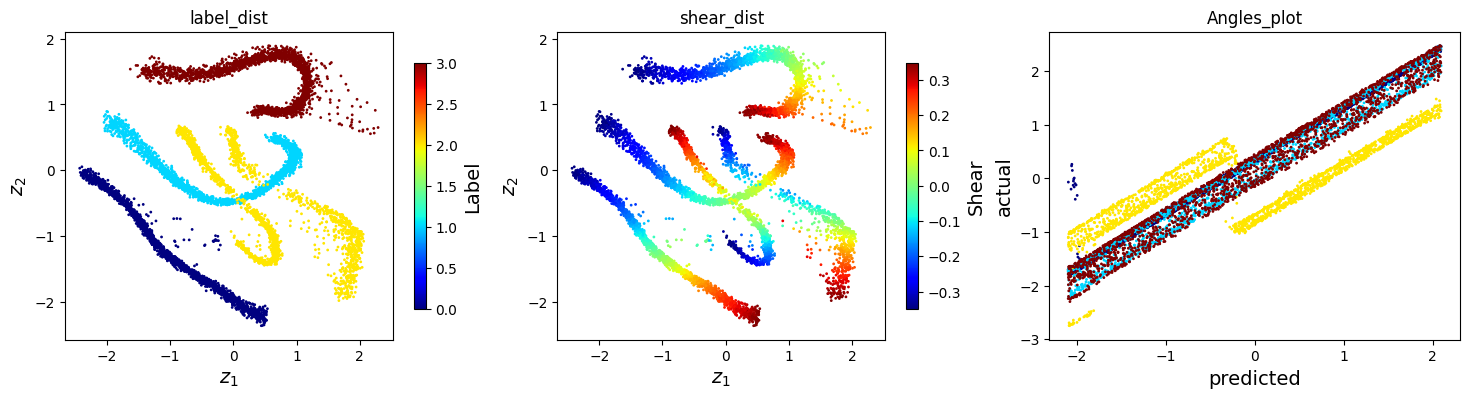

In [12]:
# Latent distributions
z_mean, z_sd = rvae.encode(cards_all)
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18,4))

im = ax[0].scatter(z_mean[:,-1], z_mean[:,-2], c=labels_all, s=1, cmap='jet')
ax[0].set_title('label_dist')
ax[0].set_xlabel("$z_1$", fontsize=14)
ax[0].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[0], shrink=.8)
cbar.set_label("Label", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1].scatter(z_mean[:,-1], z_mean[:,-2], c=shears_all[:,0], s=1, cmap='jet')
ax[1].set_title('shear_dist')
ax[1].set_xlabel("$z_1$", fontsize=14)
ax[1].set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax[1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

ax[2].scatter(torch.deg2rad(angles_all), z_mean[:,0], c = labels_all, s =1, cmap = 'jet')
ax[2].set_title('Angles_plot')
ax[2].set_xlabel("predicted", fontsize=14)
ax[2].set_ylabel("actual", fontsize=14)

In this case, we see well-defined manifolds for different hands, and the shear becomes a parameter that varies along the manifold. It is actually supercool - the VAE basically discovers factors of variability that we used in construction of the original data set (which it of course does not know - it's unsupervised method, and we have not used targets during analysis). This however is not perfect:
 - imaging that colors disappear - will you be able to cluster the data?
 - what about introducing some linear parameter changing across the manifold? Would it be shear?

 rVAE gives us some hints on what are the trends within the data set, but it does not tell us what they are explicitly. Its up to us to discover.

# DKL on cards dataset

Here we explore the DKL as an active learning method to explore the card set. We want to learn the function f(image) -> hand, or f(image) -> (rotation or shear) in th escenario where all images are available, but the function values are becoming available one by one. However, the algorithm can suggest which feature it wants to query (i.e. which experiment it wants to run). This a fairly abstract setting, but it matches a lot of practical process optimization problem (substitute image by the process trajectory, molecular graph, etc).

Again, we are running the DKL as an acrtive learning process - meaning that all the features are available (or equivalently our search space is defined), whereas targets are becoming available sequentially, meaning we are running (expensive) experiments.

We should also define several useful variables, namely, the number of initial samples (for active learning), number of exploration steps, batch size for active learning (should be smaller then number of initial samples, or code will not work), and batch size for reconstructions. Parenthetically, batch size can be variable (so we can increase it when samples are becoming available).

In [13]:
init_num = 20
exp_step = 100
batch_size_learn = 10 #make it 100 if start with 100 seed
batch_size_reconstruct = 250

Note that the number of the initial seeds (20) and exploration steps (100) is very small compared to the full data set (2000). We start with 1% of available data and explore only 5% of available space - and this is for th esystem with storng variability. The reason we are interested in this is because experimental budgets are usually very limited - each experiment costs us time and money.

If interested, you can experiment with the even smaller number of seed and exploration points. The DKL actually behaves remarcably well!

# Single card hand as a function

First, we run the experiment when we try to learn the hands in active manner. Meaning that we care about one specific hand (say clubs), do not care about other three hands, and do not care about the rotations and shear.

## Clubs

In [14]:
X = np.asarray(cards_all).reshape([-1, 900])

First we will run the DKL on the whole dataset. Here, we have (not terribly useful) situation when all features and all targets are available. So this is effectively supervised learning. The reason we are doing it first is to see how do the latent manfolds look like - and compare them to VAE. Rememebr that:
 - VAE build manifolds based on the features only
 - DKL on full data set builds manifolds based on features and targets
 - Active learning DKL build manifolds in such a way as to accelerate discovery process

In [15]:
X0 = np.copy(X)
targets0 = np.zeros(len(labels_all))
targets0[labels_all == 0] = 1

rng_key_0, rng_key_predict_0 = gpax.utils.get_keys()
dkl_0 = gpax.viDKL(900, 2, 'RBF')
dkl_0.fit(rng_key_0, X0, targets0)

100%|██████████| 1000/1000 [03:49<00:00,  4.36it/s, init loss: 69238.9800, avg. loss [951-1000]: 45582.6988]



Inferred GP kernel parameters
k_length         [1.6387 1.2409]
k_scale          0.3583
noise            0.0081


Now can visualize the DKL Latent space with the ground truth labels. Here, it is very instructive to compare it with the VAE latent space. Unsurprisingly, this latent space is much better separated - because we use both features and (all) known targets. The reason why DKL works for active learning is that this structure can be learned with much fewer examples.

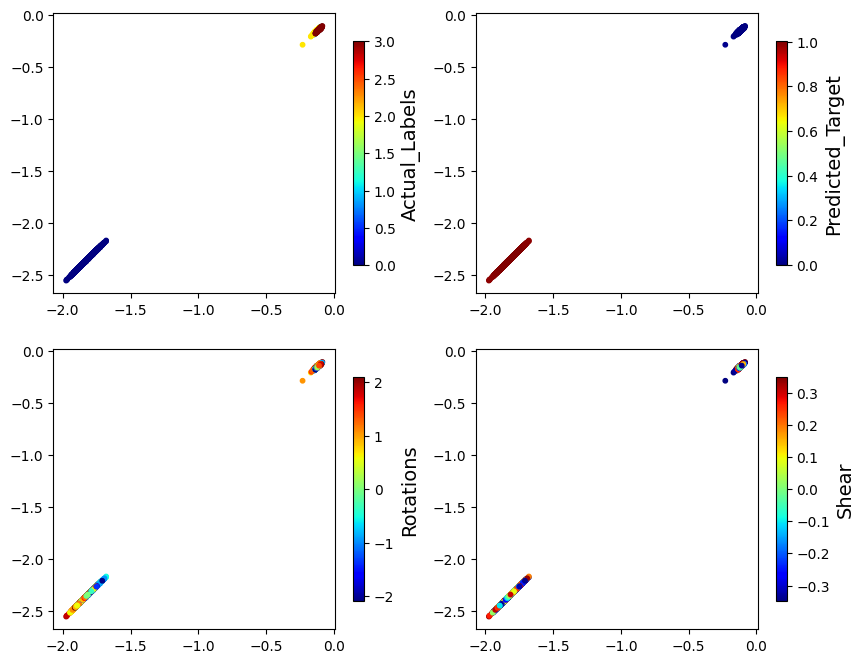

In [16]:
embeded_0 = dkl_0.embed(X0)
pred_mean0, pred_var0 = dkl_0.predict_in_batches(rng_key_predict_0, X0, batch_size=batch_size_reconstruct)
pred_std0 = jnp.sqrt(pred_var0)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))


im = ax[0,0].scatter(embeded_0[:, 1], embeded_0[:, 0], s=10, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_0[:, 1], embeded_0[:, 0], s=10, c = pred_mean0, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_0[:, 1], embeded_0[:, 0], s=10, c = torch.deg2rad(angles_all),
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_0[:, 1], embeded_0[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

For this example, you can see that:
- Latent manifold is effectively 1D (meaning only one factor of variability matters). Compare to VAE, where 2D is not enough
- The clubs form their own group (this is what we wanted to learn), and other hands are all lumped together (so manifold evolved to learn what we wanted to focus on)
- Other factors of variability are not separated very well (if you look at data carefully, there will be some alignment along the manifold)

Overall, we wanted to focus on a particular feature - and we did!

Now, let's run the DKL as an active learning problem. Can we learn this manifold with much fewer examples?
- We will use 20 seed points and 100 exploration points.
- As an aquisition function, we use the upper confidence bound, UCB, function defined as acq_func = mu + 10 * sigma, where mu is predicted value and sigma is uncertainty
- Look for the previous tutorial on Bayesian Optimization for at length discussion of these

In [17]:
np.random.seed(0)
idx0 = np.random.choice(np.arange(len(X0)), size = init_num, replace = False)
X0_train = X0[idx0]
X0_unmeasured = np.delete(X0, idx0, axis=0)

indices_total_0 = np.arange(len(X))
indices_train_0 = indices_total_0[idx0]
y0_train = targets0[idx0]
indices_unmeasured_0 = np.delete(indices_total_0, idx0)

In [18]:
exp_mean0, exp_std0 = [], []
dkl_mean0, dkl_std0 = [], []
embed_traj0 = []
traj_mean0, traj_std0 = [], []

exploration_steps = exp_step


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key10, rng_key_predict10 = gpax.utils.get_keys()
    dkl_BO_0 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_0.fit(rng_key10, X0_train, y0_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_0.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict10, X0_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()

    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean0.append(y_mean[id_next])
    exp_std0.append(y_std[id_next])

    x_next = X0_unmeasured[id_next]
    ind_next = indices_unmeasured_0[id_next]

    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean0.append(pred_mean0[ind_next])
    dkl_std0.append(pred_std0[ind_next])

    # For now we will only read out the brute force results
    y_measured = targets0[ind_next]

    # Update training arrays
    X0_train = np.append(X0_train, x_next[None], axis=0)
    y0_train = np.append(y0_train, y_measured)
    X0_unmeasured = np.delete(X0_unmeasured, id_next, axis=0)
    indices_unmeasured_0 = np.delete(indices_unmeasured_0, id_next)

    embed_traj = dkl_BO_0.embed(X0_train)
    traj_m, traj_s = dkl_BO_0.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict10, X0_train, batch_size=batch_size_learn)

    embed_traj0.append(embed_traj)
    traj_mean0.append(traj_m)


Step 1


100%|██████████| 1000/1000 [00:02<00:00, 453.79it/s, init loss: 60101.2042, avg. loss [951-1000]: 56924.3895]



Inferred GP kernel parameters
k_length         [0.3698 0.3426]
k_scale          0.41190000000000004
noise            0.0152

Step 2


100%|██████████| 1000/1000 [00:02<00:00, 447.87it/s, init loss: 60102.7022, avg. loss [951-1000]: 56921.2186]



Inferred GP kernel parameters
k_length         [0.3666 0.3215]
k_scale          0.4325
noise            0.0125

Step 3


100%|██████████| 1000/1000 [00:02<00:00, 383.81it/s, init loss: 60104.1935, avg. loss [951-1000]: 56922.1810]



Inferred GP kernel parameters
k_length         [0.3614 0.3149]
k_scale          0.3536
noise            0.0132

Step 4


100%|██████████| 1000/1000 [00:02<00:00, 459.75it/s, init loss: 60105.4191, avg. loss [951-1000]: 56918.5317]



Inferred GP kernel parameters
k_length         [0.3679 0.3217]
k_scale          0.43010000000000004
noise            0.0118

Step 5


100%|██████████| 1000/1000 [00:02<00:00, 462.01it/s, init loss: 60106.9242, avg. loss [951-1000]: 56921.3357]



Inferred GP kernel parameters
k_length         [0.3735 0.4209]
k_scale          0.442
noise            0.0117

Step 6


100%|██████████| 1000/1000 [00:02<00:00, 455.91it/s, init loss: 60108.4285, avg. loss [951-1000]: 56922.3664]



Inferred GP kernel parameters
k_length         [0.346  0.3594]
k_scale          0.5172
noise            0.0146

Step 7


100%|██████████| 1000/1000 [00:02<00:00, 391.76it/s, init loss: 60109.6721, avg. loss [951-1000]: 56927.1353]



Inferred GP kernel parameters
k_length         [0.3679 0.3216]
k_scale          0.4828
noise            0.0151

Step 8


100%|██████████| 1000/1000 [00:02<00:00, 459.30it/s, init loss: 60110.9162, avg. loss [951-1000]: 56924.6594]



Inferred GP kernel parameters
k_length         [0.3673 0.3183]
k_scale          0.4969
noise            0.014100000000000001

Step 9


100%|██████████| 1000/1000 [00:02<00:00, 464.32it/s, init loss: 60112.4213, avg. loss [951-1000]: 56914.4329]



Inferred GP kernel parameters
k_length         [0.4289 0.3641]
k_scale          0.38630000000000003
noise            0.0118

Step 10


100%|██████████| 1000/1000 [00:02<00:00, 460.75it/s, init loss: 60113.9129, avg. loss [951-1000]: 56910.5276]



Inferred GP kernel parameters
k_length         [0.3683 0.3423]
k_scale          0.41000000000000003
noise            0.0102

Step 11


100%|██████████| 1000/1000 [00:02<00:00, 453.29it/s, init loss: 60115.1441, avg. loss [951-1000]: 56930.6771]



Inferred GP kernel parameters
k_length         [0.3228 0.3855]
k_scale          0.4536
noise            0.015000000000000001

Step 12


100%|██████████| 1000/1000 [00:02<00:00, 381.89it/s, init loss: 60116.3844, avg. loss [951-1000]: 56916.7223]



Inferred GP kernel parameters
k_length         [0.3858 0.3823]
k_scale          0.32
noise            0.0109

Step 13


100%|██████████| 1000/1000 [00:02<00:00, 451.68it/s, init loss: 60117.6287, avg. loss [951-1000]: 56920.9292]



Inferred GP kernel parameters
k_length         [0.4419 0.4325]
k_scale          0.36920000000000003
noise            0.010700000000000001

Step 14


100%|██████████| 1000/1000 [00:02<00:00, 447.69it/s, init loss: 60118.8656, avg. loss [951-1000]: 56910.4247]



Inferred GP kernel parameters
k_length         [0.3939 0.3569]
k_scale          0.3674
noise            0.0098

Step 15


100%|██████████| 1000/1000 [00:02<00:00, 445.40it/s, init loss: 60120.1099, avg. loss [951-1000]: 56904.8369]



Inferred GP kernel parameters
k_length         [0.3682 0.3346]
k_scale          0.3911
noise            0.0097

Step 16


100%|██████████| 1000/1000 [00:02<00:00, 441.48it/s, init loss: 60121.4452, avg. loss [951-1000]: 56907.5640]



Inferred GP kernel parameters
k_length         [0.3763 0.4504]
k_scale          0.3604
noise            0.0103

Step 17


100%|██████████| 1000/1000 [00:02<00:00, 435.89it/s, init loss: 60122.8023, avg. loss [951-1000]: 56920.6075]



Inferred GP kernel parameters
k_length         [0.4403 0.3641]
k_scale          0.29700000000000004
noise            0.0152

Step 18


100%|██████████| 1000/1000 [00:02<00:00, 446.83it/s, init loss: 60124.0465, avg. loss [951-1000]: 56899.2302]



Inferred GP kernel parameters
k_length         [0.3677 0.3197]
k_scale          0.41550000000000004
noise            0.0095

Step 19


100%|██████████| 1000/1000 [00:02<00:00, 447.35it/s, init loss: 60125.3637, avg. loss [951-1000]: 56897.2413]



Inferred GP kernel parameters
k_length         [0.3679 0.326 ]
k_scale          0.41960000000000003
noise            0.0091

Step 20


100%|██████████| 1000/1000 [00:02<00:00, 447.70it/s, init loss: 60126.8027, avg. loss [951-1000]: 56897.7927]



Inferred GP kernel parameters
k_length         [0.3679 0.3323]
k_scale          0.3846
noise            0.0089

Step 21


100%|██████████| 1000/1000 [00:02<00:00, 432.53it/s, init loss: 60128.0470, avg. loss [951-1000]: 56894.2225]



Inferred GP kernel parameters
k_length         [0.3338 0.3679]
k_scale          0.4213
noise            0.0088

Step 22


100%|██████████| 1000/1000 [00:02<00:00, 440.66it/s, init loss: 60129.5454, avg. loss [951-1000]: 56893.9868]



Inferred GP kernel parameters
k_length         [0.3292 0.3679]
k_scale          0.4202
noise            0.0088

Step 23


100%|██████████| 1000/1000 [00:02<00:00, 445.63it/s, init loss: 60131.0480, avg. loss [951-1000]: 56895.0765]



Inferred GP kernel parameters
k_length         [0.3687 0.35  ]
k_scale          0.3679
noise            0.009300000000000001

Step 24


100%|██████████| 1000/1000 [00:02<00:00, 358.74it/s, init loss: 60132.2917, avg. loss [951-1000]: 56909.4127]



Inferred GP kernel parameters
k_length         [0.3638 0.5375]
k_scale          0.3316
noise            0.009300000000000001

Step 25


100%|██████████| 1000/1000 [00:02<00:00, 445.18it/s, init loss: 60133.7011, avg. loss [951-1000]: 56891.7158]



Inferred GP kernel parameters
k_length         [0.4122 0.3497]
k_scale          0.35000000000000003
noise            0.0091

Step 26


100%|██████████| 1000/1000 [00:02<00:00, 430.85it/s, init loss: 60135.2062, avg. loss [951-1000]: 56892.9624]



Inferred GP kernel parameters
k_length         [0.3781 0.3772]
k_scale          0.3436
noise            0.009300000000000001

Step 27


100%|██████████| 1000/1000 [00:02<00:00, 443.61it/s, init loss: 60136.7063, avg. loss [951-1000]: 56911.2953]



Inferred GP kernel parameters
k_length         [0.5411 0.4797]
k_scale          0.31670000000000004
noise            0.0122

Step 28


100%|██████████| 1000/1000 [00:02<00:00, 441.99it/s, init loss: 60138.1494, avg. loss [951-1000]: 56886.0150]



Inferred GP kernel parameters
k_length         [0.3687 0.3675]
k_scale          0.41100000000000003
noise            0.0086

Step 29


100%|██████████| 1000/1000 [00:02<00:00, 443.89it/s, init loss: 60139.6544, avg. loss [951-1000]: 56882.8012]



Inferred GP kernel parameters
k_length         [0.3361 0.3679]
k_scale          0.4202
noise            0.0085

Step 30


100%|██████████| 1000/1000 [00:02<00:00, 438.30it/s, init loss: 60141.1595, avg. loss [951-1000]: 56882.6898]



Inferred GP kernel parameters
k_length         [0.3679 0.3325]
k_scale          0.4156
noise            0.0086

Step 31


100%|██████████| 1000/1000 [00:02<00:00, 340.77it/s, init loss: 60142.5569, avg. loss [951-1000]: 56880.7755]



Inferred GP kernel parameters
k_length         [0.3679 0.3405]
k_scale          0.4138
noise            0.008700000000000001

Step 32


100%|██████████| 1000/1000 [00:02<00:00, 435.73it/s, init loss: 60143.7859, avg. loss [951-1000]: 56885.6815]



Inferred GP kernel parameters
k_length         [0.4814 0.3926]
k_scale          0.34400000000000003
noise            0.009300000000000001

Step 33


100%|██████████| 1000/1000 [00:02<00:00, 437.09it/s, init loss: 60145.2732, avg. loss [951-1000]: 56954.7222]



Inferred GP kernel parameters
k_length         [0.5537 0.6068]
k_scale          0.2857
noise            0.014

Step 34


100%|██████████| 1000/1000 [00:02<00:00, 428.07it/s, init loss: 60146.4867, avg. loss [951-1000]: 56885.6273]



Inferred GP kernel parameters
k_length         [0.4017 0.4153]
k_scale          0.30560000000000004
noise            0.0089

Step 35


100%|██████████| 1000/1000 [00:02<00:00, 438.01it/s, init loss: 60147.9918, avg. loss [951-1000]: 56887.9605]



Inferred GP kernel parameters
k_length         [0.4161 0.4678]
k_scale          0.31720000000000004
noise            0.01

Step 36


100%|██████████| 1000/1000 [00:02<00:00, 436.04it/s, init loss: 60149.4749, avg. loss [951-1000]: 56885.0801]



Inferred GP kernel parameters
k_length         [0.6012 0.4135]
k_scale          0.3015
noise            0.01

Step 37


100%|██████████| 1000/1000 [00:02<00:00, 440.42it/s, init loss: 60150.7168, avg. loss [951-1000]: 56898.3669]



Inferred GP kernel parameters
k_length         [0.4508 0.352 ]
k_scale          0.3577
noise            0.0095

Step 38


100%|██████████| 1000/1000 [00:02<00:00, 439.87it/s, init loss: 60152.1436, avg. loss [951-1000]: 56871.0282]



Inferred GP kernel parameters
k_length         [0.3684 0.3301]
k_scale          0.42400000000000004
noise            0.0085

Step 39


100%|██████████| 1000/1000 [00:02<00:00, 442.76it/s, init loss: 60153.3233, avg. loss [951-1000]: 56868.2237]



Inferred GP kernel parameters
k_length         [0.3679 0.3172]
k_scale          0.42310000000000003
noise            0.0081

Step 40


100%|██████████| 1000/1000 [00:02<00:00, 441.88it/s, init loss: 60154.8144, avg. loss [951-1000]: 56866.9614]



Inferred GP kernel parameters
k_length         [0.3674 0.3361]
k_scale          0.43170000000000003
noise            0.0083

Step 41


100%|██████████| 1000/1000 [00:02<00:00, 442.00it/s, init loss: 60156.3163, avg. loss [951-1000]: 56867.8174]



Inferred GP kernel parameters
k_length         [0.3708 0.3343]
k_scale          0.3634
noise            0.0085

Step 42


100%|██████████| 1000/1000 [00:02<00:00, 442.41it/s, init loss: 60157.8207, avg. loss [951-1000]: 56879.8434]



Inferred GP kernel parameters
k_length         [0.3944 0.3991]
k_scale          0.33630000000000004
noise            0.0108

Step 43


100%|██████████| 1000/1000 [00:02<00:00, 445.14it/s, init loss: 60159.0805, avg. loss [951-1000]: 56935.2703]



Inferred GP kernel parameters
k_length         [0.7058 0.4767]
k_scale          0.3285
noise            0.0131

Step 44


100%|██████████| 1000/1000 [00:02<00:00, 443.49it/s, init loss: 60160.3248, avg. loss [951-1000]: 56862.9873]



Inferred GP kernel parameters
k_length         [0.367  0.3346]
k_scale          0.41500000000000004
noise            0.0082

Step 45


100%|██████████| 1000/1000 [00:02<00:00, 430.81it/s, init loss: 60161.5617, avg. loss [951-1000]: 56870.5044]



Inferred GP kernel parameters
k_length         [0.4536 0.4309]
k_scale          0.4606
noise            0.009300000000000001

Step 46


100%|██████████| 1000/1000 [00:02<00:00, 425.95it/s, init loss: 60163.0534, avg. loss [951-1000]: 56933.7990]



Inferred GP kernel parameters
k_length         [0.3367 0.2764]
k_scale          0.4182
noise            0.0103

Step 47


100%|██████████| 1000/1000 [00:03<00:00, 322.60it/s, init loss: 60164.5330, avg. loss [951-1000]: 56861.3083]



Inferred GP kernel parameters
k_length         [0.3626 0.3497]
k_scale          0.3547
noise            0.0089

Step 48


100%|██████████| 1000/1000 [00:02<00:00, 434.22it/s, init loss: 60166.0257, avg. loss [951-1000]: 56860.0885]



Inferred GP kernel parameters
k_length         [0.3689 0.3386]
k_scale          0.35850000000000004
noise            0.0086

Step 49


100%|██████████| 1000/1000 [00:02<00:00, 440.07it/s, init loss: 60167.5252, avg. loss [951-1000]: 57018.2756]



Inferred GP kernel parameters
k_length         [0.4919 0.4071]
k_scale          0.3411
noise            0.011300000000000001

Step 50


100%|██████████| 1000/1000 [00:02<00:00, 440.44it/s, init loss: 60168.7478, avg. loss [951-1000]: 56862.2467]



Inferred GP kernel parameters
k_length         [0.3942 0.3995]
k_scale          0.3241
noise            0.0089

Step 51


100%|██████████| 1000/1000 [00:02<00:00, 433.49it/s, init loss: 60170.2428, avg. loss [951-1000]: 56851.0667]



Inferred GP kernel parameters
k_length         [0.3592 0.2976]
k_scale          0.4309
noise            0.008

Step 52


100%|██████████| 1000/1000 [00:02<00:00, 424.44it/s, init loss: 60171.4615, avg. loss [951-1000]: 56859.0865]



Inferred GP kernel parameters
k_length         [0.4226 0.4587]
k_scale          0.38280000000000003
noise            0.0094

Step 53


100%|██████████| 1000/1000 [00:02<00:00, 438.00it/s, init loss: 60172.8086, avg. loss [951-1000]: 56890.2255]



Inferred GP kernel parameters
k_length         [0.5583 0.4196]
k_scale          0.3002
noise            0.009000000000000001

Step 54


100%|██████████| 1000/1000 [00:02<00:00, 434.78it/s, init loss: 60173.9688, avg. loss [951-1000]: 56859.6358]



Inferred GP kernel parameters
k_length         [0.5676 0.4888]
k_scale          0.34240000000000004
noise            0.009600000000000001

Step 55


100%|██████████| 1000/1000 [00:02<00:00, 440.09it/s, init loss: 60175.4740, avg. loss [951-1000]: 56850.8183]



Inferred GP kernel parameters
k_length         [0.3676 0.3623]
k_scale          0.3357
noise            0.0085

Step 56


100%|██████████| 1000/1000 [00:02<00:00, 437.87it/s, init loss: 60176.7867, avg. loss [951-1000]: 56868.1782]



Inferred GP kernel parameters
k_length         [0.4686 0.413 ]
k_scale          0.3372
noise            0.008700000000000001

Step 57


100%|██████████| 1000/1000 [00:02<00:00, 432.75it/s, init loss: 60178.0310, avg. loss [951-1000]: 56843.3111]



Inferred GP kernel parameters
k_length         [0.352  0.3337]
k_scale          0.4113
noise            0.0081

Step 58


100%|██████████| 1000/1000 [00:02<00:00, 419.09it/s, init loss: 60179.3781, avg. loss [951-1000]: 56843.9084]



Inferred GP kernel parameters
k_length         [0.3338 0.3717]
k_scale          0.4048
noise            0.0083

Step 59


100%|██████████| 1000/1000 [00:02<00:00, 442.33it/s, init loss: 60180.8344, avg. loss [951-1000]: 56851.5827]



Inferred GP kernel parameters
k_length         [0.4115 0.4387]
k_scale          0.29460000000000003
noise            0.0086

Step 60


100%|██████████| 1000/1000 [00:02<00:00, 421.45it/s, init loss: 60182.3246, avg. loss [951-1000]: 56845.2036]



Inferred GP kernel parameters
k_length         [0.3808 0.3626]
k_scale          0.334
noise            0.008400000000000001

Step 61


100%|██████████| 1000/1000 [00:02<00:00, 440.39it/s, init loss: 60183.8274, avg. loss [951-1000]: 56846.1930]



Inferred GP kernel parameters
k_length         [0.3723 0.3901]
k_scale          0.33540000000000003
noise            0.008400000000000001

Step 62


100%|██████████| 1000/1000 [00:02<00:00, 448.46it/s, init loss: 60185.2362, avg. loss [951-1000]: 56842.0821]



Inferred GP kernel parameters
k_length         [0.3653 0.3862]
k_scale          0.394
noise            0.009000000000000001

Step 63


100%|██████████| 1000/1000 [00:02<00:00, 428.04it/s, init loss: 60186.4942, avg. loss [951-1000]: 56835.0266]



Inferred GP kernel parameters
k_length         [0.3683 0.3287]
k_scale          0.4186
noise            0.008

Step 64


100%|██████████| 1000/1000 [00:02<00:00, 453.11it/s, init loss: 60187.9285, avg. loss [951-1000]: 56879.8843]



Inferred GP kernel parameters
k_length         [0.4806 0.3743]
k_scale          0.2968
noise            0.0097

Step 65


100%|██████████| 1000/1000 [00:02<00:00, 438.72it/s, init loss: 60189.3504, avg. loss [951-1000]: 56861.7697]



Inferred GP kernel parameters
k_length         [0.4403 0.5319]
k_scale          0.3315
noise            0.0105

Step 66


100%|██████████| 1000/1000 [00:02<00:00, 444.47it/s, init loss: 60190.7788, avg. loss [951-1000]: 56836.2964]



Inferred GP kernel parameters
k_length         [0.3714 0.3493]
k_scale          0.4269
noise            0.009600000000000001

Step 67


100%|██████████| 1000/1000 [00:03<00:00, 309.52it/s, init loss: 60192.2515, avg. loss [951-1000]: 56833.3225]



Inferred GP kernel parameters
k_length         [0.4189 0.457 ]
k_scale          0.38130000000000003
noise            0.008700000000000001

Step 68


100%|██████████| 1000/1000 [00:02<00:00, 425.35it/s, init loss: 60193.7286, avg. loss [951-1000]: 56834.7435]



Inferred GP kernel parameters
k_length         [0.4047 0.413 ]
k_scale          0.3133
noise            0.0083

Step 69


100%|██████████| 1000/1000 [00:02<00:00, 431.91it/s, init loss: 60195.2337, avg. loss [951-1000]: 56858.7323]



Inferred GP kernel parameters
k_length         [0.3964 0.3641]
k_scale          0.3022
noise            0.0103

Step 70


100%|██████████| 1000/1000 [00:02<00:00, 434.54it/s, init loss: 60196.6580, avg. loss [951-1000]: 56830.2223]



Inferred GP kernel parameters
k_length         [0.3954 0.3925]
k_scale          0.3635
noise            0.0082

Step 71


100%|██████████| 1000/1000 [00:02<00:00, 434.95it/s, init loss: 60198.1468, avg. loss [951-1000]: 56829.8508]



Inferred GP kernel parameters
k_length         [0.3694 0.3646]
k_scale          0.3507
noise            0.008

Step 72


100%|██████████| 1000/1000 [00:02<00:00, 430.25it/s, init loss: 60199.5008, avg. loss [951-1000]: 56836.8187]



Inferred GP kernel parameters
k_length         [0.3639 0.3742]
k_scale          0.30010000000000003
noise            0.008700000000000001

Step 73


100%|██████████| 1000/1000 [00:02<00:00, 428.97it/s, init loss: 60201.0037, avg. loss [951-1000]: 56842.9260]



Inferred GP kernel parameters
k_length         [0.5989 0.6079]
k_scale          0.2948
noise            0.0092

Step 74


100%|██████████| 1000/1000 [00:02<00:00, 425.00it/s, init loss: 60202.5063, avg. loss [951-1000]: 56827.3114]



Inferred GP kernel parameters
k_length         [0.4397 0.3997]
k_scale          0.3032
noise            0.0081

Step 75


100%|██████████| 1000/1000 [00:02<00:00, 431.43it/s, init loss: 60203.8110, avg. loss [951-1000]: 56831.7607]



Inferred GP kernel parameters
k_length         [0.4771 0.451 ]
k_scale          0.3516
noise            0.008700000000000001

Step 76


100%|██████████| 1000/1000 [00:02<00:00, 434.99it/s, init loss: 60205.3161, avg. loss [951-1000]: 56825.1735]



Inferred GP kernel parameters
k_length         [0.383  0.3725]
k_scale          0.30560000000000004
noise            0.008

Step 77


100%|██████████| 1000/1000 [00:02<00:00, 433.72it/s, init loss: 60206.6580, avg. loss [951-1000]: 56813.3094]



Inferred GP kernel parameters
k_length         [0.369  0.3247]
k_scale          0.4264
noise            0.0078000000000000005

Step 78


100%|██████████| 1000/1000 [00:02<00:00, 437.85it/s, init loss: 60208.1377, avg. loss [951-1000]: 56827.9934]



Inferred GP kernel parameters
k_length         [0.4917 0.5222]
k_scale          0.2817
noise            0.0089

Step 79


100%|██████████| 1000/1000 [00:02<00:00, 434.10it/s, init loss: 60209.5010, avg. loss [951-1000]: 56815.9756]



Inferred GP kernel parameters
k_length         [0.3898 0.3753]
k_scale          0.38880000000000003
noise            0.0085

Step 80


100%|██████████| 1000/1000 [00:02<00:00, 431.45it/s, init loss: 60210.9386, avg. loss [951-1000]: 56896.3818]



Inferred GP kernel parameters
k_length         [0.5363 0.7876]
k_scale          0.28550000000000003
noise            0.012100000000000001

Step 81


100%|██████████| 1000/1000 [00:02<00:00, 434.26it/s, init loss: 60212.1500, avg. loss [951-1000]: 56818.0614]



Inferred GP kernel parameters
k_length         [0.4905 0.4183]
k_scale          0.2791
noise            0.0086

Step 82


100%|██████████| 1000/1000 [00:02<00:00, 430.59it/s, init loss: 60213.3943, avg. loss [951-1000]: 56811.5392]



Inferred GP kernel parameters
k_length         [0.3677 0.3464]
k_scale          0.3231
noise            0.008

Step 83


100%|██████████| 1000/1000 [00:02<00:00, 424.00it/s, init loss: 60214.6989, avg. loss [951-1000]: 56808.1824]



Inferred GP kernel parameters
k_length         [0.398  0.3863]
k_scale          0.3816
noise            0.0083

Step 84


100%|██████████| 1000/1000 [00:02<00:00, 434.50it/s, init loss: 60215.9432, avg. loss [951-1000]: 56808.7405]



Inferred GP kernel parameters
k_length         [0.3903 0.3587]
k_scale          0.3904
noise            0.0083

Step 85


100%|██████████| 1000/1000 [00:02<00:00, 427.58it/s, init loss: 60217.3264, avg. loss [951-1000]: 56842.7808]



Inferred GP kernel parameters
k_length         [0.5231 0.5174]
k_scale          0.26980000000000004
noise            0.0098

Step 86


100%|██████████| 1000/1000 [00:02<00:00, 434.67it/s, init loss: 60218.5497, avg. loss [951-1000]: 56814.2186]



Inferred GP kernel parameters
k_length         [0.4126 0.6319]
k_scale          0.2846
noise            0.0085

Step 87


100%|██████████| 1000/1000 [00:02<00:00, 434.63it/s, init loss: 60219.8946, avg. loss [951-1000]: 56812.3943]



Inferred GP kernel parameters
k_length         [0.3899 0.401 ]
k_scale          0.2844
noise            0.008400000000000001

Step 88


100%|██████████| 1000/1000 [00:02<00:00, 438.50it/s, init loss: 60221.3269, avg. loss [951-1000]: 56812.4303]



Inferred GP kernel parameters
k_length         [0.495  0.3973]
k_scale          0.32730000000000004
noise            0.009600000000000001

Step 89


100%|██████████| 1000/1000 [00:02<00:00, 429.20it/s, init loss: 60222.7041, avg. loss [951-1000]: 56815.3329]



Inferred GP kernel parameters
k_length         [0.4096 0.3744]
k_scale          0.3282
noise            0.009600000000000001

Step 90


100%|██████████| 1000/1000 [00:02<00:00, 442.76it/s, init loss: 60223.9374, avg. loss [951-1000]: 56800.6806]



Inferred GP kernel parameters
k_length         [0.3839 0.354 ]
k_scale          0.4181
noise            0.0085

Step 91


100%|██████████| 1000/1000 [00:02<00:00, 438.96it/s, init loss: 60225.1693, avg. loss [951-1000]: 56794.2995]



Inferred GP kernel parameters
k_length         [0.3721 0.3548]
k_scale          0.41650000000000004
noise            0.0079

Step 92


100%|██████████| 1000/1000 [00:02<00:00, 436.23it/s, init loss: 60226.4997, avg. loss [951-1000]: 56796.5954]



Inferred GP kernel parameters
k_length         [0.4834 0.3987]
k_scale          0.3456
noise            0.0081

Step 93


100%|██████████| 1000/1000 [00:02<00:00, 437.08it/s, init loss: 60227.7169, avg. loss [951-1000]: 56792.6035]



Inferred GP kernel parameters
k_length         [0.3881 0.414 ]
k_scale          0.403
noise            0.008

Step 94


100%|██████████| 1000/1000 [00:02<00:00, 442.36it/s, init loss: 60229.1727, avg. loss [951-1000]: 56798.4444]



Inferred GP kernel parameters
k_length         [0.3789 0.4079]
k_scale          0.2998
noise            0.0082

Step 95


100%|██████████| 1000/1000 [00:02<00:00, 425.57it/s, init loss: 60230.5724, avg. loss [951-1000]: 56799.7198]



Inferred GP kernel parameters
k_length         [0.4005 0.419 ]
k_scale          0.3194
noise            0.0086

Step 96


100%|██████████| 1000/1000 [00:02<00:00, 436.03it/s, init loss: 60232.0368, avg. loss [951-1000]: 56789.8752]



Inferred GP kernel parameters
k_length         [0.355  0.3942]
k_scale          0.3593
noise            0.0081

Step 97


100%|██████████| 1000/1000 [00:02<00:00, 431.90it/s, init loss: 60233.5174, avg. loss [951-1000]: 56807.1830]



Inferred GP kernel parameters
k_length         [0.4349 0.5435]
k_scale          0.3141
noise            0.009000000000000001

Step 98


100%|██████████| 1000/1000 [00:02<00:00, 430.84it/s, init loss: 60234.8343, avg. loss [951-1000]: 56798.7753]



Inferred GP kernel parameters
k_length         [0.4055 0.4221]
k_scale          0.2861
noise            0.0086

Step 99


100%|██████████| 1000/1000 [00:02<00:00, 428.39it/s, init loss: 60236.0785, avg. loss [951-1000]: 56792.8311]



Inferred GP kernel parameters
k_length         [0.3918 0.4604]
k_scale          0.2654
noise            0.0082

Step 100


100%|██████████| 1000/1000 [00:02<00:00, 434.47it/s, init loss: 60237.3337, avg. loss [951-1000]: 56785.5246]



Inferred GP kernel parameters
k_length         [0.4243 0.4496]
k_scale          0.3658
noise            0.0081


In [19]:
# Saving the results
clubs_results = {}
clubs_results['X_train'] = X0_train
clubs_results['y_train'] = y0_train
clubs_results['X_unmeasured'] = X0_unmeasured
clubs_results['indices_unmeasured'] = indices_unmeasured_0
clubs_results['dkl_mean'] = dkl_mean0
clubs_results['dkl_std'] = dkl_std0
clubs_results['exp_mean'] = exp_mean0
clubs_results['exp_std'] = exp_std0
clubs_results['traj_mean'] = traj_mean0
clubs_results['traj_std'] = traj_std0
clubs_results['embed_traj'] = embed_traj0

with open('clubs_results.pickle', 'wb') as handle:
    pickle.dump(clubs_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
# Loading the results
with open('clubs_results.pickle', 'rb') as f:
    clubs_results = pickle.load(f)

X0_train = clubs_results['X_train']
y0_train = clubs_results['y_train']
X0_unmeasured = clubs_results['X_unmeasured']
indices_unmeasured_0 = clubs_results['indices_unmeasured']
dkl_mean0 = clubs_results['dkl_mean']
dkl_std0 = clubs_results['dkl_std']
exp_mean0 = clubs_results['exp_mean']
exp_std0 = clubs_results['exp_std']
traj_mean0 = clubs_results['traj_mean']
traj_std0 = clubs_results['traj_std']
embed_traj0 = clubs_results['embed_traj']

In [21]:
rng_key10, rng_key_predict10 = gpax.utils.get_keys()
dkl_BO_0 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_0.fit(rng_key10, X0_train, y0_train)

predmean_train0, predstd_train0 = dkl_BO_0.predict_in_batches(rng_key_predict10, X0_train, batch_size = batch_size_learn)
predmean_unmeas0, predstd_unmeas0 = dkl_BO_0.predict_in_batches(rng_key_predict10, X0_unmeasured, batch_size = batch_size_reconstruct)
predmean10, predstd10 = dkl_BO_0.predict_in_batches(rng_key_predict10, X0, batch_size = batch_size_reconstruct)

100%|██████████| 1000/1000 [00:02<00:00, 443.57it/s, init loss: 60238.8362, avg. loss [951-1000]: 56801.0467]



Inferred GP kernel parameters
k_length         [0.5244 0.4233]
k_scale          0.3088
noise            0.009600000000000001


The first row corresponds to explored, unexplored, and all datapoints colored using the predicted target property  
Second row is the latent space distributions colored with various ground truths

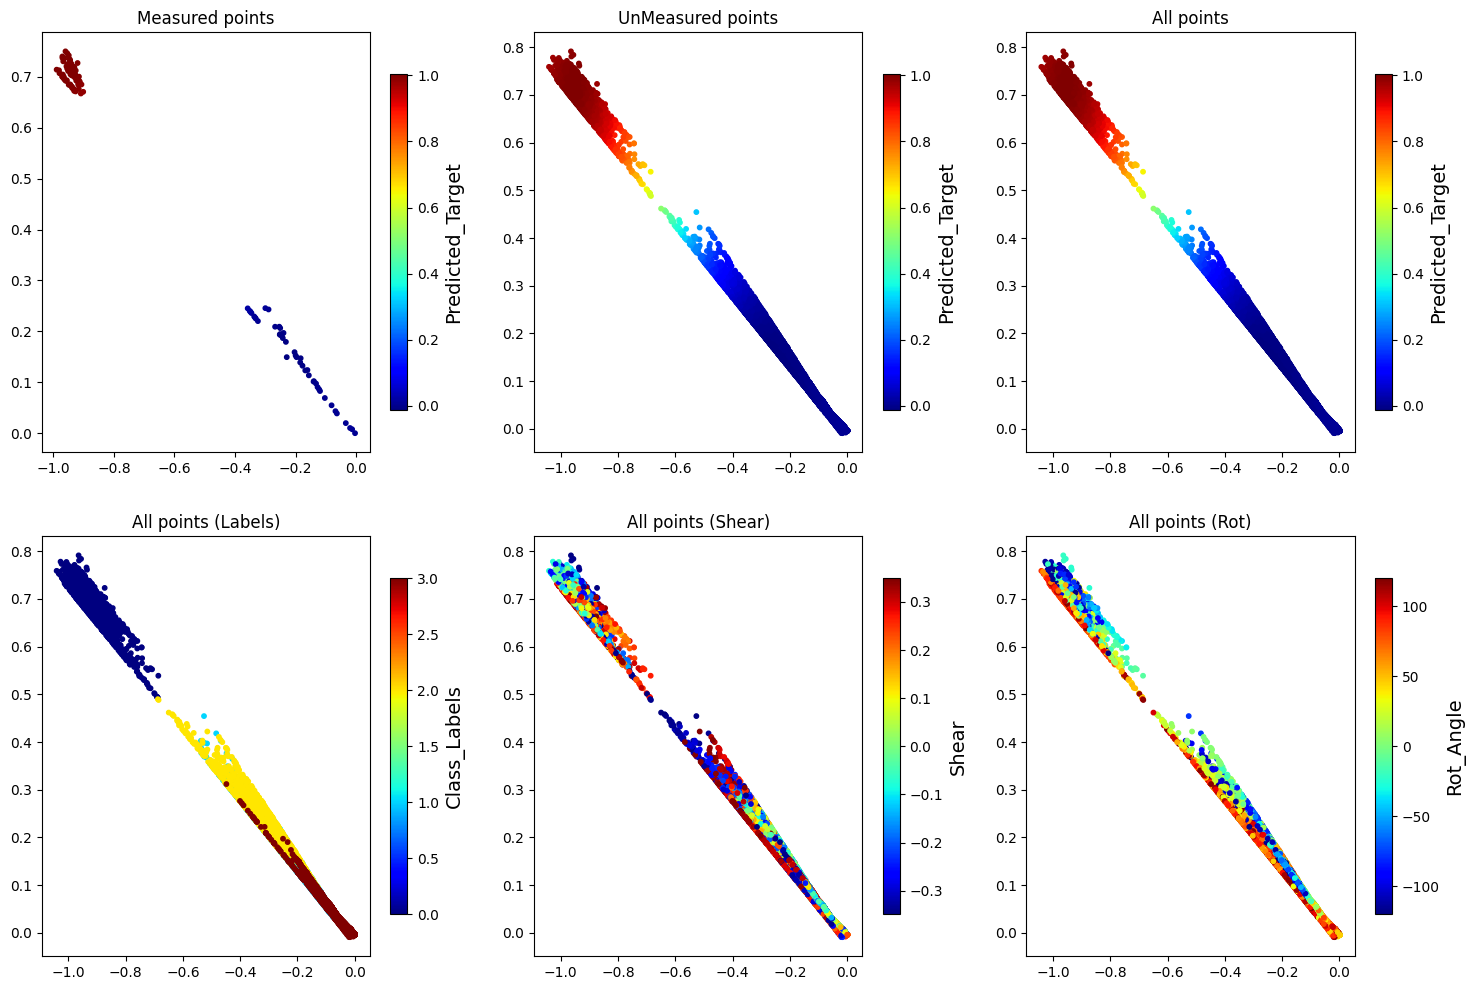

In [22]:
embeded_train0 = dkl_BO_0.embed(X0_train)  # Measured points
embeded_unmeasured0 = dkl_BO_0.embed(X0_unmeasured)  # Unmeasured points
embeded10 = dkl_BO_0.embed(X0)   # All points

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train0[:, 1], embeded_train0[:, 0], s=10, c = predmean_train0, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_unmeasured0[:, 1], embeded_unmeasured0[:, 0], s=10,
                c = predmean_unmeas0, cmap = 'jet')
ax[0,1].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded10[:, 1], embeded10[:, 0], s=10, c = predmean10, cmap = 'jet')
ax[0,2].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded10[:, 1], embeded10[:, 0], s=10, c = labels_all, cmap = 'jet')
ax[1,0].set_title('All points (Labels)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded10[:, 1], embeded10[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
ax[1,1].set_title('All points (Shear)')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded10[:, 1], embeded10[:, 0], s=10, c = angles_all, cmap = 'jet')
ax[1,2].set_title('All points (Rot)')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
cbar.set_label("Rot_Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Note that we discovered the right manifold with much smaller number of points. Now the "hand" is a continuous function (again, we use cards as a model for more complex processes, so we assume that it is an ordinal variable)

## Spades

Now, let's try the same analysis for spades.

In [23]:
X1 = np.copy(X)
targets1 = np.zeros(len(labels_all))
targets1[labels_all == 1] = 1

rng_key_1, rng_key_predict_1 = gpax.utils.get_keys()
dkl_1 = gpax.viDKL(900, 2, 'RBF')
dkl_1.fit(rng_key_1, X1, targets1)

100%|██████████| 1000/1000 [03:48<00:00,  4.38it/s, init loss: 69263.1582, avg. loss [951-1000]: 45786.9025]



Inferred GP kernel parameters
k_length         [3.9432 3.0629]
k_scale          0.1468
noise            0.0082


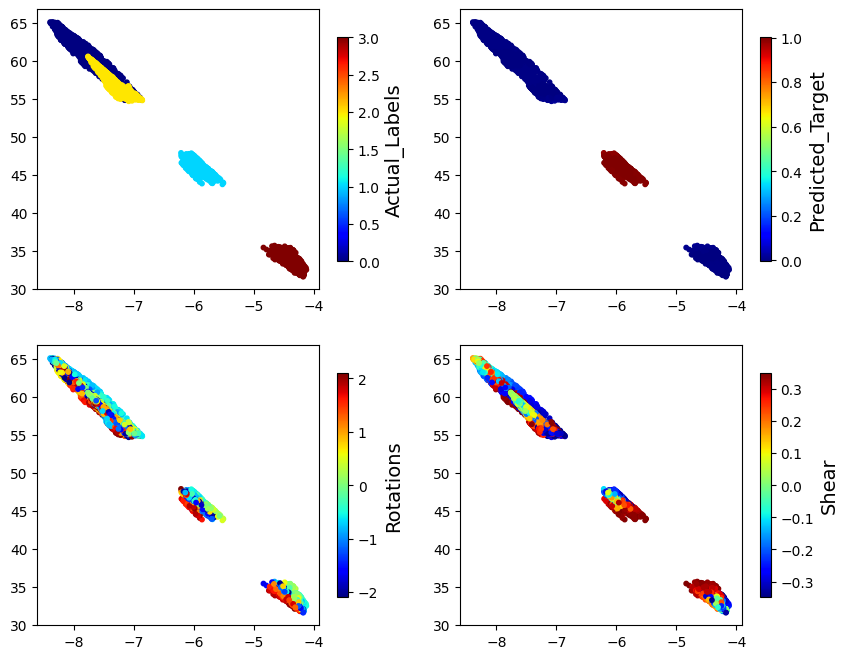

In [24]:
embeded_1 = dkl_1.embed(X1)
pred_mean1, pred_var1 = dkl_1.predict_in_batches(rng_key_predict_1, X1, batch_size=batch_size_reconstruct)
pred_std1 = jnp.sqrt(pred_var1)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = pred_mean1, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = torch.deg2rad(angles_all),
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Note that here our target is in the center of the DKL manifold. It will have interesting effect on the DKL active learning. Also interetsingly, you can see that rotations got disentangled within the DKL manifolds (and to some extent even shears). We would not see it if we did not have access to the full target set, but nice to know that DKL can also disentangle representations of the data!

In [25]:
np.random.seed(0)
idx1 = np.random.choice(np.arange(len(X1)), size = init_num, replace = False)
X1_train = X1[idx1]
X1_unmeasured = np.delete(X1, idx1, axis=0)

indices_total_1 = np.arange(len(X))
indices_train_1 = indices_total_1[idx1]
y1_train = targets1[idx1]
indices_unmeasured_1 = np.delete(indices_total_1, idx1)

In [26]:
exp_mean1, exp_std1 = [], []
dkl_mean1, dkl_std1 = [], []
embed_traj1 = []
traj_mean1, traj_std1 = [], []

exploration_steps = exploration_steps


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key11, rng_key_predict11 = gpax.utils.get_keys()
    dkl_BO_1 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_1.fit(rng_key11, X1_train, y1_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_1.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict11, X1_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()

    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean1.append(y_mean[id_next])
    exp_std1.append(y_std[id_next])

    x_next = X1_unmeasured[id_next]
    ind_next = indices_unmeasured_1[id_next]

    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean1.append(pred_mean1[ind_next])
    dkl_std1.append(pred_std1[ind_next])

    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = targets1[ind_next]

    # Update training arrays
    X1_train = np.append(X1_train, x_next[None], axis=0)
    y1_train = np.append(y1_train, y_measured)
    X1_unmeasured = np.delete(X1_unmeasured, id_next, axis=0)
    indices_unmeasured_1 = np.delete(indices_unmeasured_1, id_next)

    embed_traj = dkl_BO_1.embed(X1_train)
    traj_m, traj_s = dkl_BO_1.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict11, X1_train, batch_size=10)

    embed_traj1.append(embed_traj)
    traj_mean1.append(traj_m)


Step 1


100%|██████████| 1000/1000 [00:02<00:00, 491.01it/s, init loss: 60100.9329, avg. loss [951-1000]: 56954.1544]



Inferred GP kernel parameters
k_length         [0.5056 0.4595]
k_scale          0.256
noise            0.022000000000000002

Step 2


100%|██████████| 1000/1000 [00:02<00:00, 490.09it/s, init loss: 60102.1771, avg. loss [951-1000]: 56922.0648]



Inferred GP kernel parameters
k_length         [0.3672 0.3178]
k_scale          0.4031
noise            0.0129

Step 3


100%|██████████| 1000/1000 [00:02<00:00, 493.86it/s, init loss: 60103.4196, avg. loss [951-1000]: 56919.7613]



Inferred GP kernel parameters
k_length         [0.3679 0.3112]
k_scale          0.4293
noise            0.0123

Step 4


100%|██████████| 1000/1000 [00:02<00:00, 486.16it/s, init loss: 60104.9204, avg. loss [951-1000]: 56919.7856]



Inferred GP kernel parameters
k_length         [0.3666 0.3402]
k_scale          0.3995
noise            0.0125

Step 5


100%|██████████| 1000/1000 [00:02<00:00, 496.85it/s, init loss: 60106.1625, avg. loss [951-1000]: 56920.6759]



Inferred GP kernel parameters
k_length         [0.3605 0.3169]
k_scale          0.528
noise            0.0122

Step 6


100%|██████████| 1000/1000 [00:02<00:00, 494.83it/s, init loss: 60107.6527, avg. loss [951-1000]: 56933.9441]



Inferred GP kernel parameters
k_length         [0.3844 0.3401]
k_scale          0.3655
noise            0.0155

Step 7


100%|██████████| 1000/1000 [00:02<00:00, 488.38it/s, init loss: 60109.1579, avg. loss [951-1000]: 56918.0511]



Inferred GP kernel parameters
k_length         [0.3678 0.3069]
k_scale          0.5336000000000001
noise            0.011300000000000001

Step 8


100%|██████████| 1000/1000 [00:01<00:00, 508.58it/s, init loss: 60110.4021, avg. loss [951-1000]: 56928.7525]



Inferred GP kernel parameters
k_length         [0.387  0.3269]
k_scale          0.4531
noise            0.0132

Step 9


100%|██████████| 1000/1000 [00:02<00:00, 483.34it/s, init loss: 60111.6453, avg. loss [951-1000]: 56914.1427]



Inferred GP kernel parameters
k_length         [0.3679 0.3296]
k_scale          0.3894
noise            0.0119

Step 10


100%|██████████| 1000/1000 [00:02<00:00, 496.87it/s, init loss: 60113.1463, avg. loss [951-1000]: 56925.5793]



Inferred GP kernel parameters
k_length         [0.4118 0.4598]
k_scale          0.4531
noise            0.013800000000000002

Step 11


100%|██████████| 1000/1000 [00:01<00:00, 510.14it/s, init loss: 60114.3906, avg. loss [951-1000]: 56923.1529]



Inferred GP kernel parameters
k_length         [0.341  0.3679]
k_scale          0.4933
noise            0.012

Step 12


100%|██████████| 1000/1000 [00:01<00:00, 508.97it/s, init loss: 60115.6345, avg. loss [951-1000]: 56926.5110]



Inferred GP kernel parameters
k_length         [0.43   0.3605]
k_scale          0.3009
noise            0.0166

Step 13


100%|██████████| 1000/1000 [00:01<00:00, 503.37it/s, init loss: 60116.8788, avg. loss [951-1000]: 56914.2670]



Inferred GP kernel parameters
k_length         [0.362  0.3267]
k_scale          0.44060000000000005
noise            0.012400000000000001

Step 14


100%|██████████| 1000/1000 [00:02<00:00, 466.94it/s, init loss: 60118.1230, avg. loss [951-1000]: 56960.9196]



Inferred GP kernel parameters
k_length         [0.4254 0.2963]
k_scale          0.3024
noise            0.015700000000000002

Step 15


100%|██████████| 1000/1000 [00:02<00:00, 484.07it/s, init loss: 60119.5672, avg. loss [951-1000]: 56938.5013]



Inferred GP kernel parameters
k_length         [0.5722 0.3613]
k_scale          0.3221
noise            0.019

Step 16


100%|██████████| 1000/1000 [00:02<00:00, 488.52it/s, init loss: 60120.8114, avg. loss [951-1000]: 56915.9947]



Inferred GP kernel parameters
k_length         [0.4702 0.4313]
k_scale          0.45730000000000004
noise            0.0126

Step 17


100%|██████████| 1000/1000 [00:02<00:00, 476.30it/s, init loss: 60122.0556, avg. loss [951-1000]: 56902.2700]



Inferred GP kernel parameters
k_length         [0.3242 0.3614]
k_scale          0.3825
noise            0.0099

Step 18


100%|██████████| 1000/1000 [00:02<00:00, 477.27it/s, init loss: 60123.2999, avg. loss [951-1000]: 56925.5665]



Inferred GP kernel parameters
k_length         [0.3776 0.327 ]
k_scale          0.3824
noise            0.012

Step 19


100%|██████████| 1000/1000 [00:03<00:00, 285.45it/s, init loss: 60124.7844, avg. loss [951-1000]: 56919.8087]



Inferred GP kernel parameters
k_length         [0.4448 0.4044]
k_scale          0.4148
noise            0.013000000000000001

Step 20


100%|██████████| 1000/1000 [00:02<00:00, 471.66it/s, init loss: 60126.0287, avg. loss [951-1000]: 56937.5943]



Inferred GP kernel parameters
k_length         [0.3911 0.2495]
k_scale          0.378
noise            0.013300000000000001

Step 21


100%|██████████| 1000/1000 [00:02<00:00, 481.40it/s, init loss: 60127.5338, avg. loss [951-1000]: 57004.3527]



Inferred GP kernel parameters
k_length         [0.3107 0.2106]
k_scale          0.25930000000000003
noise            0.0241

Step 22


100%|██████████| 1000/1000 [00:02<00:00, 494.24it/s, init loss: 60129.0296, avg. loss [951-1000]: 56912.6943]



Inferred GP kernel parameters
k_length         [0.3678 0.3401]
k_scale          0.4303
noise            0.0131

Step 23


100%|██████████| 1000/1000 [00:02<00:00, 473.71it/s, init loss: 60130.2739, avg. loss [951-1000]: 56949.0767]



Inferred GP kernel parameters
k_length         [0.5879 0.6105]
k_scale          0.2975
noise            0.0235

Step 24


100%|██████████| 1000/1000 [00:02<00:00, 485.09it/s, init loss: 60131.4785, avg. loss [951-1000]: 56914.9268]



Inferred GP kernel parameters
k_length         [0.4834 0.4717]
k_scale          0.36000000000000004
noise            0.013300000000000001

Step 25


100%|██████████| 1000/1000 [00:02<00:00, 474.13it/s, init loss: 60132.7171, avg. loss [951-1000]: 56914.7234]



Inferred GP kernel parameters
k_length         [0.3487 0.384 ]
k_scale          0.39430000000000004
noise            0.012

Step 26


100%|██████████| 1000/1000 [00:02<00:00, 482.81it/s, init loss: 60134.2184, avg. loss [951-1000]: 56926.8971]



Inferred GP kernel parameters
k_length         [0.5801 0.4921]
k_scale          0.3123
noise            0.0179

Step 27


100%|██████████| 1000/1000 [00:02<00:00, 481.76it/s, init loss: 60135.4047, avg. loss [951-1000]: 56914.8818]



Inferred GP kernel parameters
k_length         [0.4991 0.54  ]
k_scale          0.34600000000000003
noise            0.0112

Step 28


100%|██████████| 1000/1000 [00:02<00:00, 476.72it/s, init loss: 60136.9098, avg. loss [951-1000]: 56916.3878]



Inferred GP kernel parameters
k_length         [0.4394 0.4412]
k_scale          0.31
noise            0.0177

Step 29


100%|██████████| 1000/1000 [00:02<00:00, 481.73it/s, init loss: 60138.1071, avg. loss [951-1000]: 56918.7595]



Inferred GP kernel parameters
k_length         [0.3218 0.3694]
k_scale          0.3477
noise            0.0126

Step 30


100%|██████████| 1000/1000 [00:02<00:00, 477.59it/s, init loss: 60139.3509, avg. loss [951-1000]: 56901.8520]



Inferred GP kernel parameters
k_length         [0.3895 0.4982]
k_scale          0.3753
noise            0.0131

Step 31


100%|██████████| 1000/1000 [00:02<00:00, 473.92it/s, init loss: 60140.5840, avg. loss [951-1000]: 56930.7013]



Inferred GP kernel parameters
k_length         [0.8561 0.7168]
k_scale          0.2826
noise            0.016900000000000002

Step 32


100%|██████████| 1000/1000 [00:02<00:00, 480.16it/s, init loss: 60141.8262, avg. loss [951-1000]: 56895.2167]



Inferred GP kernel parameters
k_length         [0.4778 0.4795]
k_scale          0.4677
noise            0.012

Step 33


100%|██████████| 1000/1000 [00:02<00:00, 479.56it/s, init loss: 60143.0692, avg. loss [951-1000]: 56927.0554]



Inferred GP kernel parameters
k_length         [0.3453 0.4769]
k_scale          0.3402
noise            0.019100000000000002

Step 34


100%|██████████| 1000/1000 [00:02<00:00, 467.48it/s, init loss: 60144.4068, avg. loss [951-1000]: 56944.2035]



Inferred GP kernel parameters
k_length         [0.4696 0.447 ]
k_scale          0.29650000000000004
noise            0.0162

Step 35


100%|██████████| 1000/1000 [00:02<00:00, 475.96it/s, init loss: 60145.6506, avg. loss [951-1000]: 56927.5069]



Inferred GP kernel parameters
k_length         [0.355  0.3637]
k_scale          0.41590000000000005
noise            0.011300000000000001

Step 36


100%|██████████| 1000/1000 [00:02<00:00, 478.64it/s, init loss: 60146.8312, avg. loss [951-1000]: 56960.9536]



Inferred GP kernel parameters
k_length         [0.6905 0.5489]
k_scale          0.24500000000000002
noise            0.015600000000000001

Step 37


100%|██████████| 1000/1000 [00:02<00:00, 478.46it/s, init loss: 60148.0693, avg. loss [951-1000]: 56987.3795]



Inferred GP kernel parameters
k_length         [0.5364 0.382 ]
k_scale          0.2083
noise            0.0233

Step 38


100%|██████████| 1000/1000 [00:02<00:00, 483.62it/s, init loss: 60149.3136, avg. loss [951-1000]: 56901.8026]



Inferred GP kernel parameters
k_length         [0.6099 0.5513]
k_scale          0.3128
noise            0.0154

Step 39


100%|██████████| 1000/1000 [00:02<00:00, 469.29it/s, init loss: 60150.5428, avg. loss [951-1000]: 56909.0695]



Inferred GP kernel parameters
k_length         [0.4959 0.4058]
k_scale          0.3945
noise            0.0114

Step 40


100%|██████████| 1000/1000 [00:02<00:00, 479.08it/s, init loss: 60151.7871, avg. loss [951-1000]: 56891.2736]



Inferred GP kernel parameters
k_length         [0.3807 0.417 ]
k_scale          0.3629
noise            0.0115

Step 41


100%|██████████| 1000/1000 [00:02<00:00, 482.98it/s, init loss: 60153.0312, avg. loss [951-1000]: 56879.2163]



Inferred GP kernel parameters
k_length         [0.5025 0.501 ]
k_scale          0.3947
noise            0.0102

Step 42


100%|██████████| 1000/1000 [00:02<00:00, 470.99it/s, init loss: 60154.2336, avg. loss [951-1000]: 56912.3190]



Inferred GP kernel parameters
k_length         [0.3488 0.433 ]
k_scale          0.3778
noise            0.012700000000000001

Step 43


100%|██████████| 1000/1000 [00:02<00:00, 473.64it/s, init loss: 60155.6781, avg. loss [951-1000]: 56918.9911]



Inferred GP kernel parameters
k_length         [0.4315 0.3977]
k_scale          0.3442
noise            0.0132

Step 44


100%|██████████| 1000/1000 [00:02<00:00, 475.68it/s, init loss: 60156.9143, avg. loss [951-1000]: 56906.4751]



Inferred GP kernel parameters
k_length         [0.421  0.3245]
k_scale          0.4116
noise            0.012700000000000001

Step 45


100%|██████████| 1000/1000 [00:02<00:00, 456.85it/s, init loss: 60158.1586, avg. loss [951-1000]: 56926.8926]



Inferred GP kernel parameters
k_length         [0.476  0.6167]
k_scale          0.3216
noise            0.0134

Step 46


100%|██████████| 1000/1000 [00:02<00:00, 472.90it/s, init loss: 60159.4029, avg. loss [951-1000]: 56901.1043]



Inferred GP kernel parameters
k_length         [0.5719 0.8939]
k_scale          0.3255
noise            0.013900000000000001

Step 47


100%|██████████| 1000/1000 [00:02<00:00, 463.95it/s, init loss: 60160.6155, avg. loss [951-1000]: 56894.5292]



Inferred GP kernel parameters
k_length         [0.4078 0.4482]
k_scale          0.42850000000000005
noise            0.0143

Step 48


100%|██████████| 1000/1000 [00:02<00:00, 458.90it/s, init loss: 60161.7593, avg. loss [951-1000]: 56913.3456]



Inferred GP kernel parameters
k_length         [0.5099 0.5288]
k_scale          0.3453
noise            0.0151

Step 49


100%|██████████| 1000/1000 [00:02<00:00, 474.89it/s, init loss: 60163.2586, avg. loss [951-1000]: 56927.0084]



Inferred GP kernel parameters
k_length         [0.2871 0.2558]
k_scale          0.3113
noise            0.011000000000000001

Step 50


100%|██████████| 1000/1000 [00:02<00:00, 462.69it/s, init loss: 60164.5023, avg. loss [951-1000]: 56886.9934]



Inferred GP kernel parameters
k_length         [0.4924 0.415 ]
k_scale          0.4136
noise            0.012

Step 51


100%|██████████| 1000/1000 [00:02<00:00, 456.94it/s, init loss: 60165.7466, avg. loss [951-1000]: 56863.3578]



Inferred GP kernel parameters
k_length         [0.4745 0.3633]
k_scale          0.44220000000000004
noise            0.009600000000000001

Step 52


100%|██████████| 1000/1000 [00:02<00:00, 464.37it/s, init loss: 60167.1092, avg. loss [951-1000]: 56883.7242]



Inferred GP kernel parameters
k_length         [0.5263 0.5378]
k_scale          0.3825
noise            0.0118

Step 53


100%|██████████| 1000/1000 [00:02<00:00, 464.21it/s, init loss: 60168.3441, avg. loss [951-1000]: 56951.7247]



Inferred GP kernel parameters
k_length         [0.6403 0.5168]
k_scale          0.28090000000000004
noise            0.0175

Step 54


100%|██████████| 1000/1000 [00:02<00:00, 461.11it/s, init loss: 60169.5884, avg. loss [951-1000]: 56874.1558]



Inferred GP kernel parameters
k_length         [0.717  0.5123]
k_scale          0.35350000000000004
noise            0.012

Step 55


100%|██████████| 1000/1000 [00:02<00:00, 468.79it/s, init loss: 60170.8174, avg. loss [951-1000]: 56861.4699]



Inferred GP kernel parameters
k_length         [0.3757 0.5677]
k_scale          0.43860000000000005
noise            0.01

Step 56


100%|██████████| 1000/1000 [00:02<00:00, 468.96it/s, init loss: 60172.0606, avg. loss [951-1000]: 56882.4213]



Inferred GP kernel parameters
k_length         [0.4967 0.4789]
k_scale          0.34490000000000004
noise            0.012700000000000001

Step 57


100%|██████████| 1000/1000 [00:02<00:00, 478.57it/s, init loss: 60173.5497, avg. loss [951-1000]: 56954.6980]



Inferred GP kernel parameters
k_length         [0.6454 0.6674]
k_scale          0.24130000000000001
noise            0.0126

Step 58


100%|██████████| 1000/1000 [00:02<00:00, 480.25it/s, init loss: 60174.7934, avg. loss [951-1000]: 56915.1803]



Inferred GP kernel parameters
k_length         [0.3712 0.4599]
k_scale          0.3446
noise            0.0129

Step 59


100%|██████████| 1000/1000 [00:02<00:00, 478.47it/s, init loss: 60176.0377, avg. loss [951-1000]: 56928.0758]



Inferred GP kernel parameters
k_length         [0.7385 0.7887]
k_scale          0.2576
noise            0.0132

Step 60


100%|██████████| 1000/1000 [00:02<00:00, 467.16it/s, init loss: 60177.2819, avg. loss [951-1000]: 56885.8032]



Inferred GP kernel parameters
k_length         [0.4446 0.4945]
k_scale          0.38930000000000003
noise            0.011600000000000001

Step 61


100%|██████████| 1000/1000 [00:02<00:00, 468.50it/s, init loss: 60178.5196, avg. loss [951-1000]: 56855.2037]



Inferred GP kernel parameters
k_length         [0.5028 0.5431]
k_scale          0.4167
noise            0.01

Step 62


100%|██████████| 1000/1000 [00:02<00:00, 466.10it/s, init loss: 60179.9297, avg. loss [951-1000]: 56855.0571]



Inferred GP kernel parameters
k_length         [0.5012 0.5945]
k_scale          0.3493
noise            0.009600000000000001

Step 63


100%|██████████| 1000/1000 [00:02<00:00, 463.70it/s, init loss: 60181.1047, avg. loss [951-1000]: 56840.5962]



Inferred GP kernel parameters
k_length         [0.3682 0.3987]
k_scale          0.4142
noise            0.009300000000000001

Step 64


100%|██████████| 1000/1000 [00:02<00:00, 464.29it/s, init loss: 60182.6098, avg. loss [951-1000]: 56867.7854]



Inferred GP kernel parameters
k_length         [0.7431 0.6329]
k_scale          0.3257
noise            0.0106

Step 65


100%|██████████| 1000/1000 [00:02<00:00, 475.63it/s, init loss: 60184.1150, avg. loss [951-1000]: 56855.9208]



Inferred GP kernel parameters
k_length         [0.786 0.611]
k_scale          0.35900000000000004
noise            0.0111

Step 66


100%|██████████| 1000/1000 [00:03<00:00, 275.10it/s, init loss: 60185.3377, avg. loss [951-1000]: 56930.3763]



Inferred GP kernel parameters
k_length         [0.6297 0.5472]
k_scale          0.3362
noise            0.0112

Step 67


100%|██████████| 1000/1000 [00:02<00:00, 464.58it/s, init loss: 60186.8318, avg. loss [951-1000]: 56882.2865]



Inferred GP kernel parameters
k_length         [0.6471 0.5812]
k_scale          0.3144
noise            0.0115

Step 68


100%|██████████| 1000/1000 [00:02<00:00, 473.74it/s, init loss: 60188.0761, avg. loss [951-1000]: 56836.4942]



Inferred GP kernel parameters
k_length         [0.5006 0.4678]
k_scale          0.3835
noise            0.0095

Step 69


100%|██████████| 1000/1000 [00:02<00:00, 475.58it/s, init loss: 60189.2632, avg. loss [951-1000]: 56841.4288]



Inferred GP kernel parameters
k_length         [0.5799 0.4186]
k_scale          0.41850000000000004
noise            0.0097

Step 70


100%|██████████| 1000/1000 [00:02<00:00, 475.24it/s, init loss: 60190.4951, avg. loss [951-1000]: 56942.4641]



Inferred GP kernel parameters
k_length         [0.4638 0.6118]
k_scale          0.23570000000000002
noise            0.0221

Step 71


100%|██████████| 1000/1000 [00:02<00:00, 460.54it/s, init loss: 60191.9858, avg. loss [951-1000]: 56881.0540]



Inferred GP kernel parameters
k_length         [0.4237 0.425 ]
k_scale          0.3543
noise            0.010700000000000001

Step 72


100%|██████████| 1000/1000 [00:02<00:00, 472.84it/s, init loss: 60193.4909, avg. loss [951-1000]: 56916.7317]



Inferred GP kernel parameters
k_length         [0.5139 0.4724]
k_scale          0.29460000000000003
noise            0.0171

Step 73


100%|██████████| 1000/1000 [00:02<00:00, 476.37it/s, init loss: 60194.9871, avg. loss [951-1000]: 56870.4481]



Inferred GP kernel parameters
k_length         [0.544  0.4555]
k_scale          0.2942
noise            0.0126

Step 74


100%|██████████| 1000/1000 [00:02<00:00, 465.66it/s, init loss: 60196.1949, avg. loss [951-1000]: 56852.6107]



Inferred GP kernel parameters
k_length         [0.8628 0.5059]
k_scale          0.3844
noise            0.0118

Step 75


100%|██████████| 1000/1000 [00:02<00:00, 471.92it/s, init loss: 60197.3801, avg. loss [951-1000]: 56883.6417]



Inferred GP kernel parameters
k_length         [0.5088 0.5682]
k_scale          0.3593
noise            0.0134

Step 76


100%|██████████| 1000/1000 [00:02<00:00, 474.08it/s, init loss: 60198.6099, avg. loss [951-1000]: 56874.8539]



Inferred GP kernel parameters
k_length         [0.7281 0.6937]
k_scale          0.3201
noise            0.0125

Step 77


100%|██████████| 1000/1000 [00:02<00:00, 462.72it/s, init loss: 60199.9183, avg. loss [951-1000]: 56851.2883]



Inferred GP kernel parameters
k_length         [0.6469 0.5443]
k_scale          0.3305
noise            0.0112

Step 78


100%|██████████| 1000/1000 [00:02<00:00, 465.38it/s, init loss: 60201.2215, avg. loss [951-1000]: 56875.5184]



Inferred GP kernel parameters
k_length         [0.7799 0.6829]
k_scale          0.3905
noise            0.011600000000000001

Step 79


100%|██████████| 1000/1000 [00:02<00:00, 468.71it/s, init loss: 60202.4616, avg. loss [951-1000]: 57017.1064]



Inferred GP kernel parameters
k_length         [0.4785 0.4293]
k_scale          0.2104
noise            0.012400000000000001

Step 80


100%|██████████| 1000/1000 [00:02<00:00, 459.57it/s, init loss: 60203.9323, avg. loss [951-1000]: 56869.3598]



Inferred GP kernel parameters
k_length         [0.6732 0.736 ]
k_scale          0.32680000000000003
noise            0.0103

Step 81


100%|██████████| 1000/1000 [00:02<00:00, 462.11it/s, init loss: 60205.1278, avg. loss [951-1000]: 56841.8888]



Inferred GP kernel parameters
k_length         [0.6146 0.8665]
k_scale          0.3805
noise            0.0106

Step 82


100%|██████████| 1000/1000 [00:02<00:00, 464.50it/s, init loss: 60206.3671, avg. loss [951-1000]: 56924.1946]



Inferred GP kernel parameters
k_length         [0.6019 0.6413]
k_scale          0.2726
noise            0.0128

Step 83


100%|██████████| 1000/1000 [00:02<00:00, 458.01it/s, init loss: 60207.5780, avg. loss [951-1000]: 56886.9986]



Inferred GP kernel parameters
k_length         [0.4748 0.4822]
k_scale          0.2852
noise            0.012700000000000001

Step 84


100%|██████████| 1000/1000 [00:02<00:00, 459.11it/s, init loss: 60208.8185, avg. loss [951-1000]: 56918.9050]



Inferred GP kernel parameters
k_length         [0.3509 0.3957]
k_scale          0.3246
noise            0.0162

Step 85


100%|██████████| 1000/1000 [00:02<00:00, 471.01it/s, init loss: 60210.0474, avg. loss [951-1000]: 56819.1856]



Inferred GP kernel parameters
k_length         [0.428  0.4614]
k_scale          0.3529
noise            0.01

Step 86


100%|██████████| 1000/1000 [00:02<00:00, 458.66it/s, init loss: 60211.5467, avg. loss [951-1000]: 56876.9129]



Inferred GP kernel parameters
k_length         [0.4627 0.5871]
k_scale          0.3714
noise            0.0115

Step 87


100%|██████████| 1000/1000 [00:02<00:00, 468.07it/s, init loss: 60212.7390, avg. loss [951-1000]: 56850.0747]



Inferred GP kernel parameters
k_length         [0.8299 0.7115]
k_scale          0.2684
noise            0.011000000000000001

Step 88


100%|██████████| 1000/1000 [00:02<00:00, 473.26it/s, init loss: 60214.2440, avg. loss [951-1000]: 56900.7108]



Inferred GP kernel parameters
k_length         [0.6182 0.5638]
k_scale          0.3272
noise            0.0112

Step 89


100%|██████████| 1000/1000 [00:02<00:00, 467.81it/s, init loss: 60215.7422, avg. loss [951-1000]: 56857.6339]



Inferred GP kernel parameters
k_length         [0.4549 0.5347]
k_scale          0.2674
noise            0.013300000000000001

Step 90


100%|██████████| 1000/1000 [00:03<00:00, 272.92it/s, init loss: 60217.2238, avg. loss [951-1000]: 56871.5805]



Inferred GP kernel parameters
k_length         [1.2043 0.9177]
k_scale          0.30460000000000004
noise            0.012400000000000001

Step 91


100%|██████████| 1000/1000 [00:02<00:00, 475.06it/s, init loss: 60218.7283, avg. loss [951-1000]: 57089.5823]



Inferred GP kernel parameters
k_length         [0.3808 0.2625]
k_scale          0.2793
noise            0.0181

Step 92


100%|██████████| 1000/1000 [00:02<00:00, 466.12it/s, init loss: 60220.2335, avg. loss [951-1000]: 56907.1788]



Inferred GP kernel parameters
k_length         [0.5838 0.5619]
k_scale          0.25630000000000003
noise            0.0159

Step 93


100%|██████████| 1000/1000 [00:02<00:00, 472.09it/s, init loss: 60221.4394, avg. loss [951-1000]: 56986.5767]



Inferred GP kernel parameters
k_length         [0.6196 0.7638]
k_scale          0.23
noise            0.0125

Step 94


100%|██████████| 1000/1000 [00:02<00:00, 465.53it/s, init loss: 60222.6837, avg. loss [951-1000]: 56884.3410]



Inferred GP kernel parameters
k_length         [0.4981 0.5374]
k_scale          0.316
noise            0.010700000000000001

Step 95


100%|██████████| 1000/1000 [00:02<00:00, 465.27it/s, init loss: 60224.1683, avg. loss [951-1000]: 56810.1513]



Inferred GP kernel parameters
k_length         [0.7991 0.6684]
k_scale          0.4006
noise            0.0098

Step 96


100%|██████████| 1000/1000 [00:02<00:00, 472.88it/s, init loss: 60225.6530, avg. loss [951-1000]: 56915.5497]



Inferred GP kernel parameters
k_length         [0.4395 0.514 ]
k_scale          0.3007
noise            0.014700000000000001

Step 97


100%|██████████| 1000/1000 [00:02<00:00, 462.19it/s, init loss: 60227.1369, avg. loss [951-1000]: 56888.8229]



Inferred GP kernel parameters
k_length         [0.6543 0.6042]
k_scale          0.3533
noise            0.0135

Step 98


100%|██████████| 1000/1000 [00:02<00:00, 465.04it/s, init loss: 60228.6105, avg. loss [951-1000]: 56945.0189]



Inferred GP kernel parameters
k_length         [0.6169 0.4298]
k_scale          0.2654
noise            0.0122

Step 99


100%|██████████| 1000/1000 [00:02<00:00, 469.11it/s, init loss: 60230.0717, avg. loss [951-1000]: 56914.3258]



Inferred GP kernel parameters
k_length         [1.0466 0.6302]
k_scale          0.2614
noise            0.0128

Step 100


100%|██████████| 1000/1000 [00:02<00:00, 472.01it/s, init loss: 60231.3159, avg. loss [951-1000]: 56807.0520]



Inferred GP kernel parameters
k_length         [0.602  0.5555]
k_scale          0.38870000000000005
noise            0.010700000000000001


In [27]:
spades_results = {}
spades_results['X_train'] = X1_train
spades_results['y_train'] = y1_train
spades_results['X_unmeasured'] = X1_unmeasured
spades_results['indices_unmeasured'] = indices_unmeasured_1
spades_results['dkl_mean'] = dkl_mean1
spades_results['dkl_std'] = dkl_std1
spades_results['exp_mean'] = exp_mean1
spades_results['exp_std'] = exp_std1
spades_results['traj_mean'] = traj_mean1
spades_results['traj_std'] = traj_std1
spades_results['embed_traj'] = embed_traj1

with open('spades_results.pickle', 'wb') as handle:
    pickle.dump(spades_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
with open('spades_results.pickle', 'rb') as f:
    spades_results = pickle.load(f)

X1_train = spades_results['X_train']
y1_train = spades_results['y_train']
X1_unmeasured = spades_results['X_unmeasured']
indices_unmeasured_1 = spades_results['indices_unmeasured']
dkl_mean1 = spades_results['dkl_mean']
dkl_std1 = spades_results['dkl_std']
exp_mean1 = spades_results['exp_mean']
exp_std1 = spades_results['exp_std']
traj_mean1 = spades_results['traj_mean']
traj_std1 = spades_results['traj_std']
embed_traj1 = spades_results['embed_traj']

In [29]:
rng_key11, rng_key_predict11 = gpax.utils.get_keys()
dkl_BO_1 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_1.fit(rng_key11, X1_train, y1_train)

predmean_train1, predstd_train1 = dkl_BO_1.predict_in_batches(rng_key_predict11, X1_train, batch_size=batch_size_learn)
predmean_unmeas1, predstd_unmeas1 = dkl_BO_1.predict_in_batches(rng_key_predict11, X1_unmeasured, batch_size=batch_size_reconstruct)
predmean11, predstd11 = dkl_BO_1.predict_in_batches(rng_key_predict11, X1, batch_size=batch_size_reconstruct)

100%|██████████| 1000/1000 [00:02<00:00, 468.10it/s, init loss: 60232.5179, avg. loss [951-1000]: 56811.9079]



Inferred GP kernel parameters
k_length         [0.7685 0.7224]
k_scale          0.3709
noise            0.0097


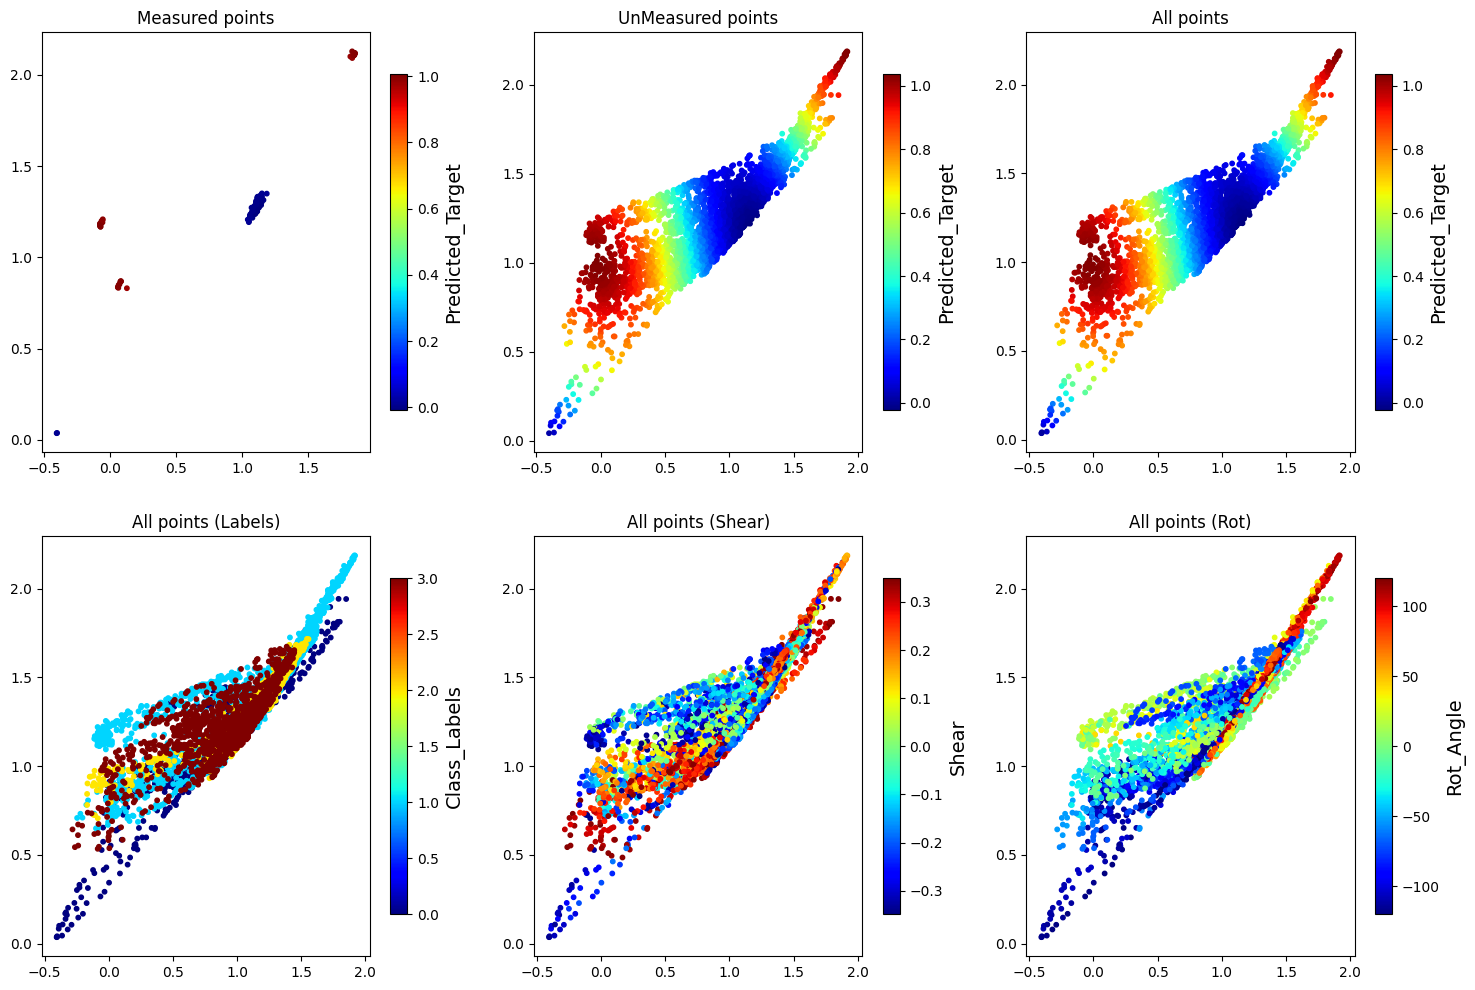

In [30]:
embeded_train1 = dkl_BO_1.embed(X1_train)  # Measured points
embeded_unmeasured1 = dkl_BO_1.embed(X1_unmeasured)  # Unmeasured points
embeded11 = dkl_BO_1.embed(X1)   # All points

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train1[:, 1], embeded_train1[:, 0], s=10, c = predmean_train1, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_unmeasured1[:, 1], embeded_unmeasured1[:, 0], s=10,
                c = predmean_unmeas1, cmap = 'jet')
ax[0,1].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded11[:, 1], embeded11[:, 0], s=10, c = predmean11, cmap = 'jet')
ax[0,2].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded11[:, 1], embeded11[:, 0], s=10, c = labels_all, cmap = 'jet')
ax[1,0].set_title('All points (Labels)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded11[:, 1], embeded11[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
ax[1,1].set_title('All points (Shear)')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded11[:, 1], embeded11[:, 0], s=10, c = angles_all, cmap = 'jet')
ax[1,2].set_title('All points (Rot)')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
cbar.set_label("Rot_Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Here, we observe a very interetsing effect where due to initial misalignment between the points the target function ended up being in different parts of the latent space. the DKL still managed to construct a much smoother manifold then the VAE - but now we have 4 maxima for "spadedness". No surprise - they look very similar to hearts.

Generally, giving more seed points will avoid this problem.

## Hearts

And now hearts

In [31]:
X2 = np.copy(X)
targets2 = np.zeros(len(labels_all))
targets2[labels_all == 2] = 1

rng_key_2, rng_key_predict_2 = gpax.utils.get_keys()
dkl_2 = gpax.viDKL(900, 2, 'RBF')
dkl_2.fit(rng_key_2, X2, targets2)

100%|██████████| 1000/1000 [03:48<00:00,  4.38it/s, init loss: 69255.3770, avg. loss [951-1000]: 45637.0947]



Inferred GP kernel parameters
k_length         [3.1584 2.3744]
k_scale          0.2437
noise            0.0081


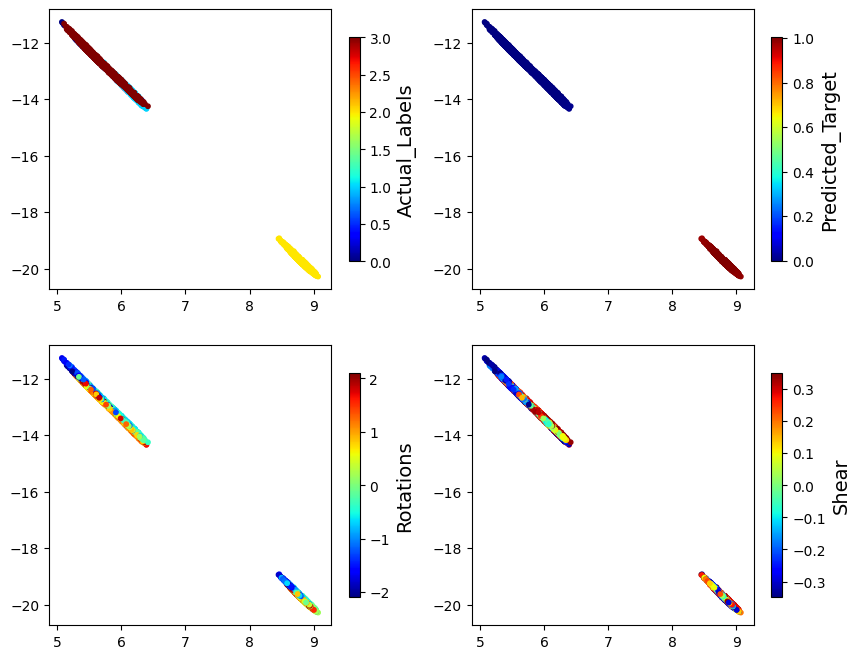

In [32]:
embeded_2 = dkl_2.embed(X2)
pred_mean2, pred_var2 = dkl_2.predict_in_batches(rng_key_predict_2, X2, batch_size=batch_size_reconstruct)
pred_std2 = jnp.sqrt(pred_var2)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_2[:, 1], embeded_2[:, 0], s=10, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_2[:, 1], embeded_2[:, 0], s=10, c = pred_mean2, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_2[:, 1], embeded_2[:, 0], s=10, c = torch.deg2rad(angles_all),
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_2[:, 1], embeded_2[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

For hearts, the system behavior is even more interesting. Here the target manifold is fairly complex - and resembles the VAE. Still much simpler then vanilla VAE. Again, note the disentanglement of rotations - which is now global. Generally, by now you have noticed is the better the discovery of the target functionality, the worse is the disentanglement of remaining variables.

In [33]:
np.random.seed(0)
idx2 = np.random.choice(np.arange(len(X2)), size = init_num, replace = False)
X2_train = X2[idx2]
X2_unmeasured = np.delete(X2, idx2, axis=0)

indices_total_2 = np.arange(len(X))
indices_train_2 = indices_total_2[idx2]
y2_train = targets2[idx2]
indices_unmeasured_2 = np.delete(indices_total_2, idx2)

In [34]:
exp_mean2, exp_std2 = [], []
dkl_mean2, dkl_std2 = [], []
embed_traj2 = []
traj_mean2, traj_std2 = [], []

exploration_steps = exploration_steps


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key12, rng_key_predict12 = gpax.utils.get_keys(seed = 15)
    dkl_BO_2 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_2.fit(rng_key12, X2_train, y2_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_2.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict12, X2_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()

    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean2.append(y_mean[id_next])
    exp_std2.append(y_std[id_next])

    x_next = X2_unmeasured[id_next]
    ind_next = indices_unmeasured_2[id_next]

    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean2.append(pred_mean2[ind_next])
    dkl_std2.append(pred_std2[ind_next])

    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = targets2[ind_next]

    # Update training arrays
    X2_train = np.append(X2_train, x_next[None], axis=0)
    y2_train = np.append(y2_train, y_measured)
    X2_unmeasured = np.delete(X2_unmeasured, id_next, axis=0)
    indices_unmeasured_2 = np.delete(indices_unmeasured_2, id_next)

    embed_traj = dkl_BO_2.embed(X2_train)
    traj_m, traj_s = dkl_BO_2.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict12, X2_train, batch_size=batch_size_learn)

    embed_traj2.append(embed_traj)
    traj_mean2.append(traj_m)


Step 1


100%|██████████| 1000/1000 [00:02<00:00, 489.79it/s, init loss: 60126.3976, avg. loss [951-1000]: 56927.1127]



Inferred GP kernel parameters
k_length         [0.3679 0.2985]
k_scale          0.44520000000000004
noise            0.0102

Step 2


100%|██████████| 1000/1000 [00:02<00:00, 484.12it/s, init loss: 60127.9287, avg. loss [951-1000]: 56962.7224]



Inferred GP kernel parameters
k_length         [0.2771 0.3613]
k_scale          0.36260000000000003
noise            0.019700000000000002

Step 3


100%|██████████| 1000/1000 [00:02<00:00, 471.51it/s, init loss: 60129.2239, avg. loss [951-1000]: 56950.6309]



Inferred GP kernel parameters
k_length         [0.5185 0.378 ]
k_scale          0.29910000000000003
noise            0.0149

Step 4


100%|██████████| 1000/1000 [00:02<00:00, 493.06it/s, init loss: 60130.4238, avg. loss [951-1000]: 56938.3849]



Inferred GP kernel parameters
k_length         [0.3719 0.3906]
k_scale          0.3556
noise            0.0172

Step 5


100%|██████████| 1000/1000 [00:01<00:00, 500.19it/s, init loss: 60131.7190, avg. loss [951-1000]: 56968.8061]



Inferred GP kernel parameters
k_length         [0.4521 0.3125]
k_scale          0.3064
noise            0.0241

Step 6


100%|██████████| 1000/1000 [00:01<00:00, 501.20it/s, init loss: 60133.1601, avg. loss [951-1000]: 56927.9147]



Inferred GP kernel parameters
k_length         [0.4157 0.4367]
k_scale          0.46590000000000004
noise            0.0108

Step 7


100%|██████████| 1000/1000 [00:02<00:00, 480.83it/s, init loss: 60134.4554, avg. loss [951-1000]: 56928.7621]



Inferred GP kernel parameters
k_length         [0.3864 0.3868]
k_scale          0.4053
noise            0.01

Step 8


100%|██████████| 1000/1000 [00:02<00:00, 485.45it/s, init loss: 60135.6932, avg. loss [951-1000]: 56942.0109]



Inferred GP kernel parameters
k_length         [0.475  0.4436]
k_scale          0.2926
noise            0.013300000000000001

Step 9


100%|██████████| 1000/1000 [00:03<00:00, 271.80it/s, init loss: 60137.0176, avg. loss [951-1000]: 56922.8494]



Inferred GP kernel parameters
k_length         [0.4253 0.3843]
k_scale          0.395
noise            0.013300000000000001

Step 10


100%|██████████| 1000/1000 [00:02<00:00, 489.75it/s, init loss: 60138.3099, avg. loss [951-1000]: 56957.6959]



Inferred GP kernel parameters
k_length         [0.3803 0.3626]
k_scale          0.3285
noise            0.020300000000000002

Step 11


100%|██████████| 1000/1000 [00:02<00:00, 477.49it/s, init loss: 60139.8407, avg. loss [951-1000]: 57002.9408]



Inferred GP kernel parameters
k_length         [0.409  0.2429]
k_scale          0.35660000000000003
noise            0.013600000000000001

Step 12


100%|██████████| 1000/1000 [00:02<00:00, 485.02it/s, init loss: 60141.1767, avg. loss [951-1000]: 56907.9133]



Inferred GP kernel parameters
k_length         [0.3943 0.3685]
k_scale          0.3271
noise            0.007500000000000001

Step 13


100%|██████████| 1000/1000 [00:02<00:00, 494.88it/s, init loss: 60142.4719, avg. loss [951-1000]: 56916.2855]



Inferred GP kernel parameters
k_length         [0.4746 0.3888]
k_scale          0.3753
noise            0.0097

Step 14


100%|██████████| 1000/1000 [00:02<00:00, 479.62it/s, init loss: 60143.7670, avg. loss [951-1000]: 56942.3140]



Inferred GP kernel parameters
k_length         [0.499  0.4355]
k_scale          0.33680000000000004
noise            0.01

Step 15


100%|██████████| 1000/1000 [00:02<00:00, 481.39it/s, init loss: 60145.0618, avg. loss [951-1000]: 56910.4811]



Inferred GP kernel parameters
k_length         [0.4913 0.3764]
k_scale          0.4046
noise            0.0083

Step 16


100%|██████████| 1000/1000 [00:02<00:00, 480.87it/s, init loss: 60146.3569, avg. loss [951-1000]: 56919.8129]



Inferred GP kernel parameters
k_length         [0.3316 0.3092]
k_scale          0.4706
noise            0.0085

Step 17


100%|██████████| 1000/1000 [00:02<00:00, 472.62it/s, init loss: 60147.6469, avg. loss [951-1000]: 56895.0083]



Inferred GP kernel parameters
k_length         [0.3672 0.3262]
k_scale          0.42150000000000004
noise            0.0058000000000000005

Step 18


100%|██████████| 1000/1000 [00:02<00:00, 467.36it/s, init loss: 60148.9422, avg. loss [951-1000]: 56908.2379]



Inferred GP kernel parameters
k_length         [0.3906 0.3581]
k_scale          0.31020000000000003
noise            0.0088

Step 19


100%|██████████| 1000/1000 [00:02<00:00, 467.12it/s, init loss: 60150.4664, avg. loss [951-1000]: 56894.7089]



Inferred GP kernel parameters
k_length         [0.433  0.4252]
k_scale          0.3808
noise            0.006900000000000001

Step 20


100%|██████████| 1000/1000 [00:02<00:00, 472.50it/s, init loss: 60151.7616, avg. loss [951-1000]: 56900.2580]



Inferred GP kernel parameters
k_length         [0.2605 0.3048]
k_scale          0.37
noise            0.006500000000000001

Step 21


100%|██████████| 1000/1000 [00:02<00:00, 482.45it/s, init loss: 60153.2914, avg. loss [951-1000]: 56892.1122]



Inferred GP kernel parameters
k_length         [0.381  0.3677]
k_scale          0.3664
noise            0.0063

Step 22


100%|██████████| 1000/1000 [00:02<00:00, 469.55it/s, init loss: 60154.5866, avg. loss [951-1000]: 56896.6247]



Inferred GP kernel parameters
k_length         [0.3709 0.3816]
k_scale          0.3257
noise            0.0076

Step 23


100%|██████████| 1000/1000 [00:02<00:00, 476.28it/s, init loss: 60156.1174, avg. loss [951-1000]: 56927.1155]



Inferred GP kernel parameters
k_length         [0.5546 0.4896]
k_scale          0.315
noise            0.0122

Step 24


100%|██████████| 1000/1000 [00:02<00:00, 470.29it/s, init loss: 60157.4115, avg. loss [951-1000]: 56908.7711]



Inferred GP kernel parameters
k_length         [0.6745 0.507 ]
k_scale          0.316
noise            0.0112

Step 25


100%|██████████| 1000/1000 [00:02<00:00, 469.50it/s, init loss: 60158.6186, avg. loss [951-1000]: 56889.0901]



Inferred GP kernel parameters
k_length         [0.3249 0.4537]
k_scale          0.499
noise            0.0066

Step 26


100%|██████████| 1000/1000 [00:02<00:00, 483.89it/s, init loss: 60160.1490, avg. loss [951-1000]: 56969.2356]



Inferred GP kernel parameters
k_length         [0.3414 0.3375]
k_scale          0.27190000000000003
noise            0.0123

Step 27


100%|██████████| 1000/1000 [00:02<00:00, 480.07it/s, init loss: 60161.4425, avg. loss [951-1000]: 56894.6311]



Inferred GP kernel parameters
k_length         [0.4654 0.396 ]
k_scale          0.3261
noise            0.0071

Step 28


100%|██████████| 1000/1000 [00:02<00:00, 475.62it/s, init loss: 60162.7510, avg. loss [951-1000]: 56884.5538]



Inferred GP kernel parameters
k_length         [0.3669 0.4018]
k_scale          0.3195
noise            0.0066

Step 29


100%|██████████| 1000/1000 [00:02<00:00, 478.09it/s, init loss: 60164.0462, avg. loss [951-1000]: 56877.8550]



Inferred GP kernel parameters
k_length         [0.3696 0.3444]
k_scale          0.4208
noise            0.006

Step 30


100%|██████████| 1000/1000 [00:02<00:00, 478.09it/s, init loss: 60165.5784, avg. loss [951-1000]: 56995.2291]



Inferred GP kernel parameters
k_length         [0.41  0.395]
k_scale          0.2747
noise            0.007500000000000001

Step 31


100%|██████████| 1000/1000 [00:02<00:00, 471.41it/s, init loss: 60166.8736, avg. loss [951-1000]: 56890.8129]



Inferred GP kernel parameters
k_length         [0.6017 0.4957]
k_scale          0.318
noise            0.0079

Step 32


100%|██████████| 1000/1000 [00:02<00:00, 472.26it/s, init loss: 60168.1442, avg. loss [951-1000]: 56874.6238]



Inferred GP kernel parameters
k_length         [0.3637 0.3488]
k_scale          0.3672
noise            0.0063

Step 33


100%|██████████| 1000/1000 [00:02<00:00, 467.96it/s, init loss: 60169.6521, avg. loss [951-1000]: 56885.9169]



Inferred GP kernel parameters
k_length         [0.5501 0.5965]
k_scale          0.27390000000000003
noise            0.0076

Step 34


100%|██████████| 1000/1000 [00:02<00:00, 462.61it/s, init loss: 60170.9510, avg. loss [951-1000]: 56914.8274]



Inferred GP kernel parameters
k_length         [0.6427 0.8869]
k_scale          0.3428
noise            0.0109

Step 35


100%|██████████| 1000/1000 [00:03<00:00, 262.88it/s, init loss: 60172.4418, avg. loss [951-1000]: 56875.0891]



Inferred GP kernel parameters
k_length         [0.3898 0.3813]
k_scale          0.34640000000000004
noise            0.006200000000000001

Step 36


100%|██████████| 1000/1000 [00:02<00:00, 471.78it/s, init loss: 60173.6501, avg. loss [951-1000]: 56871.9264]



Inferred GP kernel parameters
k_length         [0.3743 0.3743]
k_scale          0.3623
noise            0.0068000000000000005

Step 37


100%|██████████| 1000/1000 [00:02<00:00, 464.75it/s, init loss: 60174.9435, avg. loss [951-1000]: 56887.8493]



Inferred GP kernel parameters
k_length         [0.7564 0.7849]
k_scale          0.2786
noise            0.008

Step 38


100%|██████████| 1000/1000 [00:02<00:00, 465.94it/s, init loss: 60175.9812, avg. loss [951-1000]: 56967.5864]



Inferred GP kernel parameters
k_length         [0.4713 0.4113]
k_scale          0.31470000000000004
noise            0.01

Step 39


100%|██████████| 1000/1000 [00:02<00:00, 471.81it/s, init loss: 60177.2764, avg. loss [951-1000]: 56961.1999]



Inferred GP kernel parameters
k_length         [0.5395 0.592 ]
k_scale          0.2589
noise            0.0122

Step 40


100%|██████████| 1000/1000 [00:02<00:00, 468.01it/s, init loss: 60178.7986, avg. loss [951-1000]: 56893.1136]



Inferred GP kernel parameters
k_length         [0.7472 0.6973]
k_scale          0.2666
noise            0.008

Step 41


100%|██████████| 1000/1000 [00:02<00:00, 475.43it/s, init loss: 60179.9839, avg. loss [951-1000]: 56867.6883]



Inferred GP kernel parameters
k_length         [0.4185 0.4237]
k_scale          0.29560000000000003
noise            0.0068000000000000005

Step 42


100%|██████████| 1000/1000 [00:02<00:00, 470.44it/s, init loss: 60181.2481, avg. loss [951-1000]: 56924.9607]



Inferred GP kernel parameters
k_length         [0.5882 0.5023]
k_scale          0.2447
noise            0.01

Step 43


100%|██████████| 1000/1000 [00:02<00:00, 473.90it/s, init loss: 60182.5433, avg. loss [951-1000]: 56857.4302]



Inferred GP kernel parameters
k_length         [0.413  0.4241]
k_scale          0.3637
noise            0.006200000000000001

Step 44


100%|██████████| 1000/1000 [00:02<00:00, 473.59it/s, init loss: 60184.0396, avg. loss [951-1000]: 56860.5351]



Inferred GP kernel parameters
k_length         [0.3962 0.4647]
k_scale          0.3957
noise            0.006500000000000001

Step 45


100%|██████████| 1000/1000 [00:02<00:00, 462.76it/s, init loss: 60185.2285, avg. loss [951-1000]: 56863.6524]



Inferred GP kernel parameters
k_length         [0.3556 0.3651]
k_scale          0.4824
noise            0.0066

Step 46


100%|██████████| 1000/1000 [00:02<00:00, 468.35it/s, init loss: 60186.5540, avg. loss [951-1000]: 56856.0684]



Inferred GP kernel parameters
k_length         [0.3418 0.3687]
k_scale          0.3602
noise            0.006200000000000001

Step 47


100%|██████████| 1000/1000 [00:02<00:00, 469.25it/s, init loss: 60187.9678, avg. loss [951-1000]: 56859.1326]



Inferred GP kernel parameters
k_length         [0.37   0.3667]
k_scale          0.3558
noise            0.0066

Step 48


100%|██████████| 1000/1000 [00:02<00:00, 461.30it/s, init loss: 60189.4254, avg. loss [951-1000]: 56961.0393]



Inferred GP kernel parameters
k_length         [0.3333 0.3938]
k_scale          0.3909
noise            0.0074

Step 49


100%|██████████| 1000/1000 [00:02<00:00, 470.94it/s, init loss: 60190.7155, avg. loss [951-1000]: 56867.9705]



Inferred GP kernel parameters
k_length         [0.7802 0.6858]
k_scale          0.27640000000000003
noise            0.007200000000000001

Step 50


100%|██████████| 1000/1000 [00:02<00:00, 463.66it/s, init loss: 60191.9831, avg. loss [951-1000]: 56866.9261]



Inferred GP kernel parameters
k_length         [0.4093 0.382 ]
k_scale          0.2858
noise            0.007

Step 51


100%|██████████| 1000/1000 [00:02<00:00, 458.17it/s, init loss: 60193.2744, avg. loss [951-1000]: 56857.5748]



Inferred GP kernel parameters
k_length         [0.7336 0.7468]
k_scale          0.2968
noise            0.0074

Step 52


100%|██████████| 1000/1000 [00:02<00:00, 470.40it/s, init loss: 60194.7801, avg. loss [951-1000]: 56854.3013]



Inferred GP kernel parameters
k_length         [0.5092 0.4389]
k_scale          0.4212
noise            0.0064

Step 53


100%|██████████| 1000/1000 [00:02<00:00, 464.19it/s, init loss: 60195.8918, avg. loss [951-1000]: 56845.2213]



Inferred GP kernel parameters
k_length         [0.3938 0.3822]
k_scale          0.35300000000000004
noise            0.0061

Step 54


100%|██████████| 1000/1000 [00:02<00:00, 463.35it/s, init loss: 60197.1754, avg. loss [951-1000]: 56857.6594]



Inferred GP kernel parameters
k_length         [0.565  0.5344]
k_scale          0.29000000000000004
noise            0.006900000000000001

Step 55


100%|██████████| 1000/1000 [00:02<00:00, 470.97it/s, init loss: 60198.2888, avg. loss [951-1000]: 56851.6586]



Inferred GP kernel parameters
k_length         [0.5943 0.5514]
k_scale          0.29050000000000004
noise            0.006900000000000001

Step 56


100%|██████████| 1000/1000 [00:02<00:00, 473.59it/s, init loss: 60199.5481, avg. loss [951-1000]: 56978.7976]



Inferred GP kernel parameters
k_length         [0.554  0.4818]
k_scale          0.2982
noise            0.0079

Step 57


100%|██████████| 1000/1000 [00:02<00:00, 467.89it/s, init loss: 60200.6949, avg. loss [951-1000]: 56896.6760]



Inferred GP kernel parameters
k_length         [0.4125 0.5324]
k_scale          0.4544
noise            0.0078000000000000005

Step 58


100%|██████████| 1000/1000 [00:02<00:00, 464.21it/s, init loss: 60202.0374, avg. loss [951-1000]: 56859.0887]



Inferred GP kernel parameters
k_length         [0.4377 0.4167]
k_scale          0.4782
noise            0.0064

Step 59


100%|██████████| 1000/1000 [00:02<00:00, 469.32it/s, init loss: 60203.5479, avg. loss [951-1000]: 56847.2893]



Inferred GP kernel parameters
k_length         [0.688  0.6677]
k_scale          0.37210000000000004
noise            0.007

Step 60


100%|██████████| 1000/1000 [00:02<00:00, 461.56it/s, init loss: 60205.0688, avg. loss [951-1000]: 56854.5892]



Inferred GP kernel parameters
k_length         [0.5908 0.5331]
k_scale          0.301
noise            0.006500000000000001

Step 61


100%|██████████| 1000/1000 [00:02<00:00, 471.60it/s, init loss: 60206.3339, avg. loss [951-1000]: 56832.0668]



Inferred GP kernel parameters
k_length         [0.3661 0.4483]
k_scale          0.37610000000000005
noise            0.0059

Step 62


100%|██████████| 1000/1000 [00:02<00:00, 476.57it/s, init loss: 60207.5488, avg. loss [951-1000]: 56836.1122]



Inferred GP kernel parameters
k_length         [0.4417 0.5019]
k_scale          0.3224
noise            0.007

Step 63


100%|██████████| 1000/1000 [00:02<00:00, 471.69it/s, init loss: 60208.7342, avg. loss [951-1000]: 56843.3101]



Inferred GP kernel parameters
k_length         [0.3878 0.3969]
k_scale          0.3461
noise            0.0067

Step 64


100%|██████████| 1000/1000 [00:02<00:00, 469.82it/s, init loss: 60210.0293, avg. loss [951-1000]: 56837.7098]



Inferred GP kernel parameters
k_length         [0.6415 0.5249]
k_scale          0.4163
noise            0.007200000000000001

Step 65


100%|██████████| 1000/1000 [00:02<00:00, 484.74it/s, init loss: 60211.5263, avg. loss [951-1000]: 56911.4249]



Inferred GP kernel parameters
k_length         [0.5934 0.6411]
k_scale          0.2922
noise            0.0079

Step 66


100%|██████████| 1000/1000 [00:02<00:00, 462.78it/s, init loss: 60212.7949, avg. loss [951-1000]: 57033.9298]



Inferred GP kernel parameters
k_length         [0.4759 0.3938]
k_scale          0.3266
noise            0.0119

Step 67


100%|██████████| 1000/1000 [00:02<00:00, 467.88it/s, init loss: 60214.2927, avg. loss [951-1000]: 56849.4772]



Inferred GP kernel parameters
k_length         [0.7107 0.7254]
k_scale          0.35750000000000004
noise            0.008400000000000001

Step 68


100%|██████████| 1000/1000 [00:02<00:00, 462.20it/s, init loss: 60215.7656, avg. loss [951-1000]: 56926.7763]



Inferred GP kernel parameters
k_length         [0.5829 0.5773]
k_scale          0.25570000000000004
noise            0.0099

Step 69


100%|██████████| 1000/1000 [00:02<00:00, 470.31it/s, init loss: 60216.9385, avg. loss [951-1000]: 56939.7363]



Inferred GP kernel parameters
k_length         [0.6458 0.7816]
k_scale          0.3749
noise            0.008700000000000001

Step 70


100%|██████████| 1000/1000 [00:02<00:00, 467.74it/s, init loss: 60218.1739, avg. loss [951-1000]: 56814.4208]



Inferred GP kernel parameters
k_length         [0.3979 0.4407]
k_scale          0.3879
noise            0.0055000000000000005

Step 71


100%|██████████| 1000/1000 [00:02<00:00, 462.49it/s, init loss: 60219.4691, avg. loss [951-1000]: 56932.5744]



Inferred GP kernel parameters
k_length         [0.6927 0.89  ]
k_scale          0.2265
noise            0.0126

Step 72


100%|██████████| 1000/1000 [00:02<00:00, 458.09it/s, init loss: 60220.4956, avg. loss [951-1000]: 56933.2225]



Inferred GP kernel parameters
k_length         [0.7757 0.787 ]
k_scale          0.31
noise            0.0102

Step 73


100%|██████████| 1000/1000 [00:02<00:00, 470.28it/s, init loss: 60221.7892, avg. loss [951-1000]: 56844.8469]



Inferred GP kernel parameters
k_length         [1.1182 1.2086]
k_scale          0.23170000000000002
noise            0.008

Step 74


100%|██████████| 1000/1000 [00:02<00:00, 462.01it/s, init loss: 60223.0644, avg. loss [951-1000]: 56821.0353]



Inferred GP kernel parameters
k_length         [0.5822 0.5177]
k_scale          0.3176
noise            0.006500000000000001

Step 75


100%|██████████| 1000/1000 [00:02<00:00, 456.19it/s, init loss: 60224.3440, avg. loss [951-1000]: 56827.7006]



Inferred GP kernel parameters
k_length         [0.8586 1.1231]
k_scale          0.3618
noise            0.007

Step 76


100%|██████████| 1000/1000 [00:02<00:00, 458.39it/s, init loss: 60225.6393, avg. loss [951-1000]: 57063.2700]



Inferred GP kernel parameters
k_length         [0.5843 0.5579]
k_scale          0.36460000000000004
noise            0.0106

Step 77


100%|██████████| 1000/1000 [00:02<00:00, 470.82it/s, init loss: 60226.9213, avg. loss [951-1000]: 56988.1438]



Inferred GP kernel parameters
k_length         [0.6718 0.4172]
k_scale          0.3693
noise            0.0118

Step 78


100%|██████████| 1000/1000 [00:02<00:00, 465.80it/s, init loss: 60228.2243, avg. loss [951-1000]: 56822.3037]



Inferred GP kernel parameters
k_length         [0.5636 0.5353]
k_scale          0.3141
noise            0.007200000000000001

Step 79


100%|██████████| 1000/1000 [00:02<00:00, 456.31it/s, init loss: 60229.4079, avg. loss [951-1000]: 56801.8592]



Inferred GP kernel parameters
k_length         [0.4246 0.4321]
k_scale          0.3952
noise            0.0061

Step 80


100%|██████████| 1000/1000 [00:02<00:00, 461.49it/s, init loss: 60230.9165, avg. loss [951-1000]: 56846.4132]



Inferred GP kernel parameters
k_length         [0.7336 0.6924]
k_scale          0.2822
noise            0.0076

Step 81


100%|██████████| 1000/1000 [00:02<00:00, 464.47it/s, init loss: 60232.2801, avg. loss [951-1000]: 56918.3773]



Inferred GP kernel parameters
k_length         [0.5962 0.5915]
k_scale          0.327
noise            0.0073

Step 82


100%|██████████| 1000/1000 [00:02<00:00, 470.59it/s, init loss: 60233.5754, avg. loss [951-1000]: 56807.4212]



Inferred GP kernel parameters
k_length         [0.7054 0.7399]
k_scale          0.31020000000000003
noise            0.0066

Step 83


100%|██████████| 1000/1000 [00:02<00:00, 453.59it/s, init loss: 60235.0926, avg. loss [951-1000]: 56852.4532]



Inferred GP kernel parameters
k_length         [0.9737 1.0026]
k_scale          0.34850000000000003
noise            0.0086

Step 84


100%|██████████| 1000/1000 [00:02<00:00, 460.76it/s, init loss: 60236.3817, avg. loss [951-1000]: 56806.1117]



Inferred GP kernel parameters
k_length         [0.4742 0.4644]
k_scale          0.373
noise            0.0067

Step 85


100%|██████████| 1000/1000 [00:02<00:00, 467.44it/s, init loss: 60237.8540, avg. loss [951-1000]: 56859.5149]



Inferred GP kernel parameters
k_length         [0.8064 0.8016]
k_scale          0.3148
noise            0.009300000000000001

Step 86


100%|██████████| 1000/1000 [00:02<00:00, 466.05it/s, init loss: 60239.0981, avg. loss [951-1000]: 56938.9858]



Inferred GP kernel parameters
k_length         [0.6043 0.5305]
k_scale          0.4161
noise            0.0077

Step 87


100%|██████████| 1000/1000 [00:02<00:00, 467.63it/s, init loss: 60240.6275, avg. loss [951-1000]: 56811.9202]



Inferred GP kernel parameters
k_length         [0.7323 0.6718]
k_scale          0.2972
noise            0.006900000000000001

Step 88


100%|██████████| 1000/1000 [00:02<00:00, 466.88it/s, init loss: 60241.8303, avg. loss [951-1000]: 56926.5173]



Inferred GP kernel parameters
k_length         [1.0676 0.8743]
k_scale          0.2569
noise            0.0094

Step 89


100%|██████████| 1000/1000 [00:03<00:00, 255.91it/s, init loss: 60243.0471, avg. loss [951-1000]: 56854.9459]



Inferred GP kernel parameters
k_length         [0.7381 0.6752]
k_scale          0.33490000000000003
noise            0.007

Step 90


100%|██████████| 1000/1000 [00:02<00:00, 453.95it/s, init loss: 60244.5303, avg. loss [951-1000]: 56830.5356]



Inferred GP kernel parameters
k_length         [0.6841 0.6642]
k_scale          0.30870000000000003
noise            0.007500000000000001

Step 91


100%|██████████| 1000/1000 [00:02<00:00, 458.20it/s, init loss: 60245.8566, avg. loss [951-1000]: 56833.6921]



Inferred GP kernel parameters
k_length         [0.8751 1.4808]
k_scale          0.21780000000000002
noise            0.0074

Step 92


100%|██████████| 1000/1000 [00:02<00:00, 460.10it/s, init loss: 60247.0926, avg. loss [951-1000]: 56815.2996]



Inferred GP kernel parameters
k_length         [0.4801 0.5371]
k_scale          0.2859
noise            0.0071

Step 93


100%|██████████| 1000/1000 [00:02<00:00, 469.26it/s, init loss: 60248.4684, avg. loss [951-1000]: 56816.4874]



Inferred GP kernel parameters
k_length         [1.1745 1.1964]
k_scale          0.2554
noise            0.0074

Step 94


100%|██████████| 1000/1000 [00:02<00:00, 450.18it/s, init loss: 60249.8198, avg. loss [951-1000]: 56795.8814]



Inferred GP kernel parameters
k_length         [0.6729 0.6419]
k_scale          0.343
noise            0.0064

Step 95


100%|██████████| 1000/1000 [00:02<00:00, 471.65it/s, init loss: 60250.9228, avg. loss [951-1000]: 56807.0224]



Inferred GP kernel parameters
k_length         [0.7672 0.6952]
k_scale          0.4238
noise            0.006900000000000001

Step 96


100%|██████████| 1000/1000 [00:02<00:00, 464.85it/s, init loss: 60252.3552, avg. loss [951-1000]: 56797.0360]



Inferred GP kernel parameters
k_length         [0.5778 0.7005]
k_scale          0.3035
noise            0.0078000000000000005

Step 97


100%|██████████| 1000/1000 [00:02<00:00, 462.23it/s, init loss: 60253.6504, avg. loss [951-1000]: 56918.3364]



Inferred GP kernel parameters
k_length         [0.8296 0.9046]
k_scale          0.2974
noise            0.010100000000000001

Step 98


100%|██████████| 1000/1000 [00:02<00:00, 474.54it/s, init loss: 60254.9452, avg. loss [951-1000]: 56881.3589]



Inferred GP kernel parameters
k_length         [0.9397 1.1913]
k_scale          0.3156
noise            0.007200000000000001

Step 99


100%|██████████| 1000/1000 [00:02<00:00, 468.92it/s, init loss: 60256.4760, avg. loss [951-1000]: 56859.5083]



Inferred GP kernel parameters
k_length         [0.5646 0.7141]
k_scale          0.2963
noise            0.0067

Step 100


100%|██████████| 1000/1000 [00:02<00:00, 451.76it/s, init loss: 60257.6412, avg. loss [951-1000]: 56775.8422]



Inferred GP kernel parameters
k_length         [0.7281 0.8758]
k_scale          0.3282
noise            0.0064


In [35]:
hearts_results = {}
hearts_results['X_train'] = X2_train
hearts_results['y_train'] = y2_train
hearts_results['X_unmeasured'] = X2_unmeasured
hearts_results['indices_unmeasured'] = indices_unmeasured_2
hearts_results['dkl_mean'] = dkl_mean2
hearts_results['dkl_std'] = dkl_std2
hearts_results['exp_mean'] = exp_mean2
hearts_results['exp_std'] = exp_std2
hearts_results['traj_mean'] = traj_mean2
hearts_results['traj_std'] = traj_std2
hearts_results['embed_traj'] = embed_traj2

with open('hearts_results.pickle', 'wb') as handle:
    pickle.dump(hearts_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
with open('hearts_results.pickle', 'rb') as f:
    hearts_results = pickle.load(f)

X2_train = hearts_results['X_train']
y2_train = hearts_results['y_train']
X2_unmeasured = hearts_results['X_unmeasured']
indices_unmeasured_2 = hearts_results['indices_unmeasured']
dkl_mean2 = hearts_results['dkl_mean']
dkl_std2 = hearts_results['dkl_std']
exp_mean2 = hearts_results['exp_mean']
exp_std2 = hearts_results['exp_std']
traj_mean2 = hearts_results['traj_mean']
traj_std2 = hearts_results['traj_std']
embed_traj2 = hearts_results['embed_traj']

In [37]:
rng_key12, rng_key_predict12 = gpax.utils.get_keys()
dkl_BO_2 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_2.fit(rng_key12, X2_train, y2_train)

predmean_train2, predstd_train2 = dkl_BO_2.predict_in_batches(rng_key_predict12, X2_train, batch_size=batch_size_learn)
predmean_unmeas2, predstd_unmeas2 = dkl_BO_2.predict_in_batches(rng_key_predict12, X2_unmeasured, batch_size=batch_size_reconstruct)
predmean12, predstd12 = dkl_BO_2.predict_in_batches(rng_key_predict12, X2, batch_size=batch_size_reconstruct)

100%|██████████| 1000/1000 [00:02<00:00, 457.22it/s, init loss: 60234.7339, avg. loss [951-1000]: 56789.5431]



Inferred GP kernel parameters
k_length         [0.4091 0.465 ]
k_scale          0.3256
noise            0.0086


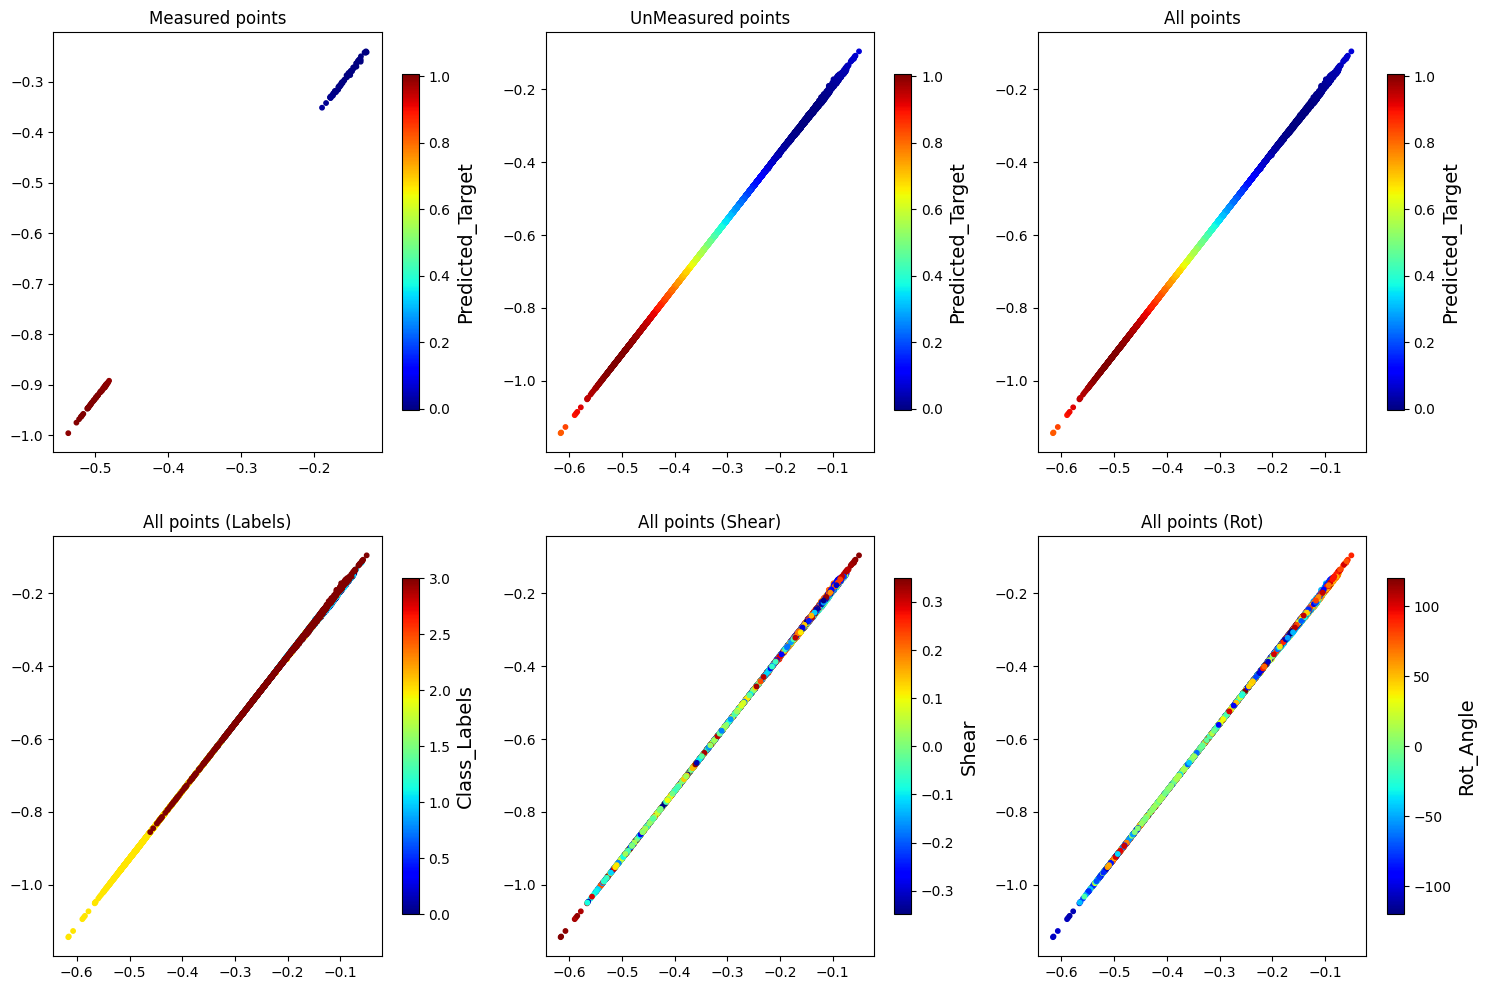

In [38]:
embeded_train2 = dkl_BO_2.embed(X2_train)  # Measured points
embeded_unmeasured2 = dkl_BO_2.embed(X2_unmeasured)  # Unmeasured points
embeded12 = dkl_BO_2.embed(X2)   # All points

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train2[:, 1], embeded_train2[:, 0], s=10, c = predmean_train2, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_unmeasured2[:, 1], embeded_unmeasured2[:, 0], s=10,
                c = predmean_unmeas2, cmap = 'jet')
ax[0,1].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded12[:, 1], embeded12[:, 0], s=10, c = predmean12, cmap = 'jet')
ax[0,2].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded12[:, 1], embeded12[:, 0], s=10, c = labels_all, cmap = 'jet')
ax[1,0].set_title('All points (Labels)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded12[:, 1], embeded12[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
ax[1,1].set_title('All points (Shear)')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded12[:, 1], embeded12[:, 0], s=10, c = angles_all, cmap = 'jet')
ax[1,2].set_title('All points (Rot)')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
cbar.set_label("Rot_Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Here, active learning produced much better manifolds. Instead of competing for the sam ereal estate in the latent space, active learning focussed attention on the attribute we are interested in (i.e. how close is the image to being a heart)

## Diamonds

And for completeness, diamonds.

In [39]:
X3 = np.copy(X)
targets3 = np.zeros(len(labels_all))
targets3[labels_all == 3] = 1

rng_key_3, rng_key_predict_3 = gpax.utils.get_keys()
dkl_3 = gpax.viDKL(900, 2, 'RBF')
dkl_3.fit(rng_key_3, X3, targets3)

100%|██████████| 1000/1000 [03:48<00:00,  4.37it/s, init loss: 69245.0383, avg. loss [951-1000]: 45740.9875]



Inferred GP kernel parameters
k_length         [2.9116 2.3391]
k_scale          0.2177
noise            0.0083


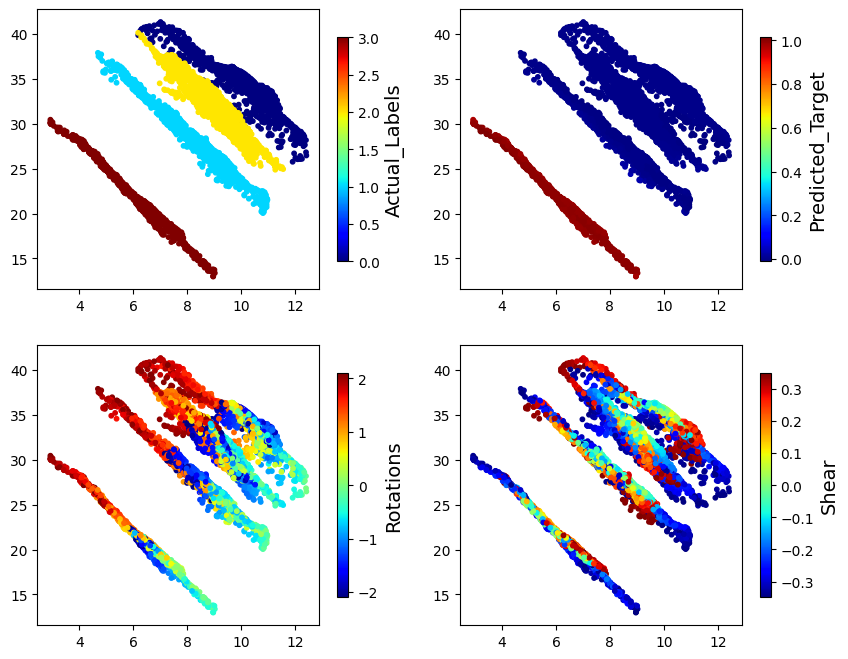

In [40]:
embeded_3 = dkl_3.embed(X3)
pred_mean3, pred_var3 = dkl_3.predict_in_batches(rng_key_predict_3, X3, batch_size=batch_size_reconstruct)
pred_std3 = jnp.sqrt(pred_var3)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_3[:, 1], embeded_3[:, 0], s=10, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_3[:, 1], embeded_3[:, 0], s=10, c = pred_mean3, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_3[:, 1], embeded_3[:, 0], s=10, c = torch.deg2rad(angles_all),
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_3[:, 1], embeded_3[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Here again we see relatively simple latent distribution. Diamonds are well separated form other three hands in the latent space. As before, good separation based on one attribute means poor disentanglement on other fatcors of variability.

In [41]:
np.random.seed(0)
idx3 = np.random.choice(np.arange(len(X3)), size = init_num, replace = False)
X3_train = X3[idx3]
X3_unmeasured = np.delete(X3, idx3, axis=0)

indices_total_3 = np.arange(len(X))
indices_train_3 = indices_total_3[idx3]
y3_train = targets3[idx3]
indices_unmeasured_3 = np.delete(indices_total_3, idx3)

In [42]:
exp_mean3, exp_std3 = [], []
dkl_mean3, dkl_std3 = [], []
embed_traj3 = []
traj_mean3, traj_std3 = [], []

exploration_steps = 70


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key13, rng_key_predict13 = gpax.utils.get_keys()
    dkl_BO_3 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_3.fit(rng_key13, X3_train, y3_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_3.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict13, X3_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()

    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean3.append(y_mean[id_next])
    exp_std3.append(y_std[id_next])

    x_next = X3_unmeasured[id_next]
    ind_next = indices_unmeasured_3[id_next]

    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean3.append(pred_mean3[ind_next])
    dkl_std3.append(pred_std3[ind_next])

    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = targets3[ind_next]

    # Update training arrays
    X3_train = np.append(X3_train, x_next[None], axis=0)
    y3_train = np.append(y3_train, y_measured)
    X3_unmeasured = np.delete(X3_unmeasured, id_next, axis=0)
    indices_unmeasured_3 = np.delete(indices_unmeasured_3, id_next)

    embed_traj = dkl_BO_3.embed(X3_train)
    traj_m, traj_s = dkl_BO_3.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict13, X3_train, batch_size=batch_size_learn)

    embed_traj3.append(embed_traj)
    traj_mean3.append(traj_m)


Step 1


100%|██████████| 1000/1000 [00:02<00:00, 486.93it/s, init loss: 60100.9646, avg. loss [951-1000]: 56929.4617]



Inferred GP kernel parameters
k_length         [0.3679 0.3048]
k_scale          0.4187
noise            0.0164

Step 2


100%|██████████| 1000/1000 [00:02<00:00, 492.30it/s, init loss: 60102.2089, avg. loss [951-1000]: 56927.8034]



Inferred GP kernel parameters
k_length         [0.3528 0.3431]
k_scale          0.33480000000000004
noise            0.016800000000000002

Step 3


100%|██████████| 1000/1000 [00:02<00:00, 485.17it/s, init loss: 60103.7103, avg. loss [951-1000]: 56920.6396]



Inferred GP kernel parameters
k_length         [0.3239 0.3679]
k_scale          0.4057
noise            0.0122

Step 4


100%|██████████| 1000/1000 [00:02<00:00, 483.14it/s, init loss: 60105.2152, avg. loss [951-1000]: 56927.7964]



Inferred GP kernel parameters
k_length         [0.3175 0.3626]
k_scale          0.3915
noise            0.0166

Step 5


100%|██████████| 1000/1000 [00:02<00:00, 476.95it/s, init loss: 60106.4595, avg. loss [951-1000]: 56961.1818]



Inferred GP kernel parameters
k_length         [0.3692 0.3055]
k_scale          0.24230000000000002
noise            0.018000000000000002

Step 6


100%|██████████| 1000/1000 [00:01<00:00, 501.48it/s, init loss: 60107.9646, avg. loss [951-1000]: 56915.5380]



Inferred GP kernel parameters
k_length         [0.314  0.3679]
k_scale          0.43060000000000004
noise            0.011000000000000001

Step 7


100%|██████████| 1000/1000 [00:02<00:00, 498.96it/s, init loss: 60109.4595, avg. loss [951-1000]: 56918.2368]



Inferred GP kernel parameters
k_length         [0.3572 0.3235]
k_scale          0.39390000000000003
noise            0.0146

Step 8


100%|██████████| 1000/1000 [00:02<00:00, 487.17it/s, init loss: 60110.7037, avg. loss [951-1000]: 56915.1644]



Inferred GP kernel parameters
k_length         [0.2994 0.3679]
k_scale          0.34600000000000003
noise            0.011300000000000001

Step 9


100%|██████████| 1000/1000 [00:02<00:00, 486.94it/s, init loss: 60112.1980, avg. loss [951-1000]: 56911.8382]



Inferred GP kernel parameters
k_length         [0.3243 0.3646]
k_scale          0.4294
noise            0.0108

Step 10


100%|██████████| 1000/1000 [00:02<00:00, 483.07it/s, init loss: 60113.6990, avg. loss [951-1000]: 56910.2670]



Inferred GP kernel parameters
k_length         [0.3586 0.3317]
k_scale          0.4358
noise            0.0106

Step 11


100%|██████████| 1000/1000 [00:03<00:00, 255.07it/s, init loss: 60115.0412, avg. loss [951-1000]: 56909.0770]



Inferred GP kernel parameters
k_length         [0.3155 0.352 ]
k_scale          0.4395
noise            0.0105

Step 12


100%|██████████| 1000/1000 [00:02<00:00, 479.32it/s, init loss: 60116.5441, avg. loss [951-1000]: 56906.9464]



Inferred GP kernel parameters
k_length         [0.3105 0.3679]
k_scale          0.43060000000000004
noise            0.0095

Step 13


100%|██████████| 1000/1000 [00:02<00:00, 482.71it/s, init loss: 60117.7873, avg. loss [951-1000]: 56905.6606]



Inferred GP kernel parameters
k_length         [0.3065 0.3679]
k_scale          0.434
noise            0.009600000000000001

Step 14


100%|██████████| 1000/1000 [00:02<00:00, 483.61it/s, init loss: 60119.0310, avg. loss [951-1000]: 56906.1471]



Inferred GP kernel parameters
k_length         [0.3608 0.3604]
k_scale          0.39
noise            0.010400000000000001

Step 15


100%|██████████| 1000/1000 [00:02<00:00, 474.93it/s, init loss: 60120.2753, avg. loss [951-1000]: 56902.7800]



Inferred GP kernel parameters
k_length         [0.3677 0.3138]
k_scale          0.4295
noise            0.0094

Step 16


100%|██████████| 1000/1000 [00:02<00:00, 468.32it/s, init loss: 60121.7789, avg. loss [951-1000]: 56901.7316]



Inferred GP kernel parameters
k_length         [0.3354 0.3423]
k_scale          0.4325
noise            0.0097

Step 17


100%|██████████| 1000/1000 [00:02<00:00, 483.63it/s, init loss: 60123.0230, avg. loss [951-1000]: 56911.5865]



Inferred GP kernel parameters
k_length         [0.3977 0.3499]
k_scale          0.38320000000000004
noise            0.0103

Step 18


100%|██████████| 1000/1000 [00:02<00:00, 472.54it/s, init loss: 60124.2375, avg. loss [951-1000]: 56899.9694]



Inferred GP kernel parameters
k_length         [0.3679 0.325 ]
k_scale          0.42610000000000003
noise            0.0097

Step 19


100%|██████████| 1000/1000 [00:02<00:00, 460.42it/s, init loss: 60125.7377, avg. loss [951-1000]: 56897.6070]



Inferred GP kernel parameters
k_length         [0.3679 0.3044]
k_scale          0.4304
noise            0.0094

Step 20


100%|██████████| 1000/1000 [00:02<00:00, 472.02it/s, init loss: 60127.1970, avg. loss [951-1000]: 56927.3923]



Inferred GP kernel parameters
k_length         [0.2217 0.3136]
k_scale          0.4152
noise            0.0117

Step 21


100%|██████████| 1000/1000 [00:02<00:00, 478.11it/s, init loss: 60128.4407, avg. loss [951-1000]: 56894.7881]



Inferred GP kernel parameters
k_length         [0.3076 0.3679]
k_scale          0.43410000000000004
noise            0.0094

Step 22


100%|██████████| 1000/1000 [00:02<00:00, 463.01it/s, init loss: 60129.9079, avg. loss [951-1000]: 56893.9513]



Inferred GP kernel parameters
k_length         [0.3259 0.3655]
k_scale          0.4349
noise            0.0097

Step 23


100%|██████████| 1000/1000 [00:02<00:00, 468.26it/s, init loss: 60131.1141, avg. loss [951-1000]: 56892.0701]



Inferred GP kernel parameters
k_length         [0.3679 0.3083]
k_scale          0.42800000000000005
noise            0.009000000000000001

Step 24


100%|██████████| 1000/1000 [00:02<00:00, 473.93it/s, init loss: 60132.5376, avg. loss [951-1000]: 56900.7100]



Inferred GP kernel parameters
k_length         [0.3955 0.3235]
k_scale          0.3682
noise            0.0108

Step 25


100%|██████████| 1000/1000 [00:02<00:00, 456.71it/s, init loss: 60133.7805, avg. loss [951-1000]: 56891.8567]



Inferred GP kernel parameters
k_length         [0.3727 0.3817]
k_scale          0.36960000000000004
noise            0.009600000000000001

Step 26


100%|██████████| 1000/1000 [00:02<00:00, 479.55it/s, init loss: 60135.2849, avg. loss [951-1000]: 56892.8124]



Inferred GP kernel parameters
k_length         [0.3576 0.323 ]
k_scale          0.3695
noise            0.010400000000000001

Step 27


100%|██████████| 1000/1000 [00:02<00:00, 470.85it/s, init loss: 60136.5291, avg. loss [951-1000]: 56891.0640]



Inferred GP kernel parameters
k_length         [0.341  0.3205]
k_scale          0.3824
noise            0.0102

Step 28


100%|██████████| 1000/1000 [00:02<00:00, 464.26it/s, init loss: 60137.7341, avg. loss [951-1000]: 56911.5593]



Inferred GP kernel parameters
k_length         [0.4352 0.422 ]
k_scale          0.31570000000000004
noise            0.012100000000000001

Step 29


100%|██████████| 1000/1000 [00:02<00:00, 478.65it/s, init loss: 60138.9784, avg. loss [951-1000]: 56883.4591]



Inferred GP kernel parameters
k_length         [0.3678 0.3122]
k_scale          0.4244
noise            0.008700000000000001

Step 30


100%|██████████| 1000/1000 [00:02<00:00, 473.80it/s, init loss: 60140.2225, avg. loss [951-1000]: 56887.2430]



Inferred GP kernel parameters
k_length         [0.3393 0.3518]
k_scale          0.37
noise            0.0097

Step 31


100%|██████████| 1000/1000 [00:02<00:00, 466.24it/s, init loss: 60141.7271, avg. loss [951-1000]: 56933.2796]



Inferred GP kernel parameters
k_length         [0.3887 0.2654]
k_scale          0.39390000000000003
noise            0.0111

Step 32


100%|██████████| 1000/1000 [00:02<00:00, 482.07it/s, init loss: 60143.0570, avg. loss [951-1000]: 56884.0309]



Inferred GP kernel parameters
k_length         [0.3983 0.4043]
k_scale          0.3516
noise            0.009600000000000001

Step 33


100%|██████████| 1000/1000 [00:02<00:00, 479.16it/s, init loss: 60144.2841, avg. loss [951-1000]: 56903.1609]



Inferred GP kernel parameters
k_length         [0.3937 0.3042]
k_scale          0.31270000000000003
noise            0.0118

Step 34


100%|██████████| 1000/1000 [00:02<00:00, 468.06it/s, init loss: 60145.5270, avg. loss [951-1000]: 56879.0145]



Inferred GP kernel parameters
k_length         [0.3933 0.399 ]
k_scale          0.41390000000000005
noise            0.0095

Step 35


100%|██████████| 1000/1000 [00:02<00:00, 476.65it/s, init loss: 60147.0254, avg. loss [951-1000]: 56917.9836]



Inferred GP kernel parameters
k_length         [0.4576 0.4731]
k_scale          0.2909
noise            0.0142

Step 36


100%|██████████| 1000/1000 [00:02<00:00, 478.67it/s, init loss: 60148.2696, avg. loss [951-1000]: 56884.1130]



Inferred GP kernel parameters
k_length         [0.3645 0.3847]
k_scale          0.39880000000000004
noise            0.010100000000000001

Step 37


100%|██████████| 1000/1000 [00:02<00:00, 469.22it/s, init loss: 60149.5101, avg. loss [951-1000]: 56878.7651]



Inferred GP kernel parameters
k_length         [0.4064 0.4008]
k_scale          0.3834
noise            0.01

Step 38


100%|██████████| 1000/1000 [00:02<00:00, 471.20it/s, init loss: 60150.9962, avg. loss [951-1000]: 56887.1902]



Inferred GP kernel parameters
k_length         [0.5374 0.5351]
k_scale          0.3058
noise            0.0117

Step 39


100%|██████████| 1000/1000 [00:02<00:00, 467.00it/s, init loss: 60152.2403, avg. loss [951-1000]: 56990.2290]



Inferred GP kernel parameters
k_length         [0.4437 0.4759]
k_scale          0.2937
noise            0.014400000000000001

Step 40


100%|██████████| 1000/1000 [00:02<00:00, 465.00it/s, init loss: 60153.5967, avg. loss [951-1000]: 57026.7721]



Inferred GP kernel parameters
k_length         [0.2804 0.4717]
k_scale          0.3376
noise            0.025900000000000003

Step 41


100%|██████████| 1000/1000 [00:02<00:00, 462.18it/s, init loss: 60154.7989, avg. loss [951-1000]: 56873.1718]



Inferred GP kernel parameters
k_length         [0.5039 0.5352]
k_scale          0.34440000000000004
noise            0.0097

Step 42


100%|██████████| 1000/1000 [00:02<00:00, 473.17it/s, init loss: 60156.0213, avg. loss [951-1000]: 56884.7415]



Inferred GP kernel parameters
k_length         [0.4133 0.4056]
k_scale          0.3391
noise            0.0114

Step 43


100%|██████████| 1000/1000 [00:02<00:00, 468.06it/s, init loss: 60157.2656, avg. loss [951-1000]: 56866.1615]



Inferred GP kernel parameters
k_length         [0.3778 0.3278]
k_scale          0.3884
noise            0.0089

Step 44


100%|██████████| 1000/1000 [00:02<00:00, 470.37it/s, init loss: 60158.5962, avg. loss [951-1000]: 56946.2851]



Inferred GP kernel parameters
k_length         [0.4946 0.5077]
k_scale          0.23620000000000002
noise            0.0132

Step 45


100%|██████████| 1000/1000 [00:02<00:00, 457.37it/s, init loss: 60159.8405, avg. loss [951-1000]: 56870.3027]



Inferred GP kernel parameters
k_length         [0.447  0.4121]
k_scale          0.36970000000000003
noise            0.009600000000000001

Step 46


100%|██████████| 1000/1000 [00:02<00:00, 461.12it/s, init loss: 60161.2484, avg. loss [951-1000]: 56865.4803]



Inferred GP kernel parameters
k_length         [0.4318 0.4051]
k_scale          0.3428
noise            0.0091

Step 47


100%|██████████| 1000/1000 [00:02<00:00, 468.69it/s, init loss: 60162.7156, avg. loss [951-1000]: 56941.7433]



Inferred GP kernel parameters
k_length         [0.5549 0.6088]
k_scale          0.29300000000000004
noise            0.0167

Step 48


100%|██████████| 1000/1000 [00:02<00:00, 464.11it/s, init loss: 60163.9600, avg. loss [951-1000]: 56880.3662]



Inferred GP kernel parameters
k_length         [0.5599 0.7242]
k_scale          0.25
noise            0.0111

Step 49


100%|██████████| 1000/1000 [00:02<00:00, 454.81it/s, init loss: 60165.4385, avg. loss [951-1000]: 56862.0466]



Inferred GP kernel parameters
k_length         [0.3583 0.3951]
k_scale          0.3561
noise            0.0091

Step 50


100%|██████████| 1000/1000 [00:02<00:00, 470.51it/s, init loss: 60166.6819, avg. loss [951-1000]: 56883.7680]



Inferred GP kernel parameters
k_length         [0.6258 0.5753]
k_scale          0.2787
noise            0.0123

Step 51


100%|██████████| 1000/1000 [00:02<00:00, 462.87it/s, init loss: 60168.0524, avg. loss [951-1000]: 56860.0480]



Inferred GP kernel parameters
k_length         [0.4304 0.3924]
k_scale          0.3607
noise            0.0097

Step 52


100%|██████████| 1000/1000 [00:02<00:00, 465.77it/s, init loss: 60169.2885, avg. loss [951-1000]: 56960.6171]



Inferred GP kernel parameters
k_length         [0.8109 0.6549]
k_scale          0.23450000000000001
noise            0.013900000000000001

Step 53


100%|██████████| 1000/1000 [00:02<00:00, 463.43it/s, init loss: 60170.5288, avg. loss [951-1000]: 56859.7954]



Inferred GP kernel parameters
k_length         [0.3894 0.3882]
k_scale          0.3149
noise            0.0095

Step 54


100%|██████████| 1000/1000 [00:02<00:00, 462.88it/s, init loss: 60171.7641, avg. loss [951-1000]: 56860.2995]



Inferred GP kernel parameters
k_length         [0.5226 0.4991]
k_scale          0.313
noise            0.0097

Step 55


100%|██████████| 1000/1000 [00:02<00:00, 473.87it/s, init loss: 60173.2638, avg. loss [951-1000]: 56853.0432]



Inferred GP kernel parameters
k_length         [0.3895 0.3279]
k_scale          0.3608
noise            0.0092

Step 56


100%|██████████| 1000/1000 [00:02<00:00, 461.22it/s, init loss: 60174.7618, avg. loss [951-1000]: 56927.9740]



Inferred GP kernel parameters
k_length         [0.7848 0.9731]
k_scale          0.1976
noise            0.0118

Step 57


100%|██████████| 1000/1000 [00:02<00:00, 464.60it/s, init loss: 60176.2444, avg. loss [951-1000]: 56850.5927]



Inferred GP kernel parameters
k_length         [0.4147 0.41  ]
k_scale          0.3512
noise            0.0092

Step 58


100%|██████████| 1000/1000 [00:02<00:00, 463.56it/s, init loss: 60177.7488, avg. loss [951-1000]: 56848.2766]



Inferred GP kernel parameters
k_length         [0.3662 0.346 ]
k_scale          0.3175
noise            0.009000000000000001

Step 59


100%|██████████| 1000/1000 [00:02<00:00, 463.67it/s, init loss: 60178.9931, avg. loss [951-1000]: 56979.0524]



Inferred GP kernel parameters
k_length         [0.7166 0.5796]
k_scale          0.2631
noise            0.0137

Step 60


100%|██████████| 1000/1000 [00:02<00:00, 466.57it/s, init loss: 60180.4981, avg. loss [951-1000]: 56860.0294]



Inferred GP kernel parameters
k_length         [0.6634 0.513 ]
k_scale          0.2569
noise            0.010400000000000001

Step 61


100%|██████████| 1000/1000 [00:02<00:00, 474.14it/s, init loss: 60181.7424, avg. loss [951-1000]: 56840.3516]



Inferred GP kernel parameters
k_length         [0.35   0.3397]
k_scale          0.3729
noise            0.008400000000000001

Step 62


100%|██████████| 1000/1000 [00:02<00:00, 467.52it/s, init loss: 60183.2469, avg. loss [951-1000]: 56842.8890]



Inferred GP kernel parameters
k_length         [0.3726 0.3742]
k_scale          0.3531
noise            0.0089

Step 63


100%|██████████| 1000/1000 [00:02<00:00, 469.96it/s, init loss: 60184.7172, avg. loss [951-1000]: 56999.7808]



Inferred GP kernel parameters
k_length         [0.2517 0.2676]
k_scale          0.4292
noise            0.0123

Step 64


100%|██████████| 1000/1000 [00:02<00:00, 456.46it/s, init loss: 60186.2147, avg. loss [951-1000]: 56840.9961]



Inferred GP kernel parameters
k_length         [0.3576 0.3801]
k_scale          0.3531
noise            0.009300000000000001

Step 65


100%|██████████| 1000/1000 [00:02<00:00, 470.14it/s, init loss: 60187.4563, avg. loss [951-1000]: 56852.0526]



Inferred GP kernel parameters
k_length         [0.4546 0.4464]
k_scale          0.2791
noise            0.0106

Step 66


100%|██████████| 1000/1000 [00:02<00:00, 461.33it/s, init loss: 60188.7057, avg. loss [951-1000]: 56880.3133]



Inferred GP kernel parameters
k_length         [0.5603 0.5845]
k_scale          0.29300000000000004
noise            0.0105

Step 67


100%|██████████| 1000/1000 [00:02<00:00, 461.98it/s, init loss: 60190.0921, avg. loss [951-1000]: 56879.0691]



Inferred GP kernel parameters
k_length         [1.0015 1.1213]
k_scale          0.21810000000000002
noise            0.0117

Step 68


100%|██████████| 1000/1000 [00:02<00:00, 458.97it/s, init loss: 60191.3344, avg. loss [951-1000]: 56842.3546]



Inferred GP kernel parameters
k_length         [0.6423 0.5559]
k_scale          0.2985
noise            0.0094

Step 69


100%|██████████| 1000/1000 [00:02<00:00, 455.09it/s, init loss: 60192.5274, avg. loss [951-1000]: 56841.0055]



Inferred GP kernel parameters
k_length         [0.4518 0.4007]
k_scale          0.3304
noise            0.0088

Step 70


100%|██████████| 1000/1000 [00:02<00:00, 455.17it/s, init loss: 60193.7652, avg. loss [951-1000]: 56843.6467]



Inferred GP kernel parameters
k_length         [0.5928 0.6093]
k_scale          0.2801
noise            0.010700000000000001


In [43]:
diams_results = {}
diams_results['X_train'] = X3_train
diams_results['y_train'] = y3_train
diams_results['X_unmeasured'] = X3_unmeasured
diams_results['indices_unmeasured'] = indices_unmeasured_3
diams_results['dkl_mean'] = dkl_mean3
diams_results['dkl_std'] = dkl_std3
diams_results['exp_mean'] = exp_mean3
diams_results['exp_std'] = exp_std3
diams_results['traj_mean'] = traj_mean3
diams_results['traj_std'] = traj_std3
diams_results['embed_traj'] = embed_traj3

with open('diams_results.pickle', 'wb') as handle:
    pickle.dump(diams_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
with open('diams_results.pickle', 'rb') as f:
    diams_results = pickle.load(f)

X3_train = diams_results['X_train']
y3_train = diams_results['y_train']
X3_unmeasured = diams_results['X_unmeasured']
indices_unmeasured_3 = diams_results['indices_unmeasured']
dkl_mean3 = diams_results['dkl_mean']
dkl_std3 = diams_results['dkl_std']
exp_mean3 = diams_results['exp_mean']
exp_std3 = diams_results['exp_std']
traj_mean3 = diams_results['traj_mean']
traj_std3 = diams_results['traj_std']
embed_traj3 = diams_results['embed_traj']

In [45]:
rng_key13, rng_key_predict13 = gpax.utils.get_keys()
dkl_BO_3 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_3.fit(rng_key13, X3_train, y3_train)

predmean_train3, predstd_train3 = dkl_BO_3.predict_in_batches(rng_key_predict13, X3_train, batch_size=batch_size_learn)
predmean_unmeas3, predstd_unmeas3 = dkl_BO_3.predict_in_batches(rng_key_predict13, X3_unmeasured, batch_size=batch_size_reconstruct)
predmean13, predstd13 = dkl_BO_3.predict_in_batches(rng_key_predict13, X3, batch_size=batch_size_reconstruct)

100%|██████████| 1000/1000 [00:02<00:00, 451.41it/s, init loss: 60194.9483, avg. loss [951-1000]: 56860.3216]



Inferred GP kernel parameters
k_length         [0.4656 0.472 ]
k_scale          0.334
noise            0.009300000000000001


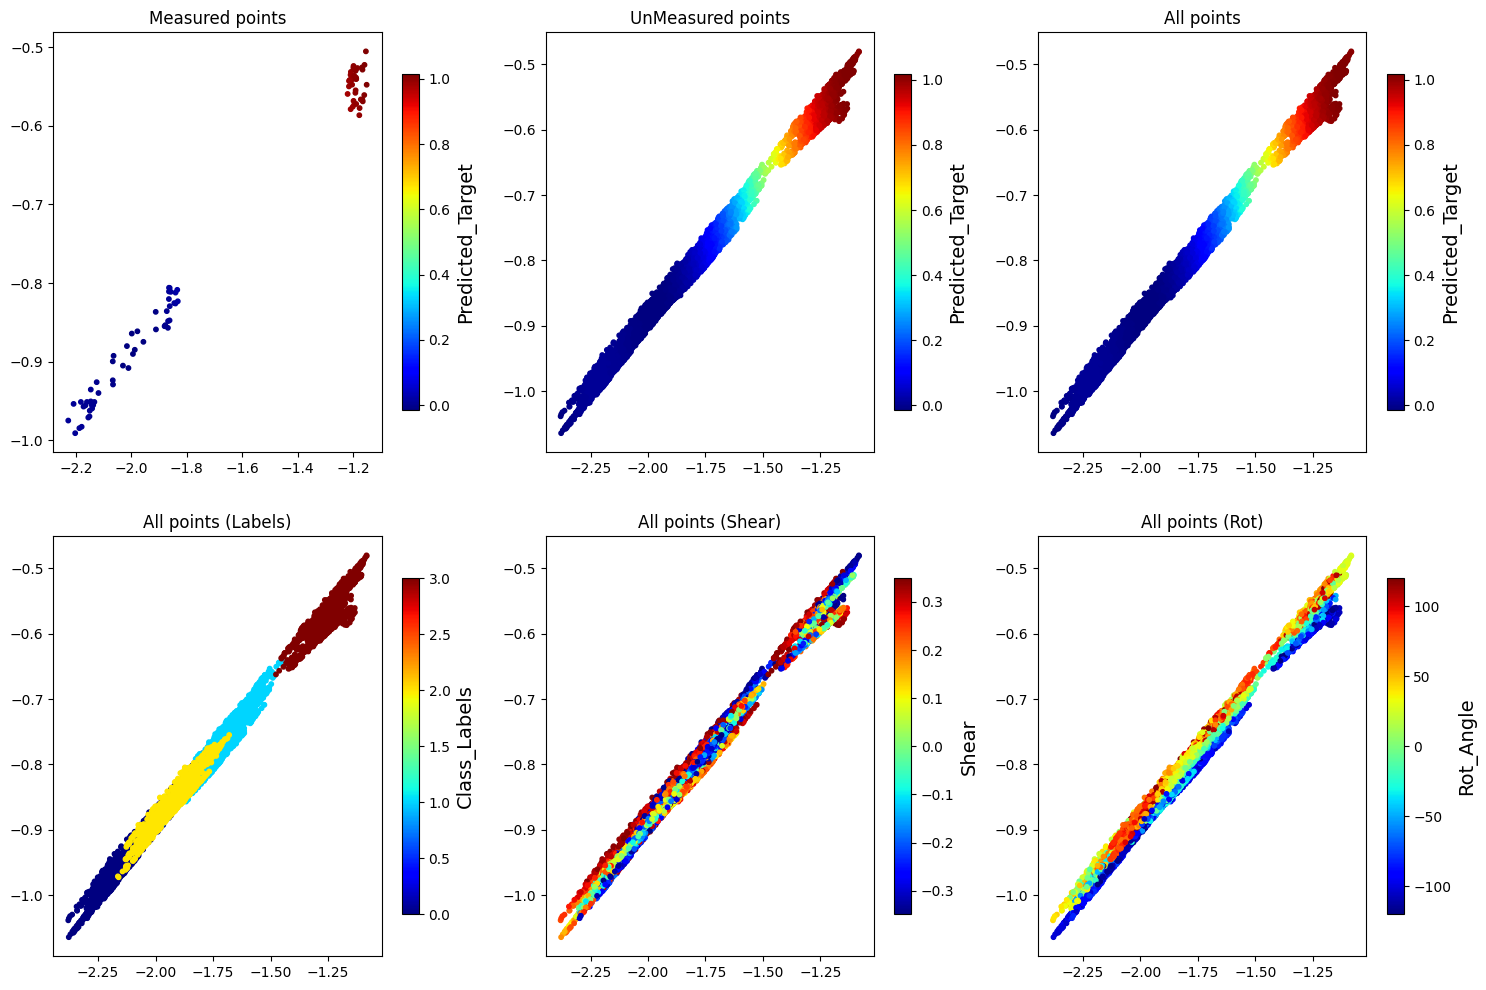

In [46]:
embeded_train3 = dkl_BO_3.embed(X3_train)  # Measured points
embeded_unmeasured3 = dkl_BO_3.embed(X3_unmeasured)  # Unmeasured points
embeded13 = dkl_BO_3.embed(X3)   # All points

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train3[:, 1], embeded_train3[:, 0], s=10, c = predmean_train3, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_unmeasured3[:, 1], embeded_unmeasured3[:, 0], s=10,
                c = predmean_unmeas3, cmap = 'jet')
ax[0,1].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded13[:, 1], embeded13[:, 0], s=10, c = predmean13, cmap = 'jet')
ax[0,2].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded13[:, 1], embeded13[:, 0], s=10, c = labels_all, cmap = 'jet')
ax[1,0].set_title('All points (Labels)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded13[:, 1], embeded13[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
ax[1,1].set_title('All points (Shear)')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded13[:, 1], embeded13[:, 0], s=10, c = angles_all, cmap = 'jet')
ax[1,2].set_title('All points (Rot)')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
cbar.set_label("Rot_Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)

# All hands as a function

Now, let's make the problem slightly more interesting. We define the function that puts a number to the hand (meaning hearts are 1, diamonds are 2, etc). This is not a very good way of doing it - since these are cathegorical variables. But as mentioned before, we consider card images as a toy model for more complex scenarios (molecules, process trajectories, etc). So, let's experiment!

In [47]:
X4 = np.copy(X)
targets4 = np.copy((labels_all))

rng_key_4, rng_key_predict_4 = gpax.utils.get_keys()
dkl_4 = gpax.viDKL(900, 2, 'RBF')
dkl_4.fit(rng_key_4, X, targets4)

100%|██████████| 1000/1000 [03:48<00:00,  4.38it/s, init loss: 72172.6567, avg. loss [951-1000]: 46226.2532]



Inferred GP kernel parameters
k_length         [4.4678 3.6224]
k_scale          0.8139000000000001
noise            0.0088


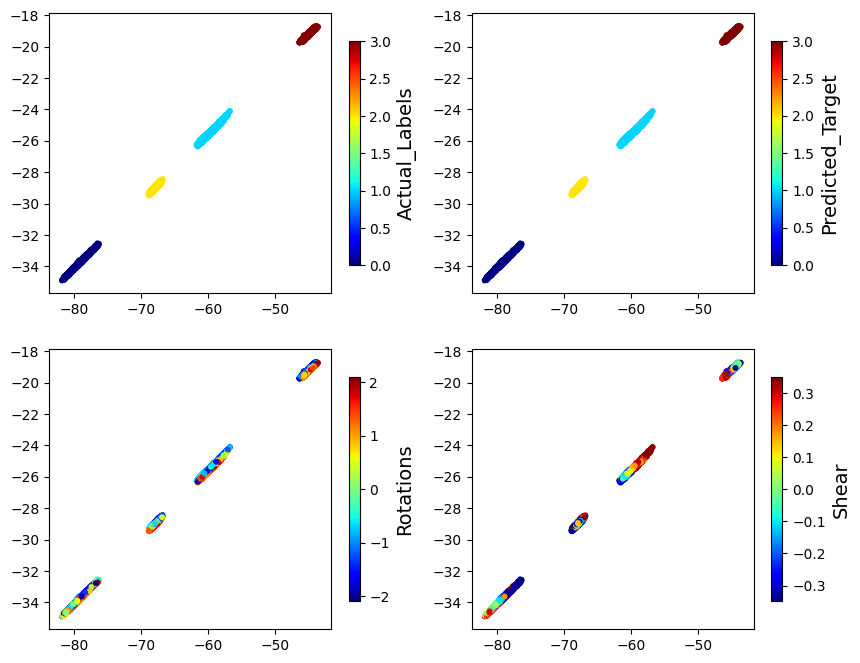

In [48]:
embeded_4 = dkl_4.embed(X)
pred_mean4, pred_var4 = dkl_4.predict_in_batches(rng_key_predict_4, X, batch_size=batch_size_reconstruct)
pred_std4 = jnp.sqrt(pred_var4)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_4[:, 1], embeded_4[:, 0], s=10, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_4[:, 1], embeded_4[:, 0], s=10, c = pred_mean4, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_4[:, 1], embeded_4[:, 0], s=10, c = torch.deg2rad(angles_all),
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_4[:, 1], embeded_4[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

As you can see, our "card function" is well separated in the latent space. Interestingly, we can see the disentanglement of representations for rotations and shear within each cluster.

In [49]:
np.random.seed(0)
idx4 = np.random.choice(np.arange(len(X4)), size = init_num, replace = False)
X4_train = X4[idx4]
X4_unmeasured = np.delete(X4, idx4, axis=0)

indices_total_4 = np.arange(len(X))
indices_train_4 = indices_total_4[idx4]
y4_train = targets4[idx4]
indices_unmeasured_4 = np.delete(indices_total_4, idx4)

In [50]:
exp_mean4, exp_std4 = [], []
dkl_mean4, dkl_std4 = [], []
embed_traj4 = []
traj_mean4, traj_std4 = [], []

exploration_steps = exp_step


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key14, rng_key_predict14 = gpax.utils.get_keys()
    dkl_BO_4 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_4.fit(rng_key14, X4_train, y4_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_4.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict14, X4_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()

    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean4.append(y_mean[id_next])
    exp_std4.append(y_std[id_next])

    x_next = X4_unmeasured[id_next]
    ind_next = indices_unmeasured_4[id_next]

    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean4.append(pred_mean4[ind_next])
    dkl_std4.append(pred_std4[ind_next])

    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = targets4[ind_next]

    # Update training arrays
    X4_train = np.append(X4_train, x_next[None], axis=0)
    y4_train = np.append(y4_train, y_measured)
    X4_unmeasured = np.delete(X4_unmeasured, id_next, axis=0)
    indices_unmeasured_4 = np.delete(indices_unmeasured_4, id_next)

    embed_traj = dkl_BO_4.embed(X4_train)
    traj_m, traj_s = dkl_BO_4.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict14, X4_train, batch_size=batch_size_learn)

    embed_traj4.append(embed_traj)
    traj_mean4.append(traj_m)


Step 1


100%|██████████| 1000/1000 [00:02<00:00, 493.62it/s, init loss: 60116.5994, avg. loss [951-1000]: 56946.0767]



Inferred GP kernel parameters
k_length         [0.599  0.5193]
k_scale          1.6289
noise            0.0188

Step 2


100%|██████████| 1000/1000 [00:02<00:00, 489.69it/s, init loss: 60120.1791, avg. loss [951-1000]: 56934.5717]



Inferred GP kernel parameters
k_length         [0.5385 0.6315]
k_scale          1.619
noise            0.0233

Step 3


100%|██████████| 1000/1000 [00:02<00:00, 469.40it/s, init loss: 60122.6098, avg. loss [951-1000]: 56946.3523]



Inferred GP kernel parameters
k_length         [0.8134 0.6733]
k_scale          1.6479000000000001
noise            0.021400000000000002

Step 4


100%|██████████| 1000/1000 [00:02<00:00, 487.66it/s, init loss: 60126.1873, avg. loss [951-1000]: 56947.5912]



Inferred GP kernel parameters
k_length         [0.6246 0.5789]
k_scale          1.4456
noise            0.020900000000000002

Step 5


100%|██████████| 1000/1000 [00:02<00:00, 493.29it/s, init loss: 60128.1570, avg. loss [951-1000]: 56931.8094]



Inferred GP kernel parameters
k_length         [0.4894 0.6967]
k_scale          1.6082
noise            0.0166

Step 6


100%|██████████| 1000/1000 [00:02<00:00, 483.83it/s, init loss: 60131.6792, avg. loss [951-1000]: 56967.3985]



Inferred GP kernel parameters
k_length         [0.598 0.612]
k_scale          1.5712000000000002
noise            0.023700000000000002

Step 7


100%|██████████| 1000/1000 [00:01<00:00, 502.47it/s, init loss: 60135.2551, avg. loss [951-1000]: 56929.8294]



Inferred GP kernel parameters
k_length         [0.588  0.4861]
k_scale          1.669
noise            0.0177

Step 8


100%|██████████| 1000/1000 [00:02<00:00, 489.95it/s, init loss: 60138.8270, avg. loss [951-1000]: 56930.4944]



Inferred GP kernel parameters
k_length         [0.5616 0.6824]
k_scale          1.6146
noise            0.020200000000000003

Step 9


100%|██████████| 1000/1000 [00:02<00:00, 492.05it/s, init loss: 60141.3650, avg. loss [951-1000]: 56929.0706]



Inferred GP kernel parameters
k_length         [0.568 0.842]
k_scale          1.5879
noise            0.0181

Step 10


100%|██████████| 1000/1000 [00:02<00:00, 492.08it/s, init loss: 60144.8027, avg. loss [951-1000]: 56951.6361]



Inferred GP kernel parameters
k_length         [0.4584 0.5668]
k_scale          1.6820000000000002
noise            0.020800000000000003

Step 11


100%|██████████| 1000/1000 [00:02<00:00, 498.50it/s, init loss: 60146.0470, avg. loss [951-1000]: 56926.0553]



Inferred GP kernel parameters
k_length         [0.532  0.4803]
k_scale          1.7203000000000002
noise            0.0148

Step 12


100%|██████████| 1000/1000 [00:02<00:00, 479.83it/s, init loss: 60149.4027, avg. loss [951-1000]: 56932.3348]



Inferred GP kernel parameters
k_length         [0.4685 0.5738]
k_scale          1.6704
noise            0.0155

Step 13


100%|██████████| 1000/1000 [00:02<00:00, 488.48it/s, init loss: 60151.0635, avg. loss [951-1000]: 56934.4926]



Inferred GP kernel parameters
k_length         [0.6401 0.8911]
k_scale          1.5491000000000001
noise            0.016

Step 14


100%|██████████| 1000/1000 [00:02<00:00, 479.31it/s, init loss: 60154.1999, avg. loss [951-1000]: 56926.9306]



Inferred GP kernel parameters
k_length         [0.6624 0.8028]
k_scale          1.3537000000000001
noise            0.0166

Step 15


100%|██████████| 1000/1000 [00:02<00:00, 480.49it/s, init loss: 60157.5194, avg. loss [951-1000]: 56918.3486]



Inferred GP kernel parameters
k_length         [0.5041 0.5688]
k_scale          1.7757
noise            0.0131

Step 16


100%|██████████| 1000/1000 [00:02<00:00, 486.07it/s, init loss: 60159.7973, avg. loss [951-1000]: 56924.7397]



Inferred GP kernel parameters
k_length         [0.4346 0.6142]
k_scale          1.6602000000000001
noise            0.014400000000000001

Step 17


100%|██████████| 1000/1000 [00:02<00:00, 477.25it/s, init loss: 60161.1639, avg. loss [951-1000]: 56933.6395]



Inferred GP kernel parameters
k_length         [0.9732 1.5962]
k_scale          1.355
noise            0.0146

Step 18


100%|██████████| 1000/1000 [00:02<00:00, 480.14it/s, init loss: 60164.2865, avg. loss [951-1000]: 57011.1286]



Inferred GP kernel parameters
k_length         [0.407  0.5042]
k_scale          2.2057
noise            0.0222

Step 19


100%|██████████| 1000/1000 [00:02<00:00, 479.79it/s, init loss: 60165.6139, avg. loss [951-1000]: 56912.8563]



Inferred GP kernel parameters
k_length         [0.655 0.545]
k_scale          1.661
noise            0.012

Step 20


100%|██████████| 1000/1000 [00:02<00:00, 471.96it/s, init loss: 60169.1504, avg. loss [951-1000]: 56932.9168]



Inferred GP kernel parameters
k_length         [0.8588 0.7241]
k_scale          1.4381000000000002
noise            0.0114

Step 21


100%|██████████| 1000/1000 [00:02<00:00, 480.32it/s, init loss: 60172.6939, avg. loss [951-1000]: 56937.9500]



Inferred GP kernel parameters
k_length         [0.8556 1.0156]
k_scale          1.4789
noise            0.0155

Step 22


100%|██████████| 1000/1000 [00:04<00:00, 237.28it/s, init loss: 60176.2073, avg. loss [951-1000]: 56919.0101]



Inferred GP kernel parameters
k_length         [0.9932 1.123 ]
k_scale          1.5306000000000002
noise            0.0137

Step 23


100%|██████████| 1000/1000 [00:02<00:00, 473.75it/s, init loss: 60179.5312, avg. loss [951-1000]: 56905.8420]



Inferred GP kernel parameters
k_length         [0.525  0.4387]
k_scale          1.6606
noise            0.0109

Step 24


100%|██████████| 1000/1000 [00:02<00:00, 474.71it/s, init loss: 60182.0162, avg. loss [951-1000]: 56933.9663]



Inferred GP kernel parameters
k_length         [0.7492 0.9549]
k_scale          1.6966
noise            0.0167

Step 25


100%|██████████| 1000/1000 [00:02<00:00, 471.16it/s, init loss: 60185.5339, avg. loss [951-1000]: 56908.6035]



Inferred GP kernel parameters
k_length         [0.5354 0.5629]
k_scale          1.6031
noise            0.0118

Step 26


100%|██████████| 1000/1000 [00:02<00:00, 472.73it/s, init loss: 60188.8293, avg. loss [951-1000]: 56915.3793]



Inferred GP kernel parameters
k_length         [0.9251 0.8127]
k_scale          1.492
noise            0.014100000000000001

Step 27


100%|██████████| 1000/1000 [00:02<00:00, 479.56it/s, init loss: 60190.9379, avg. loss [951-1000]: 56956.4856]



Inferred GP kernel parameters
k_length         [0.9128 1.0433]
k_scale          1.7582
noise            0.0201

Step 28


100%|██████████| 1000/1000 [00:02<00:00, 458.87it/s, init loss: 60192.2731, avg. loss [951-1000]: 56903.6127]



Inferred GP kernel parameters
k_length         [0.6301 0.7482]
k_scale          1.6554
noise            0.0105

Step 29


100%|██████████| 1000/1000 [00:02<00:00, 467.96it/s, init loss: 60194.0719, avg. loss [951-1000]: 56935.3627]



Inferred GP kernel parameters
k_length         [0.9846 0.8737]
k_scale          1.5185000000000002
noise            0.0134

Step 30


100%|██████████| 1000/1000 [00:02<00:00, 473.16it/s, init loss: 60195.3515, avg. loss [951-1000]: 56911.0269]



Inferred GP kernel parameters
k_length         [1.0977 0.9045]
k_scale          1.3075
noise            0.015300000000000001

Step 31


100%|██████████| 1000/1000 [00:02<00:00, 461.83it/s, init loss: 60196.5957, avg. loss [951-1000]: 56906.7244]



Inferred GP kernel parameters
k_length         [1.2223 1.1514]
k_scale          1.5241
noise            0.012100000000000001

Step 32


100%|██████████| 1000/1000 [00:02<00:00, 470.03it/s, init loss: 60199.7983, avg. loss [951-1000]: 56900.5176]



Inferred GP kernel parameters
k_length         [0.9395 1.1511]
k_scale          1.5137
noise            0.0115

Step 33


100%|██████████| 1000/1000 [00:02<00:00, 469.34it/s, init loss: 60202.6673, avg. loss [951-1000]: 56930.7028]



Inferred GP kernel parameters
k_length         [2.0508 1.4778]
k_scale          1.3814
noise            0.013600000000000001

Step 34


100%|██████████| 1000/1000 [00:02<00:00, 463.85it/s, init loss: 60204.8606, avg. loss [951-1000]: 56938.2719]



Inferred GP kernel parameters
k_length         [0.9862 1.1498]
k_scale          1.4505000000000001
noise            0.0132

Step 35


100%|██████████| 1000/1000 [00:02<00:00, 471.18it/s, init loss: 60208.3599, avg. loss [951-1000]: 56922.5835]



Inferred GP kernel parameters
k_length         [1.6292 1.7225]
k_scale          1.5059
noise            0.0154

Step 36


100%|██████████| 1000/1000 [00:02<00:00, 472.86it/s, init loss: 60209.6041, avg. loss [951-1000]: 56904.8904]



Inferred GP kernel parameters
k_length         [2.1451 1.3997]
k_scale          1.4055
noise            0.013000000000000001

Step 37


100%|██████████| 1000/1000 [00:02<00:00, 470.12it/s, init loss: 60211.8774, avg. loss [951-1000]: 56905.9095]



Inferred GP kernel parameters
k_length         [1.5239 1.7602]
k_scale          1.5059
noise            0.0129

Step 38


100%|██████████| 1000/1000 [00:02<00:00, 465.23it/s, init loss: 60214.2599, avg. loss [951-1000]: 56896.1452]



Inferred GP kernel parameters
k_length         [0.816  0.7879]
k_scale          1.6558000000000002
noise            0.012

Step 39


100%|██████████| 1000/1000 [00:02<00:00, 472.73it/s, init loss: 60217.8519, avg. loss [951-1000]: 56897.1566]



Inferred GP kernel parameters
k_length         [2.2631 1.6505]
k_scale          1.3261
noise            0.0112

Step 40


100%|██████████| 1000/1000 [00:02<00:00, 474.19it/s, init loss: 60221.0284, avg. loss [951-1000]: 56934.5231]



Inferred GP kernel parameters
k_length         [1.98   2.0629]
k_scale          1.4047
noise            0.013600000000000001

Step 41


100%|██████████| 1000/1000 [00:02<00:00, 470.69it/s, init loss: 60223.9808, avg. loss [951-1000]: 56966.2096]



Inferred GP kernel parameters
k_length         [1.1447 1.1481]
k_scale          1.4915
noise            0.0128

Step 42


100%|██████████| 1000/1000 [00:02<00:00, 474.20it/s, init loss: 60225.2251, avg. loss [951-1000]: 56885.0899]



Inferred GP kernel parameters
k_length         [0.77   0.8434]
k_scale          1.5078
noise            0.0097

Step 43


100%|██████████| 1000/1000 [00:02<00:00, 469.84it/s, init loss: 60227.5107, avg. loss [951-1000]: 56906.8625]



Inferred GP kernel parameters
k_length         [1.7848 1.5439]
k_scale          1.3695000000000002
noise            0.0117

Step 44


100%|██████████| 1000/1000 [00:02<00:00, 474.19it/s, init loss: 60231.1013, avg. loss [951-1000]: 56911.1190]



Inferred GP kernel parameters
k_length         [1.4292 1.1095]
k_scale          1.4535
noise            0.0108

Step 45


100%|██████████| 1000/1000 [00:02<00:00, 461.31it/s, init loss: 60232.3511, avg. loss [951-1000]: 56905.7323]



Inferred GP kernel parameters
k_length         [2.2408 1.9338]
k_scale          1.4708
noise            0.0122

Step 46


100%|██████████| 1000/1000 [00:02<00:00, 464.36it/s, init loss: 60235.5125, avg. loss [951-1000]: 56893.1042]



Inferred GP kernel parameters
k_length         [2.6846 1.397 ]
k_scale          1.3834
noise            0.0115

Step 47


100%|██████████| 1000/1000 [00:02<00:00, 470.94it/s, init loss: 60237.7253, avg. loss [951-1000]: 56946.3840]



Inferred GP kernel parameters
k_length         [2.1038 2.7624]
k_scale          1.4931
noise            0.0137

Step 48


100%|██████████| 1000/1000 [00:02<00:00, 465.34it/s, init loss: 60241.1078, avg. loss [951-1000]: 56913.1497]



Inferred GP kernel parameters
k_length         [0.8635 0.9164]
k_scale          1.6609
noise            0.0111

Step 49


100%|██████████| 1000/1000 [00:02<00:00, 469.66it/s, init loss: 60244.1611, avg. loss [951-1000]: 56921.6301]



Inferred GP kernel parameters
k_length         [1.9064 1.7748]
k_scale          1.4551
noise            0.0134

Step 50


100%|██████████| 1000/1000 [00:02<00:00, 463.88it/s, init loss: 60247.7520, avg. loss [951-1000]: 56887.9460]



Inferred GP kernel parameters
k_length         [1.7713 1.5504]
k_scale          1.3768
noise            0.0112

Step 51


100%|██████████| 1000/1000 [00:02<00:00, 464.65it/s, init loss: 60250.7434, avg. loss [951-1000]: 56888.3831]



Inferred GP kernel parameters
k_length         [1.4887 1.5921]
k_scale          1.4547
noise            0.0099

Step 52


100%|██████████| 1000/1000 [00:02<00:00, 458.42it/s, init loss: 60252.8411, avg. loss [951-1000]: 56882.4801]



Inferred GP kernel parameters
k_length         [1.5191 1.23  ]
k_scale          1.4907000000000001
noise            0.0105

Step 53


100%|██████████| 1000/1000 [00:04<00:00, 238.15it/s, init loss: 60255.5917, avg. loss [951-1000]: 56935.3193]



Inferred GP kernel parameters
k_length         [2.777  2.7175]
k_scale          1.4073
noise            0.0158

Step 54


100%|██████████| 1000/1000 [00:02<00:00, 464.73it/s, init loss: 60256.8359, avg. loss [951-1000]: 56867.2902]



Inferred GP kernel parameters
k_length         [1.0543 1.0807]
k_scale          1.5015
noise            0.009300000000000001

Step 55


100%|██████████| 1000/1000 [00:02<00:00, 461.90it/s, init loss: 60259.3289, avg. loss [951-1000]: 56873.6442]



Inferred GP kernel parameters
k_length         [1.9117 1.6537]
k_scale          1.4109
noise            0.0097

Step 56


100%|██████████| 1000/1000 [00:02<00:00, 457.96it/s, init loss: 60262.1725, avg. loss [951-1000]: 56913.3551]



Inferred GP kernel parameters
k_length         [2.1893 2.6627]
k_scale          1.3804
noise            0.0119

Step 57


100%|██████████| 1000/1000 [00:02<00:00, 464.90it/s, init loss: 60265.7644, avg. loss [951-1000]: 56886.6557]



Inferred GP kernel parameters
k_length         [2.0592 1.817 ]
k_scale          1.447
noise            0.0095

Step 58


100%|██████████| 1000/1000 [00:02<00:00, 475.21it/s, init loss: 60268.9534, avg. loss [951-1000]: 56892.9917]



Inferred GP kernel parameters
k_length         [3.2187 3.2502]
k_scale          1.5375
noise            0.0123

Step 59


100%|██████████| 1000/1000 [00:02<00:00, 460.05it/s, init loss: 60272.2879, avg. loss [951-1000]: 56878.0348]



Inferred GP kernel parameters
k_length         [2.3032 1.7224]
k_scale          1.3258
noise            0.011300000000000001

Step 60


100%|██████████| 1000/1000 [00:02<00:00, 469.46it/s, init loss: 60274.7926, avg. loss [951-1000]: 56887.3972]



Inferred GP kernel parameters
k_length         [1.5114 1.2111]
k_scale          1.4861
noise            0.011300000000000001

Step 61


100%|██████████| 1000/1000 [00:02<00:00, 467.48it/s, init loss: 60276.3376, avg. loss [951-1000]: 56885.3280]



Inferred GP kernel parameters
k_length         [3.1038 1.7971]
k_scale          1.4412
noise            0.0123

Step 62


100%|██████████| 1000/1000 [00:02<00:00, 471.67it/s, init loss: 60278.5482, avg. loss [951-1000]: 56937.9109]



Inferred GP kernel parameters
k_length         [0.9961 0.8982]
k_scale          1.5677
noise            0.0105

Step 63


100%|██████████| 1000/1000 [00:02<00:00, 471.44it/s, init loss: 60279.8494, avg. loss [951-1000]: 56885.9525]



Inferred GP kernel parameters
k_length         [1.8177 1.6813]
k_scale          1.3646
noise            0.01

Step 64


100%|██████████| 1000/1000 [00:02<00:00, 467.99it/s, init loss: 60283.1336, avg. loss [951-1000]: 56904.5461]



Inferred GP kernel parameters
k_length         [2.7318 2.355 ]
k_scale          1.4260000000000002
noise            0.011300000000000001

Step 65


100%|██████████| 1000/1000 [00:02<00:00, 464.67it/s, init loss: 60284.7797, avg. loss [951-1000]: 56874.2785]



Inferred GP kernel parameters
k_length         [1.445  1.6492]
k_scale          1.3873
noise            0.009600000000000001

Step 66


100%|██████████| 1000/1000 [00:02<00:00, 473.65it/s, init loss: 60286.8508, avg. loss [951-1000]: 56872.7811]



Inferred GP kernel parameters
k_length         [2.2542 1.496 ]
k_scale          1.3679000000000001
noise            0.0097

Step 67


100%|██████████| 1000/1000 [00:02<00:00, 462.80it/s, init loss: 60289.6315, avg. loss [951-1000]: 56907.8466]



Inferred GP kernel parameters
k_length         [3.0847 2.4231]
k_scale          1.3277
noise            0.0132

Step 68


100%|██████████| 1000/1000 [00:02<00:00, 466.97it/s, init loss: 60292.2170, avg. loss [951-1000]: 56875.6739]



Inferred GP kernel parameters
k_length         [2.2053 2.4167]
k_scale          1.4086
noise            0.010400000000000001

Step 69


100%|██████████| 1000/1000 [00:02<00:00, 466.82it/s, init loss: 60294.3341, avg. loss [951-1000]: 56845.5244]



Inferred GP kernel parameters
k_length         [1.5046 1.2515]
k_scale          1.3704
noise            0.008700000000000001

Step 70


100%|██████████| 1000/1000 [00:02<00:00, 466.26it/s, init loss: 60297.1715, avg. loss [951-1000]: 56863.2110]



Inferred GP kernel parameters
k_length         [1.6261 1.4604]
k_scale          1.3449
noise            0.010100000000000001

Step 71


100%|██████████| 1000/1000 [00:02<00:00, 464.99it/s, init loss: 60298.6557, avg. loss [951-1000]: 56867.8573]



Inferred GP kernel parameters
k_length         [2.6513 2.417 ]
k_scale          1.2950000000000002
noise            0.011000000000000001

Step 72


100%|██████████| 1000/1000 [00:02<00:00, 461.94it/s, init loss: 60301.0158, avg. loss [951-1000]: 56917.4101]



Inferred GP kernel parameters
k_length         [1.9519 2.0037]
k_scale          1.4314
noise            0.0123

Step 73


100%|██████████| 1000/1000 [00:02<00:00, 466.53it/s, init loss: 60303.5109, avg. loss [951-1000]: 56861.3215]



Inferred GP kernel parameters
k_length         [2.3736 2.164 ]
k_scale          1.3041
noise            0.0118

Step 74


100%|██████████| 1000/1000 [00:02<00:00, 462.62it/s, init loss: 60305.4119, avg. loss [951-1000]: 56896.0565]



Inferred GP kernel parameters
k_length         [1.9401 2.1327]
k_scale          1.5285
noise            0.0132

Step 75


100%|██████████| 1000/1000 [00:02<00:00, 461.05it/s, init loss: 60309.0027, avg. loss [951-1000]: 56881.4108]



Inferred GP kernel parameters
k_length         [2.7868 2.1538]
k_scale          1.3465
noise            0.0117

Step 76


100%|██████████| 1000/1000 [00:02<00:00, 463.29it/s, init loss: 60310.4494, avg. loss [951-1000]: 56906.1424]



Inferred GP kernel parameters
k_length         [2.4309 1.8252]
k_scale          1.3611
noise            0.012

Step 77


100%|██████████| 1000/1000 [00:02<00:00, 459.78it/s, init loss: 60312.5445, avg. loss [951-1000]: 56872.8369]



Inferred GP kernel parameters
k_length         [4.5363 2.1312]
k_scale          1.3377000000000001
noise            0.0123

Step 78


100%|██████████| 1000/1000 [00:02<00:00, 461.26it/s, init loss: 60316.1494, avg. loss [951-1000]: 56861.6034]



Inferred GP kernel parameters
k_length         [1.8229 2.2484]
k_scale          1.3781
noise            0.0097

Step 79


100%|██████████| 1000/1000 [00:02<00:00, 470.36it/s, init loss: 60319.8014, avg. loss [951-1000]: 56875.2085]



Inferred GP kernel parameters
k_length         [4.8172 3.0721]
k_scale          1.2995
noise            0.013300000000000001

Step 80


100%|██████████| 1000/1000 [00:02<00:00, 460.20it/s, init loss: 60321.2528, avg. loss [951-1000]: 56848.7300]



Inferred GP kernel parameters
k_length         [3.8217 2.031 ]
k_scale          1.4147
noise            0.010100000000000001

Step 81


100%|██████████| 1000/1000 [00:02<00:00, 453.97it/s, init loss: 60322.6441, avg. loss [951-1000]: 56856.8879]



Inferred GP kernel parameters
k_length         [1.5316 1.6092]
k_scale          1.5044000000000002
noise            0.011300000000000001

Step 82


100%|██████████| 1000/1000 [00:02<00:00, 468.48it/s, init loss: 60323.8883, avg. loss [951-1000]: 56851.9704]



Inferred GP kernel parameters
k_length         [2.6218 1.9735]
k_scale          1.2923
noise            0.0108

Step 83


100%|██████████| 1000/1000 [00:02<00:00, 455.89it/s, init loss: 60326.3736, avg. loss [951-1000]: 56870.2460]



Inferred GP kernel parameters
k_length         [4.8286 3.0185]
k_scale          1.2782
noise            0.0111

Step 84


100%|██████████| 1000/1000 [00:04<00:00, 234.60it/s, init loss: 60329.9862, avg. loss [951-1000]: 56908.7193]



Inferred GP kernel parameters
k_length         [2.5819 2.6355]
k_scale          1.4356
noise            0.0106

Step 85


100%|██████████| 1000/1000 [00:02<00:00, 464.40it/s, init loss: 60331.2656, avg. loss [951-1000]: 56880.4642]



Inferred GP kernel parameters
k_length         [3.1112 3.5915]
k_scale          1.2504
noise            0.012100000000000001

Step 86


100%|██████████| 1000/1000 [00:02<00:00, 466.84it/s, init loss: 60334.4182, avg. loss [951-1000]: 56862.0927]



Inferred GP kernel parameters
k_length         [2.7249 4.8358]
k_scale          1.4101000000000001
noise            0.0103

Step 87


100%|██████████| 1000/1000 [00:02<00:00, 461.50it/s, init loss: 60336.7781, avg. loss [951-1000]: 56883.5796]



Inferred GP kernel parameters
k_length         [4.1026 5.0821]
k_scale          1.4336
noise            0.012400000000000001

Step 88


100%|██████████| 1000/1000 [00:02<00:00, 464.70it/s, init loss: 60338.1930, avg. loss [951-1000]: 56860.9845]



Inferred GP kernel parameters
k_length         [4.4495 2.7463]
k_scale          1.3454000000000002
noise            0.0123

Step 89


100%|██████████| 1000/1000 [00:02<00:00, 468.72it/s, init loss: 60340.5107, avg. loss [951-1000]: 56942.8241]



Inferred GP kernel parameters
k_length         [1.5473 1.2928]
k_scale          1.4596
noise            0.0111

Step 90


100%|██████████| 1000/1000 [00:02<00:00, 460.39it/s, init loss: 60341.8534, avg. loss [951-1000]: 56932.3007]



Inferred GP kernel parameters
k_length         [3.0194 3.9153]
k_scale          1.3354000000000001
noise            0.0135

Step 91


100%|██████████| 1000/1000 [00:02<00:00, 457.41it/s, init loss: 60343.2654, avg. loss [951-1000]: 56912.8440]



Inferred GP kernel parameters
k_length         [5.9746 3.2629]
k_scale          1.3334000000000001
noise            0.011600000000000001

Step 92


100%|██████████| 1000/1000 [00:02<00:00, 471.22it/s, init loss: 60345.5568, avg. loss [951-1000]: 56852.9559]



Inferred GP kernel parameters
k_length         [2.4722 2.6553]
k_scale          1.4046
noise            0.0098

Step 93


100%|██████████| 1000/1000 [00:02<00:00, 465.90it/s, init loss: 60348.0933, avg. loss [951-1000]: 56868.9029]



Inferred GP kernel parameters
k_length         [2.3297 3.3014]
k_scale          1.3804
noise            0.010100000000000001

Step 94


100%|██████████| 1000/1000 [00:02<00:00, 461.36it/s, init loss: 60351.5306, avg. loss [951-1000]: 56855.5278]



Inferred GP kernel parameters
k_length         [2.4186 2.854 ]
k_scale          1.4619
noise            0.0105

Step 95


100%|██████████| 1000/1000 [00:02<00:00, 472.90it/s, init loss: 60352.7907, avg. loss [951-1000]: 56876.2779]



Inferred GP kernel parameters
k_length         [6.4604 3.9438]
k_scale          1.2563
noise            0.012

Step 96


100%|██████████| 1000/1000 [00:02<00:00, 465.67it/s, init loss: 60355.2615, avg. loss [951-1000]: 56854.0950]



Inferred GP kernel parameters
k_length         [3.3191 3.0712]
k_scale          1.2996
noise            0.0115

Step 97


100%|██████████| 1000/1000 [00:02<00:00, 447.13it/s, init loss: 60358.8544, avg. loss [951-1000]: 56846.3872]



Inferred GP kernel parameters
k_length         [2.515  2.4258]
k_scale          1.2632
noise            0.0117

Step 98


100%|██████████| 1000/1000 [00:02<00:00, 463.32it/s, init loss: 60360.1912, avg. loss [951-1000]: 56842.3392]



Inferred GP kernel parameters
k_length         [2.829  2.1398]
k_scale          1.3511
noise            0.009600000000000001

Step 99


100%|██████████| 1000/1000 [00:02<00:00, 464.63it/s, init loss: 60363.0869, avg. loss [951-1000]: 56960.5794]



Inferred GP kernel parameters
k_length         [2.4457 1.4881]
k_scale          1.6899000000000002
noise            0.0128

Step 100


100%|██████████| 1000/1000 [00:02<00:00, 461.11it/s, init loss: 60364.5896, avg. loss [951-1000]: 56850.0044]



Inferred GP kernel parameters
k_length         [1.7858 2.0766]
k_scale          1.3677000000000001
noise            0.0102


In [51]:
allsuites_results = {}
allsuites_results['X_train'] = X4_train
allsuites_results['y_train'] = y4_train
allsuites_results['X_unmeasured'] = X4_unmeasured
allsuites_results['indices_unmeasured'] = indices_unmeasured_4
allsuites_results['dkl_mean'] = dkl_mean4
allsuites_results['dkl_std'] = dkl_std4
allsuites_results['exp_mean'] = exp_mean4
allsuites_results['exp_std'] = exp_std4
allsuites_results['traj_mean'] = traj_mean4
allsuites_results['traj_std'] = traj_std4
allsuites_results['embed_traj'] = embed_traj4

with open('allsuites_results.pickle', 'wb') as handle:
    pickle.dump(allsuites_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [52]:
with open('allsuites_results.pickle', 'rb') as f:
    allsuites_results = pickle.load(f)

X4_train = allsuites_results['X_train']
y4_train = allsuites_results['y_train']
X4_unmeasured = allsuites_results['X_unmeasured']
indices_unmeasured_4 = allsuites_results['indices_unmeasured']
dkl_mean4 = allsuites_results['dkl_mean']
dkl_std4 = allsuites_results['dkl_std']
exp_mean4 = allsuites_results['exp_mean']
exp_std4 = allsuites_results['exp_std']
traj_mean4 = allsuites_results['traj_mean']
traj_std4 = allsuites_results['traj_std']
embed_traj4 = allsuites_results['embed_traj']

In [53]:
rng_key14, rng_key_predict14 = gpax.utils.get_keys()
dkl_BO_4 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_4.fit(rng_key14, X4_train, y4_train)

predmean_train4, predstd_train4 = dkl_BO_4.predict_in_batches(rng_key_predict14, X4_train, batch_size=batch_size_learn)
predmean_unmeas4, predstd_unmeas4 = dkl_BO_4.predict_in_batches(rng_key_predict14, X4_unmeasured, batch_size=batch_size_reconstruct)
predmean14, predstd14 = dkl_BO_4.predict_in_batches(rng_key_predict14, X4, batch_size=batch_size_reconstruct)

100%|██████████| 1000/1000 [00:02<00:00, 463.30it/s, init loss: 60365.8427, avg. loss [951-1000]: 56874.1036]



Inferred GP kernel parameters
k_length         [4.1023 3.6555]
k_scale          1.3232000000000002
noise            0.0112


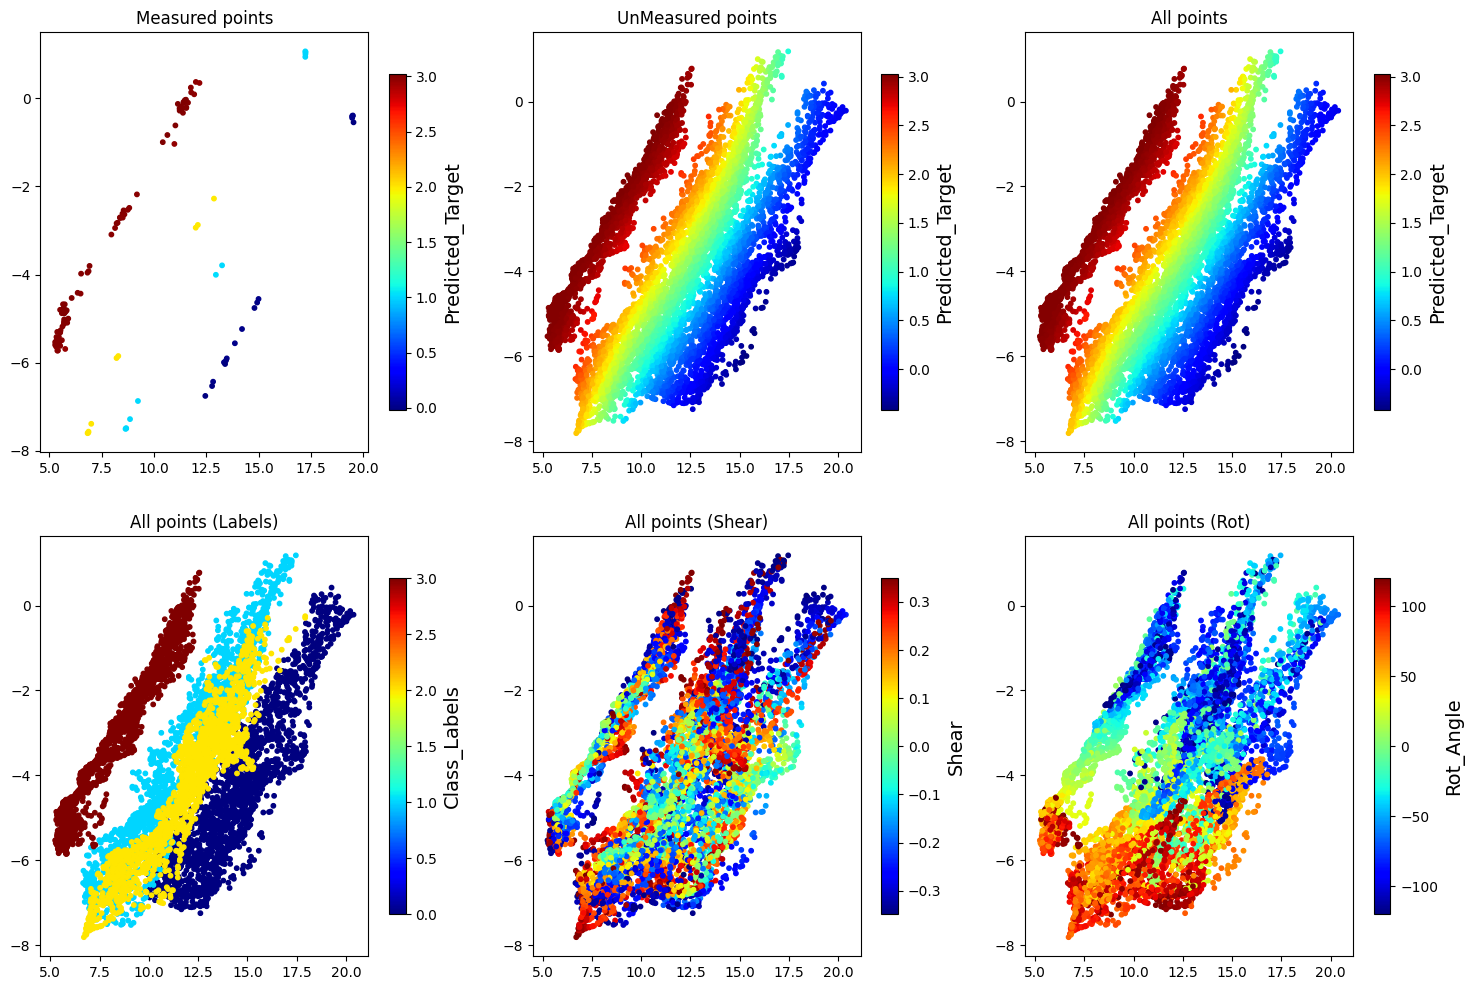

In [54]:
embeded_train4 = dkl_BO_4.embed(X4_train)  # Measured points
embeded_unmeasured4 = dkl_BO_4.embed(X4_unmeasured)  # Unmeasured points
embeded14 = dkl_BO_4.embed(X4)   # All points

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train4[:, 1], embeded_train4[:, 0], s=10, c = predmean_train4, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_unmeasured4[:, 1], embeded_unmeasured4[:, 0], s=10,
                c = predmean_unmeas4, cmap = 'jet')
ax[0,1].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded14[:, 1], embeded14[:, 0], s=10, c = predmean14, cmap = 'jet')
ax[0,2].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded14[:, 1], embeded14[:, 0], s=10, c = labels_all, cmap = 'jet')
ax[1,0].set_title('All points (Labels)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded14[:, 1], embeded14[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
ax[1,1].set_title('All points (Shear)')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded14[:, 1], embeded14[:, 0], s=10, c = angles_all, cmap = 'jet')
ax[1,2].set_title('All points (Rot)')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
cbar.set_label("Rot_Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)

ANd now you can see how the DKL learned the "card function" from lcubs to diamonds. Diamonds are set apart (as can be expected), spades and hearts are pretty close. Note that Rotational angles got disentangled for all hands.

# Card parameters as a function

Now, let's run the same analysis assuming that we want to learn the rotation or shear, but at teh same time we do not care about the specific hands. What happens then?

## Shear

In [55]:
X5 = np.copy(X)
targets5 = np.copy(shears_all[:,0])

rng_key_5, rng_key_predict_5 = gpax.utils.get_keys()
dkl_5 = gpax.viDKL(900, 2, 'RBF')
dkl_5.fit(rng_key_5, X5, targets5)

100%|██████████| 1000/1000 [03:47<00:00,  4.39it/s, init loss: 68841.5697, avg. loss [951-1000]: 45821.7993]



Inferred GP kernel parameters
k_length         [4.1387 2.7963]
k_scale          0.1948
noise            0.0083


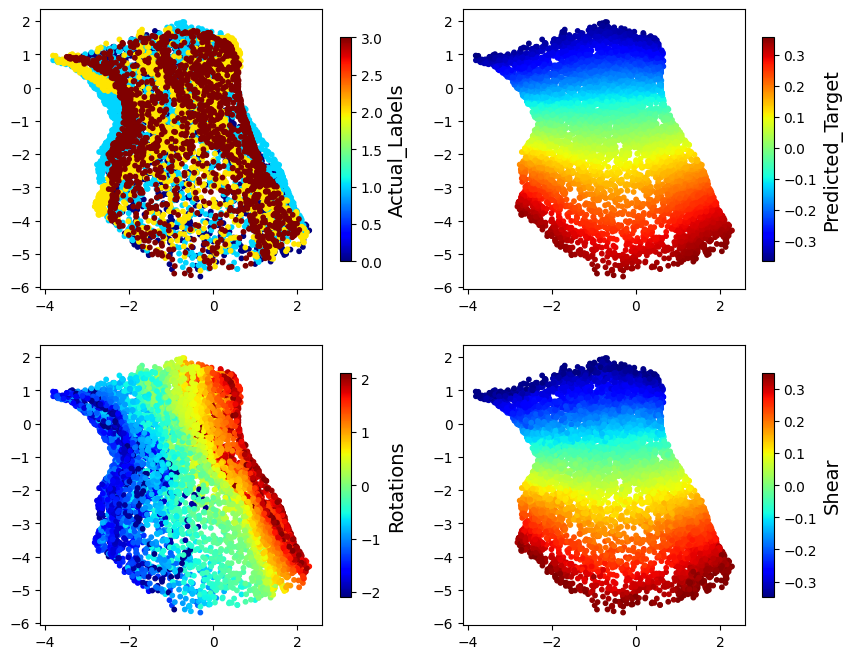

In [56]:
embeded_5 = dkl_5.embed(X5)
pred_mean5, pred_var5 = dkl_5.predict_in_batches(rng_key_predict_5, X5, batch_size=batch_size_reconstruct)
pred_std5 = jnp.sqrt(pred_var5)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c = pred_mean5, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c = torch.deg2rad(angles_all),
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_5[:, 1], embeded_5[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Now we see the DKL latent space when our goal was to learn the shear. Predicted target and ground truth look almost the same. Note that the hands overlap (we were not interested in them), and as a bonus we got rotations disentangled in direction perpendicular to the shear.

In [57]:
np.random.seed(0)
idx5 = np.random.choice(np.arange(len(X5)), size = init_num, replace = False)
X5_train = X5[idx5]
X5_unmeasured = np.delete(X5, idx5, axis=0)

indices_total_5 = np.arange(len(X))
indices_train_5 = indices_total_5[idx5]
y5_train = targets5[idx5]
indices_unmeasured_5 = np.delete(indices_total_5, idx5)

In [58]:
exp_mean5, exp_std5 = [], []
dkl_mean5, dkl_std5 = [], []
embed_traj5 = []
traj_mean5, traj_std5 = [], []

exploration_steps = exp_step


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key15, rng_key_predict15 = gpax.utils.get_keys()
    dkl_BO_5 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_5.fit(rng_key15, X5_train, y5_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_5.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict15, X5_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()

    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean5.append(y_mean[id_next])
    exp_std5.append(y_std[id_next])

    x_next = X5_unmeasured[id_next]
    ind_next = indices_unmeasured_5[id_next]

    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean5.append(pred_mean5[ind_next])
    dkl_std5.append(pred_std5[ind_next])

    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = targets5[ind_next]

    # Update training arrays
    X5_train = np.append(X5_train, x_next[None], axis=0)
    y5_train = np.append(y5_train, y_measured)
    X5_unmeasured = np.delete(X5_unmeasured, id_next, axis=0)
    indices_unmeasured_5 = np.delete(indices_unmeasured_5, id_next)

    embed_traj = dkl_BO_5.embed(X5_train)
    traj_m, traj_s = dkl_BO_5.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict15, X5_train, batch_size=batch_size_learn)

    embed_traj5.append(embed_traj)
    traj_mean5.append(traj_m)


Step 1


100%|██████████| 1000/1000 [00:02<00:00, 480.98it/s, init loss: 60100.1168, avg. loss [951-1000]: 56923.3976]



Inferred GP kernel parameters
k_length         [0.3667 0.3886]
k_scale          0.2778
noise            0.0146

Step 2


100%|██████████| 1000/1000 [00:02<00:00, 484.66it/s, init loss: 60101.3760, avg. loss [951-1000]: 56921.1632]



Inferred GP kernel parameters
k_length         [0.3678 0.3513]
k_scale          0.28550000000000003
noise            0.013900000000000001

Step 3


100%|██████████| 1000/1000 [00:02<00:00, 495.95it/s, init loss: 60102.6414, avg. loss [951-1000]: 56919.6532]



Inferred GP kernel parameters
k_length         [0.3593 0.371 ]
k_scale          0.2786
noise            0.013600000000000001

Step 4


100%|██████████| 1000/1000 [00:02<00:00, 472.56it/s, init loss: 60103.9172, avg. loss [951-1000]: 56918.2695]



Inferred GP kernel parameters
k_length         [0.3678 0.3549]
k_scale          0.28850000000000003
noise            0.0131

Step 5


100%|██████████| 1000/1000 [00:02<00:00, 491.52it/s, init loss: 60105.1412, avg. loss [951-1000]: 56917.9444]



Inferred GP kernel parameters
k_length         [0.3586 0.3852]
k_scale          0.28650000000000003
noise            0.0129

Step 6


100%|██████████| 1000/1000 [00:02<00:00, 480.33it/s, init loss: 60106.3821, avg. loss [951-1000]: 56916.2016]



Inferred GP kernel parameters
k_length         [0.3699 0.3646]
k_scale          0.28550000000000003
noise            0.0126

Step 7


100%|██████████| 1000/1000 [00:02<00:00, 486.18it/s, init loss: 60107.6523, avg. loss [951-1000]: 56914.6998]



Inferred GP kernel parameters
k_length         [0.3662 0.3543]
k_scale          0.2906
noise            0.0123

Step 8


100%|██████████| 1000/1000 [00:02<00:00, 488.18it/s, init loss: 60108.9268, avg. loss [951-1000]: 56924.2886]



Inferred GP kernel parameters
k_length         [0.4279 0.4   ]
k_scale          0.20400000000000001
noise            0.0132

Step 9


100%|██████████| 1000/1000 [00:02<00:00, 491.03it/s, init loss: 60110.1830, avg. loss [951-1000]: 56912.0011]



Inferred GP kernel parameters
k_length         [0.3665 0.3698]
k_scale          0.2864
noise            0.0119

Step 10


100%|██████████| 1000/1000 [00:04<00:00, 231.53it/s, init loss: 60111.4505, avg. loss [951-1000]: 56914.1595]



Inferred GP kernel parameters
k_length         [0.4379 0.4129]
k_scale          0.2664
noise            0.0119

Step 11


100%|██████████| 1000/1000 [00:02<00:00, 488.41it/s, init loss: 60112.7143, avg. loss [951-1000]: 56909.6159]



Inferred GP kernel parameters
k_length         [0.3676 0.365 ]
k_scale          0.2949
noise            0.0115

Step 12


100%|██████████| 1000/1000 [00:02<00:00, 486.21it/s, init loss: 60113.9876, avg. loss [951-1000]: 56908.3655]



Inferred GP kernel parameters
k_length         [0.3502 0.3668]
k_scale          0.2556
noise            0.0119

Step 13


100%|██████████| 1000/1000 [00:02<00:00, 495.31it/s, init loss: 60115.2522, avg. loss [951-1000]: 56910.5634]



Inferred GP kernel parameters
k_length         [0.3999 0.3694]
k_scale          0.27340000000000003
noise            0.0117

Step 14


100%|██████████| 1000/1000 [00:02<00:00, 478.11it/s, init loss: 60116.5217, avg. loss [951-1000]: 56905.4225]



Inferred GP kernel parameters
k_length         [0.3483 0.3668]
k_scale          0.2952
noise            0.011000000000000001

Step 15


100%|██████████| 1000/1000 [00:02<00:00, 473.69it/s, init loss: 60117.7663, avg. loss [951-1000]: 56906.1711]



Inferred GP kernel parameters
k_length         [0.3656 0.389 ]
k_scale          0.28600000000000003
noise            0.0112

Step 16


100%|██████████| 1000/1000 [00:02<00:00, 472.70it/s, init loss: 60118.9938, avg. loss [951-1000]: 56907.1210]



Inferred GP kernel parameters
k_length         [0.3924 0.4071]
k_scale          0.28040000000000004
noise            0.0112

Step 17


100%|██████████| 1000/1000 [00:02<00:00, 478.73it/s, init loss: 60120.2691, avg. loss [951-1000]: 56903.2101]



Inferred GP kernel parameters
k_length         [0.373  0.3812]
k_scale          0.2867
noise            0.011000000000000001

Step 18


100%|██████████| 1000/1000 [00:02<00:00, 471.58it/s, init loss: 60121.5303, avg. loss [951-1000]: 56907.8654]



Inferred GP kernel parameters
k_length         [0.4024 0.4994]
k_scale          0.2553
noise            0.0111

Step 19


100%|██████████| 1000/1000 [00:02<00:00, 472.09it/s, init loss: 60122.7635, avg. loss [951-1000]: 56900.1905]



Inferred GP kernel parameters
k_length         [0.3752 0.3721]
k_scale          0.2889
noise            0.010400000000000001

Step 20


100%|██████████| 1000/1000 [00:02<00:00, 475.33it/s, init loss: 60124.0307, avg. loss [951-1000]: 56900.6978]



Inferred GP kernel parameters
k_length         [0.4243 0.3867]
k_scale          0.2775
noise            0.010700000000000001

Step 21


100%|██████████| 1000/1000 [00:02<00:00, 478.65it/s, init loss: 60125.2622, avg. loss [951-1000]: 56896.2180]



Inferred GP kernel parameters
k_length         [0.3678 0.3679]
k_scale          0.2903
noise            0.0103

Step 22


100%|██████████| 1000/1000 [00:02<00:00, 479.04it/s, init loss: 60126.4726, avg. loss [951-1000]: 56902.2571]



Inferred GP kernel parameters
k_length         [0.3498 0.3407]
k_scale          0.21860000000000002
noise            0.011000000000000001

Step 23


100%|██████████| 1000/1000 [00:02<00:00, 470.83it/s, init loss: 60127.6673, avg. loss [951-1000]: 56896.9087]



Inferred GP kernel parameters
k_length         [0.3966 0.404 ]
k_scale          0.28600000000000003
noise            0.0103

Step 24


100%|██████████| 1000/1000 [00:02<00:00, 474.97it/s, init loss: 60128.9434, avg. loss [951-1000]: 56892.9429]



Inferred GP kernel parameters
k_length         [0.4064 0.396 ]
k_scale          0.2823
noise            0.0103

Step 25


100%|██████████| 1000/1000 [00:02<00:00, 473.83it/s, init loss: 60130.2187, avg. loss [951-1000]: 56891.0664]



Inferred GP kernel parameters
k_length         [0.3656 0.3679]
k_scale          0.29450000000000004
noise            0.010100000000000001

Step 26


100%|██████████| 1000/1000 [00:02<00:00, 469.99it/s, init loss: 60131.4838, avg. loss [951-1000]: 56889.1208]



Inferred GP kernel parameters
k_length         [0.3453 0.3679]
k_scale          0.2948
noise            0.01

Step 27


100%|██████████| 1000/1000 [00:02<00:00, 480.97it/s, init loss: 60132.7525, avg. loss [951-1000]: 56888.4240]



Inferred GP kernel parameters
k_length         [0.3713 0.3679]
k_scale          0.2938
noise            0.0099

Step 28


100%|██████████| 1000/1000 [00:02<00:00, 473.77it/s, init loss: 60134.0101, avg. loss [951-1000]: 56897.9353]



Inferred GP kernel parameters
k_length         [0.4341 0.4496]
k_scale          0.25270000000000004
noise            0.010400000000000001

Step 29


100%|██████████| 1000/1000 [00:02<00:00, 466.99it/s, init loss: 60135.2822, avg. loss [951-1000]: 56889.5307]



Inferred GP kernel parameters
k_length         [0.4657 0.4601]
k_scale          0.2645
noise            0.01

Step 30


100%|██████████| 1000/1000 [00:02<00:00, 462.01it/s, init loss: 60136.4467, avg. loss [951-1000]: 56886.6413]



Inferred GP kernel parameters
k_length         [0.3996 0.3864]
k_scale          0.27540000000000003
noise            0.010100000000000001

Step 31


100%|██████████| 1000/1000 [00:02<00:00, 465.10it/s, init loss: 60137.7047, avg. loss [951-1000]: 56890.4421]



Inferred GP kernel parameters
k_length         [0.3196 0.3679]
k_scale          0.2006
noise            0.0108

Step 32


100%|██████████| 1000/1000 [00:02<00:00, 469.53it/s, init loss: 60138.9621, avg. loss [951-1000]: 56894.2827]



Inferred GP kernel parameters
k_length         [0.3791 0.3799]
k_scale          0.21330000000000002
noise            0.0106

Step 33


100%|██████████| 1000/1000 [00:02<00:00, 469.47it/s, init loss: 60140.1474, avg. loss [951-1000]: 56882.1027]



Inferred GP kernel parameters
k_length         [0.3696 0.3747]
k_scale          0.27240000000000003
noise            0.01

Step 34


100%|██████████| 1000/1000 [00:02<00:00, 473.02it/s, init loss: 60141.4066, avg. loss [951-1000]: 56881.6836]



Inferred GP kernel parameters
k_length         [0.3754 0.3679]
k_scale          0.2685
noise            0.0102

Step 35


100%|██████████| 1000/1000 [00:02<00:00, 462.12it/s, init loss: 60142.6559, avg. loss [951-1000]: 56886.4939]



Inferred GP kernel parameters
k_length         [0.3354 0.3679]
k_scale          0.20140000000000002
noise            0.010700000000000001

Step 36


100%|██████████| 1000/1000 [00:02<00:00, 462.52it/s, init loss: 60143.8568, avg. loss [951-1000]: 56877.7113]



Inferred GP kernel parameters
k_length         [0.3877 0.3927]
k_scale          0.2702
noise            0.0099

Step 37


100%|██████████| 1000/1000 [00:02<00:00, 467.05it/s, init loss: 60145.0510, avg. loss [951-1000]: 56884.8403]



Inferred GP kernel parameters
k_length         [0.414  0.4151]
k_scale          0.23750000000000002
noise            0.0109

Step 38


100%|██████████| 1000/1000 [00:02<00:00, 468.29it/s, init loss: 60146.3254, avg. loss [951-1000]: 56883.9539]



Inferred GP kernel parameters
k_length         [0.3369 0.3721]
k_scale          0.2318
noise            0.010400000000000001

Step 39


100%|██████████| 1000/1000 [00:02<00:00, 476.08it/s, init loss: 60147.5998, avg. loss [951-1000]: 56878.0973]



Inferred GP kernel parameters
k_length         [0.3492 0.368 ]
k_scale          0.2757
noise            0.0098

Step 40


100%|██████████| 1000/1000 [00:02<00:00, 484.50it/s, init loss: 60148.8596, avg. loss [951-1000]: 56872.5536]



Inferred GP kernel parameters
k_length         [0.4144 0.3998]
k_scale          0.26180000000000003
noise            0.009600000000000001

Step 41


100%|██████████| 1000/1000 [00:02<00:00, 475.57it/s, init loss: 60150.0966, avg. loss [951-1000]: 56876.6706]



Inferred GP kernel parameters
k_length         [0.4526 0.498 ]
k_scale          0.2124
noise            0.010400000000000001

Step 42


100%|██████████| 1000/1000 [00:02<00:00, 482.93it/s, init loss: 60151.3142, avg. loss [951-1000]: 56875.6168]



Inferred GP kernel parameters
k_length         [0.3634 0.3466]
k_scale          0.2675
noise            0.01

Step 43


100%|██████████| 1000/1000 [00:02<00:00, 478.92it/s, init loss: 60152.5845, avg. loss [951-1000]: 56869.0232]



Inferred GP kernel parameters
k_length         [0.3774 0.3683]
k_scale          0.2595
noise            0.0097

Step 44


100%|██████████| 1000/1000 [00:02<00:00, 464.97it/s, init loss: 60153.8584, avg. loss [951-1000]: 56885.5744]



Inferred GP kernel parameters
k_length         [0.3447 0.3797]
k_scale          0.1751
noise            0.011000000000000001

Step 45


100%|██████████| 1000/1000 [00:02<00:00, 455.44it/s, init loss: 60155.0613, avg. loss [951-1000]: 56873.7288]



Inferred GP kernel parameters
k_length         [0.3646 0.3578]
k_scale          0.2447
noise            0.01

Step 46


100%|██████████| 1000/1000 [00:02<00:00, 458.56it/s, init loss: 60156.3320, avg. loss [951-1000]: 56869.8078]



Inferred GP kernel parameters
k_length         [0.44  0.543]
k_scale          0.2325
noise            0.0099

Step 47


100%|██████████| 1000/1000 [00:02<00:00, 447.21it/s, init loss: 60157.6031, avg. loss [951-1000]: 56864.2261]



Inferred GP kernel parameters
k_length         [0.3742 0.378 ]
k_scale          0.2569
noise            0.0095

Step 48


100%|██████████| 1000/1000 [00:02<00:00, 458.05it/s, init loss: 60158.8805, avg. loss [951-1000]: 56872.3389]



Inferred GP kernel parameters
k_length         [0.3551 0.3925]
k_scale          0.1943
noise            0.0102

Step 49


100%|██████████| 1000/1000 [00:02<00:00, 461.04it/s, init loss: 60160.0367, avg. loss [951-1000]: 56862.8720]



Inferred GP kernel parameters
k_length         [0.3809 0.3676]
k_scale          0.2823
noise            0.0095

Step 50


100%|██████████| 1000/1000 [00:02<00:00, 458.19it/s, init loss: 60161.2372, avg. loss [951-1000]: 56868.6169]



Inferred GP kernel parameters
k_length         [0.3925 0.368 ]
k_scale          0.22360000000000002
noise            0.010100000000000001

Step 51


100%|██████████| 1000/1000 [00:02<00:00, 467.22it/s, init loss: 60162.5126, avg. loss [951-1000]: 56864.5112]



Inferred GP kernel parameters
k_length         [0.3433 0.3657]
k_scale          0.2124
noise            0.0098

Step 52


100%|██████████| 1000/1000 [00:02<00:00, 460.72it/s, init loss: 60163.7864, avg. loss [951-1000]: 56860.7169]



Inferred GP kernel parameters
k_length         [0.3992 0.438 ]
k_scale          0.2389
noise            0.009600000000000001

Step 53


100%|██████████| 1000/1000 [00:02<00:00, 464.36it/s, init loss: 60164.9665, avg. loss [951-1000]: 56869.6377]



Inferred GP kernel parameters
k_length         [0.3463 0.382 ]
k_scale          0.182
noise            0.0102

Step 54


100%|██████████| 1000/1000 [00:02<00:00, 472.69it/s, init loss: 60166.2227, avg. loss [951-1000]: 56861.7474]



Inferred GP kernel parameters
k_length         [0.4056 0.4149]
k_scale          0.24860000000000002
noise            0.0097

Step 55


100%|██████████| 1000/1000 [00:02<00:00, 465.09it/s, init loss: 60167.4632, avg. loss [951-1000]: 56861.5274]



Inferred GP kernel parameters
k_length         [0.3834 0.397 ]
k_scale          0.1791
noise            0.0103

Step 56


100%|██████████| 1000/1000 [00:02<00:00, 467.08it/s, init loss: 60168.7121, avg. loss [951-1000]: 56860.9001]



Inferred GP kernel parameters
k_length         [0.323  0.3689]
k_scale          0.1993
noise            0.01

Step 57


100%|██████████| 1000/1000 [00:02<00:00, 466.83it/s, init loss: 60169.9873, avg. loss [951-1000]: 56860.7673]



Inferred GP kernel parameters
k_length         [0.3479 0.3495]
k_scale          0.1738
noise            0.010100000000000001

Step 58


100%|██████████| 1000/1000 [00:02<00:00, 466.60it/s, init loss: 60171.2274, avg. loss [951-1000]: 56853.4362]



Inferred GP kernel parameters
k_length         [0.3309 0.3655]
k_scale          0.224
noise            0.009600000000000001

Step 59


100%|██████████| 1000/1000 [00:02<00:00, 461.87it/s, init loss: 60172.4853, avg. loss [951-1000]: 56855.3506]



Inferred GP kernel parameters
k_length         [0.4624 0.4662]
k_scale          0.23040000000000002
noise            0.0099

Step 60


100%|██████████| 1000/1000 [00:02<00:00, 467.69it/s, init loss: 60173.7427, avg. loss [951-1000]: 56866.1751]



Inferred GP kernel parameters
k_length         [0.4275 0.546 ]
k_scale          0.1274
noise            0.0106

Step 61


100%|██████████| 1000/1000 [00:02<00:00, 459.23it/s, init loss: 60175.0161, avg. loss [951-1000]: 56848.0546]



Inferred GP kernel parameters
k_length         [0.404 0.4  ]
k_scale          0.2492
noise            0.009600000000000001

Step 62


100%|██████████| 1000/1000 [00:02<00:00, 458.45it/s, init loss: 60176.2861, avg. loss [951-1000]: 56864.8859]



Inferred GP kernel parameters
k_length         [0.4811 0.3992]
k_scale          0.15810000000000002
noise            0.0103

Step 63


100%|██████████| 1000/1000 [00:02<00:00, 460.28it/s, init loss: 60177.5568, avg. loss [951-1000]: 56848.9442]



Inferred GP kernel parameters
k_length         [0.389  0.4612]
k_scale          0.2232
noise            0.0095

Step 64


100%|██████████| 1000/1000 [00:02<00:00, 462.43it/s, init loss: 60178.7934, avg. loss [951-1000]: 56869.1223]



Inferred GP kernel parameters
k_length         [0.6183 0.522 ]
k_scale          0.12840000000000001
noise            0.010700000000000001

Step 65


100%|██████████| 1000/1000 [00:02<00:00, 469.98it/s, init loss: 60180.0524, avg. loss [951-1000]: 56843.3616]



Inferred GP kernel parameters
k_length         [0.3335 0.3678]
k_scale          0.21930000000000002
noise            0.0094

Step 66


100%|██████████| 1000/1000 [00:02<00:00, 460.05it/s, init loss: 60181.3020, avg. loss [951-1000]: 56842.7710]



Inferred GP kernel parameters
k_length         [0.459  0.4469]
k_scale          0.23170000000000002
noise            0.0095

Step 67


100%|██████████| 1000/1000 [00:02<00:00, 466.32it/s, init loss: 60182.5126, avg. loss [951-1000]: 56844.0515]



Inferred GP kernel parameters
k_length         [0.3501 0.3895]
k_scale          0.2121
noise            0.0095

Step 68


100%|██████████| 1000/1000 [00:02<00:00, 468.68it/s, init loss: 60183.7016, avg. loss [951-1000]: 56841.2376]



Inferred GP kernel parameters
k_length         [0.3521 0.3585]
k_scale          0.2066
noise            0.0095

Step 69


100%|██████████| 1000/1000 [00:02<00:00, 460.73it/s, init loss: 60184.9674, avg. loss [951-1000]: 56854.0499]



Inferred GP kernel parameters
k_length         [0.4452 0.5316]
k_scale          0.19410000000000002
noise            0.0098

Step 70


100%|██████████| 1000/1000 [00:02<00:00, 452.30it/s, init loss: 60186.2190, avg. loss [951-1000]: 56848.4120]



Inferred GP kernel parameters
k_length         [0.4328 0.4336]
k_scale          0.2116
noise            0.0095

Step 71


100%|██████████| 1000/1000 [00:02<00:00, 463.03it/s, init loss: 60187.4145, avg. loss [951-1000]: 56830.9615]



Inferred GP kernel parameters
k_length         [0.4103 0.3757]
k_scale          0.28
noise            0.0092

Step 72


100%|██████████| 1000/1000 [00:02<00:00, 450.83it/s, init loss: 60188.6569, avg. loss [951-1000]: 56833.9178]



Inferred GP kernel parameters
k_length         [0.4219 0.4148]
k_scale          0.234
noise            0.0094

Step 73


100%|██████████| 1000/1000 [00:02<00:00, 460.10it/s, init loss: 60189.9175, avg. loss [951-1000]: 56837.9105]



Inferred GP kernel parameters
k_length         [0.4114 0.3798]
k_scale          0.1991
noise            0.0097

Step 74


100%|██████████| 1000/1000 [00:02<00:00, 470.56it/s, init loss: 60191.1901, avg. loss [951-1000]: 56845.3294]



Inferred GP kernel parameters
k_length         [0.3979 0.3904]
k_scale          0.2323
noise            0.0098

Step 75


100%|██████████| 1000/1000 [00:02<00:00, 446.74it/s, init loss: 60192.4255, avg. loss [951-1000]: 56831.2953]



Inferred GP kernel parameters
k_length         [0.3795 0.352 ]
k_scale          0.21130000000000002
noise            0.0094

Step 76


100%|██████████| 1000/1000 [00:02<00:00, 452.70it/s, init loss: 60193.5772, avg. loss [951-1000]: 56858.7923]



Inferred GP kernel parameters
k_length         [0.4453 0.6557]
k_scale          0.1472
noise            0.0098

Step 77


100%|██████████| 1000/1000 [00:02<00:00, 463.06it/s, init loss: 60194.8007, avg. loss [951-1000]: 56847.8175]



Inferred GP kernel parameters
k_length         [0.7811 0.7561]
k_scale          0.1327
noise            0.0108

Step 78


100%|██████████| 1000/1000 [00:02<00:00, 464.29it/s, init loss: 60196.0735, avg. loss [951-1000]: 56833.4382]



Inferred GP kernel parameters
k_length         [0.422  0.4209]
k_scale          0.2093
noise            0.009600000000000001

Step 79


100%|██████████| 1000/1000 [00:02<00:00, 460.09it/s, init loss: 60197.3404, avg. loss [951-1000]: 56831.4803]



Inferred GP kernel parameters
k_length         [0.542 0.52 ]
k_scale          0.1834
noise            0.009600000000000001

Step 80


100%|██████████| 1000/1000 [00:02<00:00, 463.67it/s, init loss: 60198.5995, avg. loss [951-1000]: 56830.0832]



Inferred GP kernel parameters
k_length         [0.4239 0.4188]
k_scale          0.2039
noise            0.009600000000000001

Step 81


100%|██████████| 1000/1000 [00:02<00:00, 458.84it/s, init loss: 60199.8472, avg. loss [951-1000]: 56826.2855]



Inferred GP kernel parameters
k_length         [0.3446 0.3526]
k_scale          0.2089
noise            0.0094

Step 82


100%|██████████| 1000/1000 [00:02<00:00, 455.13it/s, init loss: 60201.1004, avg. loss [951-1000]: 56826.9737]



Inferred GP kernel parameters
k_length         [0.3895 0.3398]
k_scale          0.2101
noise            0.009300000000000001

Step 83


100%|██████████| 1000/1000 [00:02<00:00, 457.86it/s, init loss: 60202.2752, avg. loss [951-1000]: 56815.7314]



Inferred GP kernel parameters
k_length         [0.4776 0.4806]
k_scale          0.2716
noise            0.0091

Step 84


100%|██████████| 1000/1000 [00:02<00:00, 445.36it/s, init loss: 60203.4616, avg. loss [951-1000]: 56821.2292]



Inferred GP kernel parameters
k_length         [0.5223 0.4775]
k_scale          0.20700000000000002
noise            0.0095

Step 85


100%|██████████| 1000/1000 [00:02<00:00, 459.83it/s, init loss: 60204.7262, avg. loss [951-1000]: 56811.4916]



Inferred GP kernel parameters
k_length         [0.4332 0.4438]
k_scale          0.2622
noise            0.009000000000000001

Step 86


100%|██████████| 1000/1000 [00:02<00:00, 467.11it/s, init loss: 60205.9943, avg. loss [951-1000]: 56822.0404]



Inferred GP kernel parameters
k_length         [0.4366 0.4337]
k_scale          0.2016
noise            0.0097

Step 87


100%|██████████| 1000/1000 [00:02<00:00, 471.27it/s, init loss: 60207.2525, avg. loss [951-1000]: 56814.2744]



Inferred GP kernel parameters
k_length         [0.4791 0.4869]
k_scale          0.24810000000000001
noise            0.009300000000000001

Step 88


100%|██████████| 1000/1000 [00:02<00:00, 461.39it/s, init loss: 60208.4751, avg. loss [951-1000]: 56828.2405]



Inferred GP kernel parameters
k_length         [0.4084 0.386 ]
k_scale          0.23420000000000002
noise            0.0099

Step 89


100%|██████████| 1000/1000 [00:02<00:00, 457.57it/s, init loss: 60209.7382, avg. loss [951-1000]: 56809.5533]



Inferred GP kernel parameters
k_length         [0.3728 0.4035]
k_scale          0.24500000000000002
noise            0.009000000000000001

Step 90


100%|██████████| 1000/1000 [00:02<00:00, 459.81it/s, init loss: 60210.9295, avg. loss [951-1000]: 56827.3246]



Inferred GP kernel parameters
k_length         [0.4821 0.4265]
k_scale          0.18960000000000002
noise            0.009600000000000001

Step 91


100%|██████████| 1000/1000 [00:02<00:00, 455.34it/s, init loss: 60212.2059, avg. loss [951-1000]: 56812.6626]



Inferred GP kernel parameters
k_length         [0.5421 0.616 ]
k_scale          0.19160000000000002
noise            0.009600000000000001

Step 92


100%|██████████| 1000/1000 [00:02<00:00, 460.96it/s, init loss: 60213.4812, avg. loss [951-1000]: 56832.3466]



Inferred GP kernel parameters
k_length         [0.6379 0.5375]
k_scale          0.21630000000000002
noise            0.0094

Step 93


100%|██████████| 1000/1000 [00:02<00:00, 462.60it/s, init loss: 60214.7455, avg. loss [951-1000]: 56817.4138]



Inferred GP kernel parameters
k_length         [0.4507 0.4517]
k_scale          0.20850000000000002
noise            0.009300000000000001

Step 94


100%|██████████| 1000/1000 [00:02<00:00, 452.64it/s, init loss: 60215.9735, avg. loss [951-1000]: 56818.3272]



Inferred GP kernel parameters
k_length         [0.3507 0.4543]
k_scale          0.2159
noise            0.0097

Step 95


100%|██████████| 1000/1000 [00:02<00:00, 447.99it/s, init loss: 60217.1367, avg. loss [951-1000]: 56804.9244]



Inferred GP kernel parameters
k_length         [0.5646 0.4725]
k_scale          0.1882
noise            0.0094

Step 96


100%|██████████| 1000/1000 [00:02<00:00, 452.84it/s, init loss: 60218.3927, avg. loss [951-1000]: 56803.0581]



Inferred GP kernel parameters
k_length         [0.6207 0.5821]
k_scale          0.21350000000000002
noise            0.009300000000000001

Step 97


100%|██████████| 1000/1000 [00:02<00:00, 462.22it/s, init loss: 60219.6497, avg. loss [951-1000]: 56797.2273]



Inferred GP kernel parameters
k_length         [0.3843 0.3976]
k_scale          0.2549
noise            0.0089

Step 98


100%|██████████| 1000/1000 [00:02<00:00, 446.14it/s, init loss: 60220.8878, avg. loss [951-1000]: 56804.6297]



Inferred GP kernel parameters
k_length         [0.3915 0.431 ]
k_scale          0.2482
noise            0.0095

Step 99


100%|██████████| 1000/1000 [00:02<00:00, 457.41it/s, init loss: 60222.0633, avg. loss [951-1000]: 56812.5506]



Inferred GP kernel parameters
k_length         [0.6057 0.4976]
k_scale          0.21580000000000002
noise            0.009600000000000001

Step 100


100%|██████████| 1000/1000 [00:02<00:00, 467.87it/s, init loss: 60223.3347, avg. loss [951-1000]: 56799.5690]



Inferred GP kernel parameters
k_length         [0.6049 0.5594]
k_scale          0.23650000000000002
noise            0.0091


In [59]:
shear_results = {}
shear_results['X_train'] = X5_train
shear_results['y_train'] = y5_train
shear_results['X_unmeasured'] = X5_unmeasured
shear_results['indices_unmeasured'] = indices_unmeasured_5
shear_results['dkl_mean'] = dkl_mean5
shear_results['dkl_std'] = dkl_std5
shear_results['exp_mean'] = exp_mean5
shear_results['exp_std'] = exp_std5
shear_results['traj_mean'] = traj_mean5
shear_results['traj_std'] = traj_std5
shear_results['embed_traj'] = embed_traj5

with open('shear_results.pickle', 'wb') as handle:
    pickle.dump(shear_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [60]:
with open('shear_results.pickle', 'rb') as f:
    shear_results = pickle.load(f)

X5_train = shear_results['X_train']
y5_train = shear_results['y_train']
X5_unmeasured = shear_results['X_unmeasured']
indices_unmeasured_5 = shear_results['indices_unmeasured']
dkl_mean5 = shear_results['dkl_mean']
dkl_std5 = shear_results['dkl_std']
exp_mean5 = shear_results['exp_mean']
exp_std5 = shear_results['exp_std']
traj_mean5 = shear_results['traj_mean']
traj_std5 = shear_results['traj_std']
embed_traj5 = shear_results['embed_traj']

In [61]:
rng_key15, rng_key_predict15 = gpax.utils.get_keys()
dkl_BO_5 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_5.fit(rng_key15, X5_train, y5_train)

predmean_train5, predstd_train5 = dkl_BO_5.predict_in_batches(rng_key_predict15, X5_train, batch_size=batch_size_learn)
predmean_unmeas5, predstd_unmeas5 = dkl_BO_5.predict_in_batches(rng_key_predict15, X5_unmeasured, batch_size=batch_size_reconstruct)
predmean15, predstd15 = dkl_BO_5.predict_in_batches(rng_key_predict15, X5, batch_size=batch_size_reconstruct)

100%|██████████| 1000/1000 [00:02<00:00, 448.46it/s, init loss: 60224.4916, avg. loss [951-1000]: 56822.1435]



Inferred GP kernel parameters
k_length         [0.5442 0.4851]
k_scale          0.17300000000000001
noise            0.009600000000000001


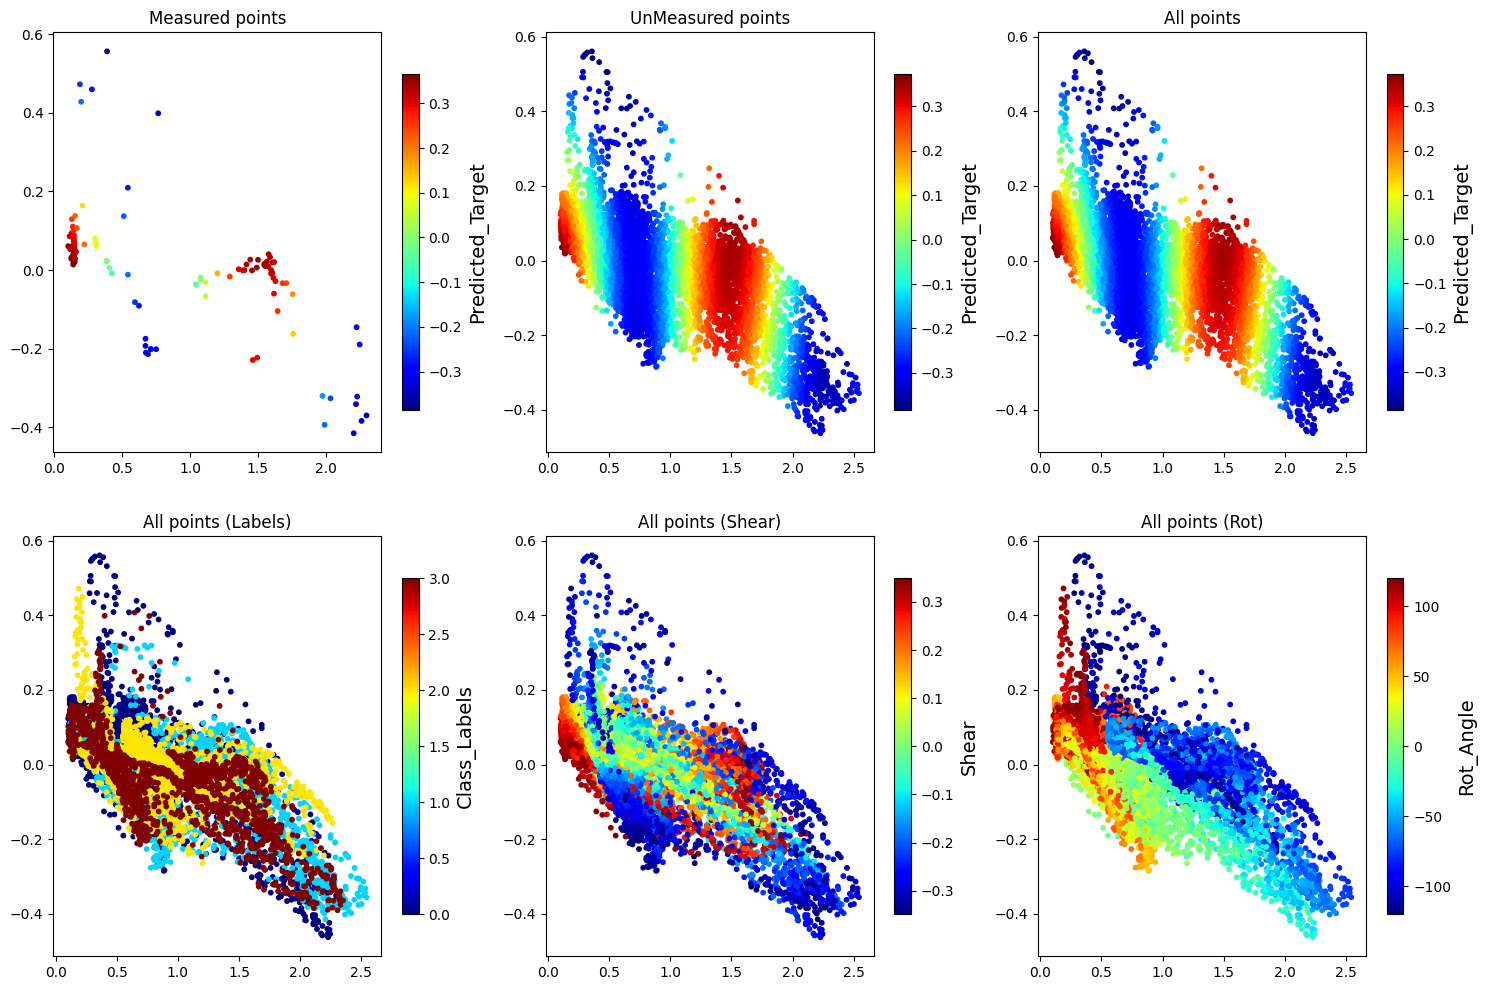

In [62]:
embeded_train5 = dkl_BO_5.embed(X5_train)  # Measured points
embeded_unmeasured5 = dkl_BO_5.embed(X5_unmeasured)  # Unmeasured points
embeded15 = dkl_BO_5.embed(X5)   # All points

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train5[:, 1], embeded_train5[:, 0], s=10, c = predmean_train5, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_unmeasured5[:, 1], embeded_unmeasured5[:, 0], s=10,
                c = predmean_unmeas5, cmap = 'jet')
ax[0,1].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded15[:, 1], embeded15[:, 0], s=10, c = predmean15, cmap = 'jet')
ax[0,2].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded15[:, 1], embeded15[:, 0], s=10, c = labels_all, cmap = 'jet')
ax[1,0].set_title('All points (Labels)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded15[:, 1], embeded15[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
ax[1,1].set_title('All points (Shear)')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded15[:, 1], embeded15[:, 0], s=10, c = angles_all, cmap = 'jet')
ax[1,2].set_title('All points (Rot)')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
cbar.set_label("Rot_Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)

And now we have done it as active learning. NOte that in this case the predicted targets form two regions in latent space. So, th elatent distirbution is much better behaved then for VAE, but not as good as for the full DKL. Still, we learned only with 1% of the data.

## Rotations

In [63]:
targets6 = np.copy(angles_all)

rng_key_6, rng_key_predict_6 = gpax.utils.get_keys()
dkl_6 = gpax.viDKL(900, 2, 'RBF')
dkl_6.fit(rng_key_6, X, targets6)

100%|██████████| 1000/1000 [03:48<00:00,  4.38it/s, init loss: 12825723.0869, avg. loss [951-1000]: 87448.8247]



Inferred GP kernel parameters
k_length         [2.2328 1.6335]
k_scale          1.8513000000000002
noise            1.459


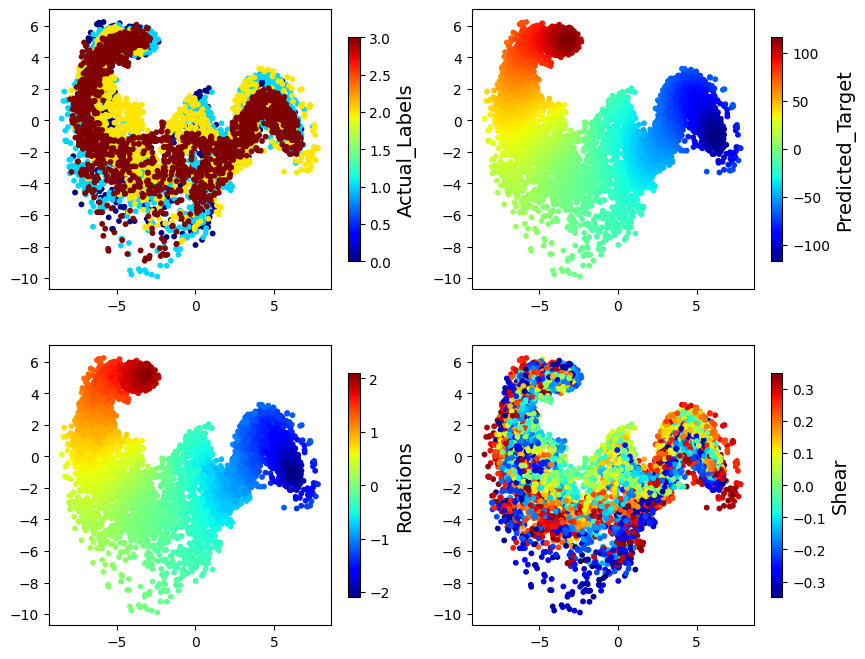

In [64]:
embeded_6 = dkl_6.embed(X)
pred_mean6, pred_var6 = dkl_6.predict_in_batches(rng_key_predict_6, X, batch_size=batch_size_reconstruct)
pred_std6 = jnp.sqrt(pred_var6)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_6[:, 1], embeded_6[:, 0], s=10, c = labels_all, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_6[:, 1], embeded_6[:, 0], s=10, c = pred_mean6, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_6[:, 1], embeded_6[:, 0], s=10, c = torch.deg2rad(angles_all),
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Rotations", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_6[:, 1], embeded_6[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

In [65]:
X6 = np.copy(X)
np.random.seed(0)
idx6 = np.random.choice(np.arange(len(X6)), size = init_num, replace = False)
X6_train = X6[idx6]
X6_unmeasured = np.delete(X6, idx6, axis=0)

indices_total_6 = np.arange(len(X))
indices_train_6 = indices_total_6[idx6]
y6_train = targets6[idx6]
indices_unmeasured_6 = np.delete(indices_total_6, idx6)

In [66]:
exp_mean6, exp_std6 = [], []
dkl_mean6, dkl_std6 = [], []
embed_traj6 = []
traj_mean6, traj_std6 = [], []

exploration_steps = exp_step


for e in range(exploration_steps):
    print("\nStep {}".format(e+1))
    # Obtain/update DKL posterior
    rng_key16, rng_key_predict16 = gpax.utils.get_keys()
    dkl_BO_6 = gpax.viDKL(900, 2, 'RBF')
    dkl_BO_6.fit(rng_key16, X6_train, y6_train)
    # Compute acqusition function
    y_mean, y_var = dkl_BO_6.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict16, X6_unmeasured, batch_size=250)
    y_std = jnp.sqrt(y_var)
    obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    # Get the next point to evaluate
    id_next = obj.argmax()

    # let's get the mean and std of the next point predicted by dkl_BO
    exp_mean6.append(y_mean[id_next])
    exp_std6.append(y_std[id_next])

    x_next = X6_unmeasured[id_next]
    ind_next = indices_unmeasured_6[id_next]

    # Getting the mean and std of the next point as predicted by the dkl trained on the full dataset
    dkl_mean6.append(pred_mean6[ind_next])
    dkl_std6.append(pred_std6[ind_next])

    # Perform evaluation
#     y_measured = eval_ferrosim(x_next)
    # For now we will only read out the brute force results
    y_measured = targets6[ind_next]

    # Update training arrays
    X6_train = np.append(X6_train, x_next[None], axis=0)
    y6_train = np.append(y6_train, y_measured)
    X6_unmeasured = np.delete(X6_unmeasured, id_next, axis=0)
    indices_unmeasured_6 = np.delete(indices_unmeasured_6, id_next)

    embed_traj = dkl_BO_6.embed(X6_train)
    traj_m, traj_s = dkl_BO_6.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
        rng_key_predict16, X6_train, batch_size=batch_size_learn)

    embed_traj6.append(embed_traj)
    traj_mean6.append(traj_m)


Step 1


100%|██████████| 1000/1000 [00:01<00:00, 501.54it/s, init loss: 82777.5575, avg. loss [951-1000]: 59574.8532]



Inferred GP kernel parameters
k_length         [1.1086 0.7912]
k_scale          8.142900000000001
noise            14.4109

Step 2


100%|██████████| 1000/1000 [00:02<00:00, 498.20it/s, init loss: 84967.5317, avg. loss [951-1000]: 59794.4099]



Inferred GP kernel parameters
k_length         [1.1305 0.8218]
k_scale          8.1797
noise            14.353900000000001

Step 3


100%|██████████| 1000/1000 [00:02<00:00, 492.04it/s, init loss: 88465.9312, avg. loss [951-1000]: 60316.7356]



Inferred GP kernel parameters
k_length         [1.3565 1.0645]
k_scale          8.4697
noise            13.9555

Step 4


100%|██████████| 1000/1000 [00:02<00:00, 491.43it/s, init loss: 89066.6530, avg. loss [951-1000]: 59435.9468]



Inferred GP kernel parameters
k_length         [2.3776 2.6351]
k_scale          8.635
noise            7.364000000000001

Step 5


100%|██████████| 1000/1000 [00:02<00:00, 482.35it/s, init loss: 89072.1551, avg. loss [951-1000]: 60126.2731]



Inferred GP kernel parameters
k_length         [1.5499 1.3152]
k_scale          8.6963
noise            13.202

Step 6


100%|██████████| 1000/1000 [00:04<00:00, 225.83it/s, init loss: 92579.5493, avg. loss [951-1000]: 60340.1351]



Inferred GP kernel parameters
k_length         [1.8387 1.339 ]
k_scale          10.6775
noise            8.721

Step 7


100%|██████████| 1000/1000 [00:02<00:00, 490.68it/s, init loss: 92862.5881, avg. loss [951-1000]: 60376.7738]



Inferred GP kernel parameters
k_length         [1.61   1.2074]
k_scale          11.114
noise            8.624

Step 8


100%|██████████| 1000/1000 [00:01<00:00, 501.45it/s, init loss: 92910.0410, avg. loss [951-1000]: 60452.5400]



Inferred GP kernel parameters
k_length         [1.8587 1.2409]
k_scale          10.090200000000001
noise            9.6707

Step 9


100%|██████████| 1000/1000 [00:01<00:00, 500.17it/s, init loss: 94019.1729, avg. loss [951-1000]: 60584.6199]



Inferred GP kernel parameters
k_length         [1.4781 1.0266]
k_scale          8.4883
noise            12.113700000000001

Step 10


100%|██████████| 1000/1000 [00:02<00:00, 493.10it/s, init loss: 95767.4343, avg. loss [951-1000]: 60654.7869]



Inferred GP kernel parameters
k_length         [1.5161 1.0421]
k_scale          9.7573
noise            9.9908

Step 11


100%|██████████| 1000/1000 [00:01<00:00, 503.35it/s, init loss: 98290.6887, avg. loss [951-1000]: 60739.0519]



Inferred GP kernel parameters
k_length         [1.5729 1.1151]
k_scale          9.6301
noise            9.2738

Step 12


100%|██████████| 1000/1000 [00:02<00:00, 497.99it/s, init loss: 99359.8449, avg. loss [951-1000]: 60660.2232]



Inferred GP kernel parameters
k_length         [1.6926 1.2731]
k_scale          8.0876
noise            9.3224

Step 13


100%|██████████| 1000/1000 [00:01<00:00, 502.15it/s, init loss: 101927.3751, avg. loss [951-1000]: 60912.1741]



Inferred GP kernel parameters
k_length         [1.806  1.4064]
k_scale          7.6863
noise            8.614600000000001

Step 14


100%|██████████| 1000/1000 [00:02<00:00, 480.07it/s, init loss: 103809.3184, avg. loss [951-1000]: 61342.2831]



Inferred GP kernel parameters
k_length         [1.5164 1.1332]
k_scale          8.6012
noise            11.1042

Step 15


100%|██████████| 1000/1000 [00:02<00:00, 494.63it/s, init loss: 107444.4467, avg. loss [951-1000]: 60366.5179]



Inferred GP kernel parameters
k_length         [1.9081 1.4093]
k_scale          8.2844
noise            7.9173

Step 16


100%|██████████| 1000/1000 [00:02<00:00, 496.40it/s, init loss: 109672.8193, avg. loss [951-1000]: 61495.4705]



Inferred GP kernel parameters
k_length         [1.4809 1.174 ]
k_scale          8.6743
noise            9.4849

Step 17


100%|██████████| 1000/1000 [00:02<00:00, 486.98it/s, init loss: 113654.4710, avg. loss [951-1000]: 61517.4890]



Inferred GP kernel parameters
k_length         [1.5865 1.1336]
k_scale          8.7888
noise            8.990400000000001

Step 18


100%|██████████| 1000/1000 [00:02<00:00, 492.50it/s, init loss: 113666.6461, avg. loss [951-1000]: 61213.3413]



Inferred GP kernel parameters
k_length         [1.5927 1.2139]
k_scale          8.882200000000001
noise            7.3505

Step 19


100%|██████████| 1000/1000 [00:02<00:00, 482.76it/s, init loss: 114368.7668, avg. loss [951-1000]: 61528.9818]



Inferred GP kernel parameters
k_length         [1.6066 1.3344]
k_scale          8.6546
noise            7.9954

Step 20


100%|██████████| 1000/1000 [00:02<00:00, 489.30it/s, init loss: 114940.8676, avg. loss [951-1000]: 61628.9559]



Inferred GP kernel parameters
k_length         [1.4683 1.1002]
k_scale          8.900500000000001
noise            8.6133

Step 21


100%|██████████| 1000/1000 [00:02<00:00, 484.51it/s, init loss: 115391.8897, avg. loss [951-1000]: 61481.9842]



Inferred GP kernel parameters
k_length         [1.6656 1.2097]
k_scale          8.667200000000001
noise            7.887700000000001

Step 22


100%|██████████| 1000/1000 [00:02<00:00, 479.95it/s, init loss: 116381.7212, avg. loss [951-1000]: 61405.6808]



Inferred GP kernel parameters
k_length         [1.7171 1.1618]
k_scale          8.7065
noise            8.738900000000001

Step 23


100%|██████████| 1000/1000 [00:02<00:00, 476.88it/s, init loss: 119082.4208, avg. loss [951-1000]: 61308.3395]



Inferred GP kernel parameters
k_length         [1.6289 1.1881]
k_scale          8.2431
noise            10.473500000000001

Step 24


100%|██████████| 1000/1000 [00:02<00:00, 485.63it/s, init loss: 119928.6530, avg. loss [951-1000]: 61661.6745]



Inferred GP kernel parameters
k_length         [1.5287 1.0936]
k_scale          8.6404
noise            9.6461

Step 25


100%|██████████| 1000/1000 [00:02<00:00, 478.88it/s, init loss: 121744.6643, avg. loss [951-1000]: 61699.1758]



Inferred GP kernel parameters
k_length         [1.4627 1.0496]
k_scale          8.1876
noise            10.5677

Step 26


100%|██████████| 1000/1000 [00:02<00:00, 485.22it/s, init loss: 122273.7714, avg. loss [951-1000]: 60825.9238]



Inferred GP kernel parameters
k_length         [1.9064 1.3996]
k_scale          6.0567
noise            4.6241

Step 27


100%|██████████| 1000/1000 [00:02<00:00, 473.55it/s, init loss: 122683.2839, avg. loss [951-1000]: 61362.8812]



Inferred GP kernel parameters
k_length         [1.8684 1.2068]
k_scale          6.6904
noise            7.9847

Step 28


100%|██████████| 1000/1000 [00:02<00:00, 466.17it/s, init loss: 126155.3618, avg. loss [951-1000]: 61067.0478]



Inferred GP kernel parameters
k_length         [1.7054 1.2529]
k_scale          7.7072
noise            4.4748

Step 29


100%|██████████| 1000/1000 [00:02<00:00, 478.86it/s, init loss: 126162.8782, avg. loss [951-1000]: 61223.2462]



Inferred GP kernel parameters
k_length         [1.7614 1.2281]
k_scale          7.470000000000001
noise            6.9293000000000005

Step 30


100%|██████████| 1000/1000 [00:02<00:00, 473.59it/s, init loss: 127967.4993, avg. loss [951-1000]: 61535.6545]



Inferred GP kernel parameters
k_length         [1.6039 1.1556]
k_scale          7.8794
noise            7.0972

Step 31


100%|██████████| 1000/1000 [00:02<00:00, 479.34it/s, init loss: 128164.5257, avg. loss [951-1000]: 61042.6965]



Inferred GP kernel parameters
k_length         [1.8413 1.3633]
k_scale          6.325
noise            4.9781

Step 32


100%|██████████| 1000/1000 [00:02<00:00, 477.38it/s, init loss: 128243.2202, avg. loss [951-1000]: 61658.8132]



Inferred GP kernel parameters
k_length         [1.64   1.1647]
k_scale          8.0347
noise            8.2483

Step 33


100%|██████████| 1000/1000 [00:02<00:00, 486.96it/s, init loss: 128886.3711, avg. loss [951-1000]: 61558.0864]



Inferred GP kernel parameters
k_length         [1.7061 1.3051]
k_scale          7.957400000000001
noise            6.2214

Step 34


100%|██████████| 1000/1000 [00:02<00:00, 472.94it/s, init loss: 131709.3702, avg. loss [951-1000]: 61741.2591]



Inferred GP kernel parameters
k_length         [1.6068 1.1434]
k_scale          8.2405
noise            6.7125

Step 35


100%|██████████| 1000/1000 [00:02<00:00, 477.30it/s, init loss: 132017.0987, avg. loss [951-1000]: 61151.1624]



Inferred GP kernel parameters
k_length         [1.6897 1.1364]
k_scale          7.988300000000001
noise            7.227600000000001

Step 36


100%|██████████| 1000/1000 [00:02<00:00, 484.05it/s, init loss: 134836.6782, avg. loss [951-1000]: 60782.9355]



Inferred GP kernel parameters
k_length         [2.0283 1.3823]
k_scale          5.8198
noise            3.5824000000000003

Step 37


100%|██████████| 1000/1000 [00:02<00:00, 468.11it/s, init loss: 138002.4700, avg. loss [951-1000]: 61440.7934]



Inferred GP kernel parameters
k_length         [1.7522 1.2585]
k_scale          6.0285
noise            5.6816

Step 38


100%|██████████| 1000/1000 [00:02<00:00, 481.64it/s, init loss: 140570.0118, avg. loss [951-1000]: 61318.2031]



Inferred GP kernel parameters
k_length         [1.9183 1.4221]
k_scale          6.1207
noise            3.7896

Step 39


100%|██████████| 1000/1000 [00:02<00:00, 474.44it/s, init loss: 141867.8549, avg. loss [951-1000]: 60898.5755]



Inferred GP kernel parameters
k_length         [2.0315 1.4531]
k_scale          5.5084
noise            3.8989000000000003

Step 40


100%|██████████| 1000/1000 [00:02<00:00, 461.66it/s, init loss: 144464.1148, avg. loss [951-1000]: 61413.8509]



Inferred GP kernel parameters
k_length         [1.914  1.3136]
k_scale          5.6067
noise            4.5816

Step 41


100%|██████████| 1000/1000 [00:02<00:00, 479.98it/s, init loss: 147392.4627, avg. loss [951-1000]: 61715.8877]



Inferred GP kernel parameters
k_length         [1.8225 1.2708]
k_scale          5.395700000000001
noise            5.5981000000000005

Step 42


100%|██████████| 1000/1000 [00:02<00:00, 483.33it/s, init loss: 148777.6737, avg. loss [951-1000]: 60982.1187]



Inferred GP kernel parameters
k_length         [1.9404 1.2785]
k_scale          5.4221
noise            3.273

Step 43


100%|██████████| 1000/1000 [00:02<00:00, 479.00it/s, init loss: 151111.7021, avg. loss [951-1000]: 61061.8937]



Inferred GP kernel parameters
k_length         [1.9563 1.3206]
k_scale          5.9665
noise            3.8328

Step 44


100%|██████████| 1000/1000 [00:02<00:00, 487.01it/s, init loss: 151838.9646, avg. loss [951-1000]: 61235.3733]



Inferred GP kernel parameters
k_length         [2.1591 1.4041]
k_scale          4.571400000000001
noise            3.2714000000000003

Step 45


100%|██████████| 1000/1000 [00:02<00:00, 468.16it/s, init loss: 151939.2445, avg. loss [951-1000]: 61037.1062]



Inferred GP kernel parameters
k_length         [2.0538 1.4092]
k_scale          4.786300000000001
noise            3.3953

Step 46


100%|██████████| 1000/1000 [00:02<00:00, 464.13it/s, init loss: 153409.7323, avg. loss [951-1000]: 60833.7915]



Inferred GP kernel parameters
k_length         [1.993  1.3513]
k_scale          4.786300000000001
noise            4.5469

Step 47


100%|██████████| 1000/1000 [00:02<00:00, 476.34it/s, init loss: 153747.4880, avg. loss [951-1000]: 61288.9473]



Inferred GP kernel parameters
k_length         [1.874  1.3544]
k_scale          6.7708
noise            4.0217

Step 48


100%|██████████| 1000/1000 [00:02<00:00, 467.35it/s, init loss: 155005.8720, avg. loss [951-1000]: 61532.0939]



Inferred GP kernel parameters
k_length         [1.9939 1.3822]
k_scale          5.770300000000001
noise            3.5643000000000002

Step 49


100%|██████████| 1000/1000 [00:02<00:00, 474.02it/s, init loss: 155680.6560, avg. loss [951-1000]: 61941.8266]



Inferred GP kernel parameters
k_length         [1.8827 1.2963]
k_scale          6.753500000000001
noise            4.9237

Step 50


100%|██████████| 1000/1000 [00:02<00:00, 462.75it/s, init loss: 155844.1489, avg. loss [951-1000]: 61719.4576]



Inferred GP kernel parameters
k_length         [2.0066 1.3299]
k_scale          5.2541
noise            4.5074000000000005

Step 51


100%|██████████| 1000/1000 [00:02<00:00, 476.92it/s, init loss: 156876.9717, avg. loss [951-1000]: 61262.6252]



Inferred GP kernel parameters
k_length         [1.915 1.298]
k_scale          5.3387
noise            3.1661

Step 52


100%|██████████| 1000/1000 [00:02<00:00, 461.03it/s, init loss: 158104.4170, avg. loss [951-1000]: 61335.8351]



Inferred GP kernel parameters
k_length         [1.9962 1.3966]
k_scale          5.1606000000000005
noise            3.8168

Step 53


100%|██████████| 1000/1000 [00:02<00:00, 477.33it/s, init loss: 160439.7108, avg. loss [951-1000]: 61364.2191]



Inferred GP kernel parameters
k_length         [1.9113 1.3255]
k_scale          5.099600000000001
noise            3.5404

Step 54


100%|██████████| 1000/1000 [00:02<00:00, 483.67it/s, init loss: 161854.0976, avg. loss [951-1000]: 62350.1320]



Inferred GP kernel parameters
k_length         [1.9176 1.2713]
k_scale          7.2121
noise            4.4208

Step 55


100%|██████████| 1000/1000 [00:02<00:00, 471.39it/s, init loss: 168852.7523, avg. loss [951-1000]: 61388.7550]



Inferred GP kernel parameters
k_length         [1.9492 1.3179]
k_scale          5.221900000000001
noise            2.9155

Step 56


100%|██████████| 1000/1000 [00:02<00:00, 478.00it/s, init loss: 170157.3119, avg. loss [951-1000]: 61855.6212]



Inferred GP kernel parameters
k_length         [1.9258 1.3579]
k_scale          5.1338
noise            3.2943000000000002

Step 57


100%|██████████| 1000/1000 [00:02<00:00, 475.76it/s, init loss: 171984.9277, avg. loss [951-1000]: 62175.3282]



Inferred GP kernel parameters
k_length         [2.0474 1.345 ]
k_scale          5.612900000000001
noise            4.3684

Step 58


100%|██████████| 1000/1000 [00:02<00:00, 471.85it/s, init loss: 175550.3515, avg. loss [951-1000]: 61854.1800]



Inferred GP kernel parameters
k_length         [2.0334 1.3385]
k_scale          4.8083
noise            3.2493000000000003

Step 59


100%|██████████| 1000/1000 [00:02<00:00, 481.01it/s, init loss: 177722.3833, avg. loss [951-1000]: 61984.7414]



Inferred GP kernel parameters
k_length         [1.8814 1.3146]
k_scale          5.0038
noise            3.6687000000000003

Step 60


100%|██████████| 1000/1000 [00:02<00:00, 485.59it/s, init loss: 179478.7245, avg. loss [951-1000]: 61685.8601]



Inferred GP kernel parameters
k_length         [1.9116 1.2997]
k_scale          5.4326
noise            3.6053

Step 61


100%|██████████| 1000/1000 [00:02<00:00, 484.31it/s, init loss: 179687.3775, avg. loss [951-1000]: 61610.0075]



Inferred GP kernel parameters
k_length         [1.9894 1.3592]
k_scale          4.6013
noise            3.048

Step 62


100%|██████████| 1000/1000 [00:02<00:00, 484.26it/s, init loss: 179998.3002, avg. loss [951-1000]: 61652.4391]



Inferred GP kernel parameters
k_length         [1.9077 1.3191]
k_scale          5.0395
noise            3.0167

Step 63


100%|██████████| 1000/1000 [00:02<00:00, 478.57it/s, init loss: 181887.2541, avg. loss [951-1000]: 61447.7823]



Inferred GP kernel parameters
k_length         [1.8529 1.2566]
k_scale          5.3307
noise            2.9028

Step 64


100%|██████████| 1000/1000 [00:02<00:00, 471.54it/s, init loss: 183779.3738, avg. loss [951-1000]: 61640.4114]



Inferred GP kernel parameters
k_length         [1.93   1.2756]
k_scale          5.0484
noise            2.9208000000000003

Step 65


100%|██████████| 1000/1000 [00:02<00:00, 479.83it/s, init loss: 185096.4087, avg. loss [951-1000]: 62438.0027]



Inferred GP kernel parameters
k_length         [1.8573 1.2741]
k_scale          5.2151000000000005
noise            4.2657

Step 66


100%|██████████| 1000/1000 [00:02<00:00, 469.24it/s, init loss: 185404.1402, avg. loss [951-1000]: 62799.9829]



Inferred GP kernel parameters
k_length         [1.7623 1.2406]
k_scale          6.942900000000001
noise            3.813

Step 67


100%|██████████| 1000/1000 [00:02<00:00, 472.06it/s, init loss: 186834.1884, avg. loss [951-1000]: 62392.5391]



Inferred GP kernel parameters
k_length         [1.7955 1.2691]
k_scale          5.2006000000000006
noise            3.9603

Step 68


100%|██████████| 1000/1000 [00:02<00:00, 479.30it/s, init loss: 187709.8121, avg. loss [951-1000]: 61556.8012]



Inferred GP kernel parameters
k_length         [2.0147 1.3177]
k_scale          4.919300000000001
noise            2.9087

Step 69


100%|██████████| 1000/1000 [00:02<00:00, 472.66it/s, init loss: 188532.7639, avg. loss [951-1000]: 61760.7401]



Inferred GP kernel parameters
k_length         [1.9538 1.2996]
k_scale          4.7062
noise            2.7233

Step 70


100%|██████████| 1000/1000 [00:02<00:00, 472.10it/s, init loss: 189731.5611, avg. loss [951-1000]: 62003.5745]



Inferred GP kernel parameters
k_length         [1.9294 1.3094]
k_scale          4.534800000000001
noise            3.6322

Step 71


100%|██████████| 1000/1000 [00:02<00:00, 477.54it/s, init loss: 190235.5508, avg. loss [951-1000]: 61942.6521]



Inferred GP kernel parameters
k_length         [1.8608 1.2514]
k_scale          4.7468
noise            3.5948

Step 72


100%|██████████| 1000/1000 [00:02<00:00, 477.41it/s, init loss: 190355.0185, avg. loss [951-1000]: 61807.2118]



Inferred GP kernel parameters
k_length         [1.9653 1.2917]
k_scale          4.7602
noise            2.7036000000000002

Step 73


100%|██████████| 1000/1000 [00:02<00:00, 477.22it/s, init loss: 190502.4390, avg. loss [951-1000]: 62316.1539]



Inferred GP kernel parameters
k_length         [1.8338 1.273 ]
k_scale          4.6284
noise            3.9891

Step 74


100%|██████████| 1000/1000 [00:02<00:00, 471.73it/s, init loss: 191333.7006, avg. loss [951-1000]: 61928.0842]



Inferred GP kernel parameters
k_length         [1.7997 1.2173]
k_scale          4.8246
noise            2.8759

Step 75


100%|██████████| 1000/1000 [00:02<00:00, 479.18it/s, init loss: 193486.5645, avg. loss [951-1000]: 61749.5674]



Inferred GP kernel parameters
k_length         [1.8933 1.2561]
k_scale          4.7194
noise            2.6759

Step 76


100%|██████████| 1000/1000 [00:02<00:00, 471.77it/s, init loss: 194505.9946, avg. loss [951-1000]: 61992.4910]



Inferred GP kernel parameters
k_length         [1.9336 1.268 ]
k_scale          4.6397
noise            3.7030000000000003

Step 77


100%|██████████| 1000/1000 [00:02<00:00, 474.81it/s, init loss: 196431.5585, avg. loss [951-1000]: 62049.1775]



Inferred GP kernel parameters
k_length         [1.943 1.315]
k_scale          4.521100000000001
noise            3.0749

Step 78


100%|██████████| 1000/1000 [00:02<00:00, 466.84it/s, init loss: 197376.0081, avg. loss [951-1000]: 62051.8244]



Inferred GP kernel parameters
k_length         [1.8724 1.2417]
k_scale          5.3519000000000005
noise            3.5758

Step 79


100%|██████████| 1000/1000 [00:02<00:00, 480.34it/s, init loss: 200511.4064, avg. loss [951-1000]: 62137.8558]



Inferred GP kernel parameters
k_length         [1.9158 1.279 ]
k_scale          4.5786
noise            2.9211

Step 80


100%|██████████| 1000/1000 [00:02<00:00, 479.05it/s, init loss: 202142.6012, avg. loss [951-1000]: 61936.2884]



Inferred GP kernel parameters
k_length         [1.9665 1.2834]
k_scale          4.742
noise            3.0774000000000004

Step 81


100%|██████████| 1000/1000 [00:02<00:00, 474.67it/s, init loss: 205256.6081, avg. loss [951-1000]: 62500.4006]



Inferred GP kernel parameters
k_length         [1.8385 1.2255]
k_scale          4.625
noise            4.4161

Step 82


100%|██████████| 1000/1000 [00:02<00:00, 465.67it/s, init loss: 205527.4890, avg. loss [951-1000]: 62523.4745]



Inferred GP kernel parameters
k_length         [1.8762 1.298 ]
k_scale          5.3761
noise            3.5466

Step 83


100%|██████████| 1000/1000 [00:02<00:00, 476.79it/s, init loss: 205633.1016, avg. loss [951-1000]: 61957.0114]



Inferred GP kernel parameters
k_length         [1.9503 1.3043]
k_scale          4.5845
noise            2.8827000000000003

Step 84


100%|██████████| 1000/1000 [00:02<00:00, 471.76it/s, init loss: 209314.2384, avg. loss [951-1000]: 61971.0065]



Inferred GP kernel parameters
k_length         [1.9198 1.3445]
k_scale          4.371
noise            2.7669

Step 85


100%|██████████| 1000/1000 [00:02<00:00, 479.00it/s, init loss: 211706.1191, avg. loss [951-1000]: 62209.5483]



Inferred GP kernel parameters
k_length         [1.8078 1.2516]
k_scale          4.8916
noise            2.9628

Step 86


100%|██████████| 1000/1000 [00:02<00:00, 467.95it/s, init loss: 214409.7917, avg. loss [951-1000]: 62131.9047]



Inferred GP kernel parameters
k_length         [1.8573 1.2681]
k_scale          4.9523
noise            2.9632

Step 87


100%|██████████| 1000/1000 [00:02<00:00, 472.57it/s, init loss: 215021.1840, avg. loss [951-1000]: 61794.7383]



Inferred GP kernel parameters
k_length         [1.8289 1.2679]
k_scale          4.8875
noise            3.1518

Step 88


100%|██████████| 1000/1000 [00:02<00:00, 478.34it/s, init loss: 215615.0491, avg. loss [951-1000]: 62731.3040]



Inferred GP kernel parameters
k_length         [1.805  1.2436]
k_scale          5.4867
noise            4.1039

Step 89


100%|██████████| 1000/1000 [00:02<00:00, 475.90it/s, init loss: 216072.8740, avg. loss [951-1000]: 62223.9222]



Inferred GP kernel parameters
k_length         [1.8152 1.2314]
k_scale          4.9537
noise            3.1039000000000003

Step 90


100%|██████████| 1000/1000 [00:02<00:00, 473.37it/s, init loss: 216200.6379, avg. loss [951-1000]: 62444.5545]



Inferred GP kernel parameters
k_length         [1.7963 1.2887]
k_scale          4.986800000000001
noise            4.0755

Step 91


100%|██████████| 1000/1000 [00:02<00:00, 479.31it/s, init loss: 216705.0184, avg. loss [951-1000]: 62534.8070]



Inferred GP kernel parameters
k_length         [1.8274 1.2593]
k_scale          5.0129
noise            3.7539000000000002

Step 92


100%|██████████| 1000/1000 [00:02<00:00, 464.98it/s, init loss: 217612.5583, avg. loss [951-1000]: 62575.2375]



Inferred GP kernel parameters
k_length         [1.8102 1.242 ]
k_scale          4.5501000000000005
noise            3.8739000000000003

Step 93


100%|██████████| 1000/1000 [00:02<00:00, 479.09it/s, init loss: 218313.7893, avg. loss [951-1000]: 62903.1747]



Inferred GP kernel parameters
k_length         [1.7162 1.238 ]
k_scale          4.557
noise            3.9153000000000002

Step 94


100%|██████████| 1000/1000 [00:02<00:00, 479.78it/s, init loss: 218323.3951, avg. loss [951-1000]: 62407.1985]



Inferred GP kernel parameters
k_length         [1.8702 1.292 ]
k_scale          5.0661000000000005
noise            2.8241

Step 95


100%|██████████| 1000/1000 [00:02<00:00, 466.09it/s, init loss: 219566.9049, avg. loss [951-1000]: 62644.8872]



Inferred GP kernel parameters
k_length         [1.7106 1.2079]
k_scale          4.6145000000000005
noise            3.9646000000000003

Step 96


100%|██████████| 1000/1000 [00:02<00:00, 468.93it/s, init loss: 219569.3031, avg. loss [951-1000]: 62803.1593]



Inferred GP kernel parameters
k_length         [1.7577 1.205 ]
k_scale          4.6855
noise            4.1770000000000005

Step 97


100%|██████████| 1000/1000 [00:02<00:00, 474.05it/s, init loss: 219729.0082, avg. loss [951-1000]: 62632.2688]



Inferred GP kernel parameters
k_length         [1.8222 1.29  ]
k_scale          4.3223
noise            3.4428

Step 98


100%|██████████| 1000/1000 [00:02<00:00, 472.28it/s, init loss: 219740.6664, avg. loss [951-1000]: 62679.4346]



Inferred GP kernel parameters
k_length         [1.7587 1.2043]
k_scale          5.3989
noise            3.3027

Step 99


100%|██████████| 1000/1000 [00:02<00:00, 482.26it/s, init loss: 220207.9571, avg. loss [951-1000]: 62365.0439]



Inferred GP kernel parameters
k_length         [1.8606 1.2507]
k_scale          4.407500000000001
noise            3.0117000000000003

Step 100


100%|██████████| 1000/1000 [00:02<00:00, 472.41it/s, init loss: 223962.7827, avg. loss [951-1000]: 62228.9951]



Inferred GP kernel parameters
k_length         [1.8926 1.3137]
k_scale          4.307300000000001
noise            2.7934


In [67]:
rng_key16, rng_key_predict16 = gpax.utils.get_keys()
dkl_BO_6 = gpax.viDKL(900, 2, 'RBF')
dkl_BO_6.fit(rng_key16, X6_train, y6_train)

predmean_train6, predstd_train6 = dkl_BO_6.predict_in_batches(rng_key_predict16, X6_train, batch_size=batch_size_learn)
predmean_unmeas6, predstd_unmeas6 = dkl_BO_6.predict_in_batches(rng_key_predict16, X6_unmeasured, batch_size=batch_size_reconstruct)
predmean16, predstd16 = dkl_BO_6.predict_in_batches(rng_key_predict16, X6, batch_size=batch_size_reconstruct)

100%|██████████| 1000/1000 [00:02<00:00, 477.47it/s, init loss: 225046.8989, avg. loss [951-1000]: 63451.5539]



Inferred GP kernel parameters
k_length         [1.7264 1.1874]
k_scale          5.375500000000001
noise            4.9431


In [68]:
rot_results = {}
rot_results['X_train'] = X6_train
rot_results['y_train'] = y6_train
rot_results['X_unmeasured'] = X6_unmeasured
rot_results['indices_unmeasured'] = indices_unmeasured_6
rot_results['dkl_mean'] = dkl_mean6
rot_results['dkl_std'] = dkl_std6
rot_results['exp_mean'] = exp_mean6
rot_results['exp_std'] = exp_std6
rot_results['traj_mean'] = traj_mean6
rot_results['traj_std'] = traj_std6
rot_results['embed_traj'] = embed_traj6

with open('rot_results.pickle', 'wb') as handle:
    pickle.dump(rot_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

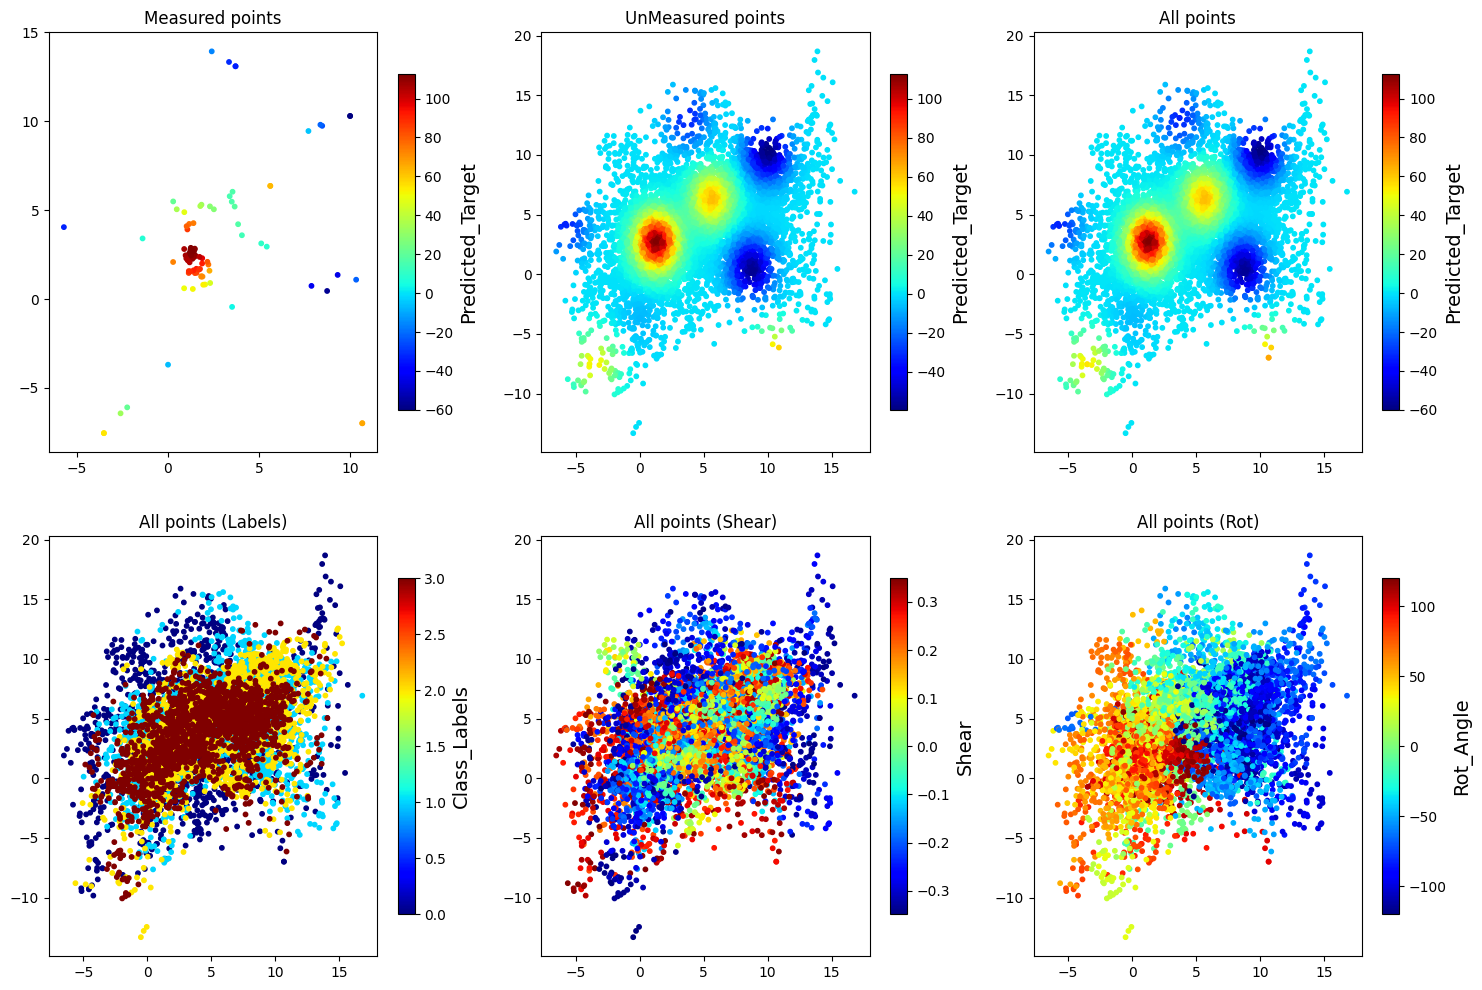

In [69]:
embeded_train6 = dkl_BO_6.embed(X6_train)  # Measured points
embeded_unmeasured6 = dkl_BO_6.embed(X6_unmeasured)  # Unmeasured points
embeded16 = dkl_BO_6.embed(X6)   # All points

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (18,12))

im = ax[0,0].scatter(embeded_train6[:, 1], embeded_train6[:, 0], s=10, c = predmean_train6, cmap = 'jet')
ax[0,0].set_title('Measured points')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_unmeasured6[:, 1], embeded_unmeasured6[:, 0], s=10,
                c = predmean_unmeas6, cmap = 'jet')
ax[0,1].set_title('UnMeasured points')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,2].scatter(embeded16[:, 1], embeded16[:, 0], s=10, c = predmean16, cmap = 'jet')
ax[0,2].set_title('All points')
cbar = fig.colorbar(im, ax=ax[0,2], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded16[:, 1], embeded16[:, 0], s=10, c = labels_all, cmap = 'jet')
ax[1,0].set_title('All points (Labels)')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Class_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded16[:, 1], embeded16[:, 0], s=10, c = shears_all[:,0], cmap = 'jet')
ax[1,1].set_title('All points (Shear)')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Shear", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,2].scatter(embeded16[:, 1], embeded16[:, 0], s=10, c = angles_all, cmap = 'jet')
ax[1,2].set_title('All points (Rot)')
cbar = fig.colorbar(im, ax=ax[1,2], shrink=.8)
cbar.set_label("Rot_Angle", fontsize=14)
cbar.ax.tick_params(labelsize=10)